# Evaluation for Disease Ranking

The code below sets up tests for evaluating the rank_phenotypes python script to get the acccuracy of the ranking system. 

In [1]:
import rank_phenotypes
import random

2254 disease weights loaded!
6251 phenotype weights loaded!


In [2]:
import pandas as pd

In [3]:
def generate_patient(phen_dict):
    """
    Returns a list of the phenotypes the patient has.

    Parameters:
    phen_dict: A dictionary of the diseases phenotypes and corresponding prevalences
    """
    patient_phenotypes = []
    for key in phen_dict.keys():
        num = random.randint(1,100)
        if num/100 <= phen_dict[key]:
            patient_phenotypes.append(key)
    return patient_phenotypes

In [4]:
def test_ranks(trials, phen_dict, disease_id):
    """
    Runs rank_phenotypes for the given number of patients and disease dictionary
    Returns the accuracy of the results (Percentage of trials that gave the correct disease in the top five rankings)
    Parameters:
    trials: A int of the desired number of patient sets to run on
    phen_dict: dictionary of generated phenotypes
    disease_id: GARD of id of corresponding disease
    """
    successes = 0
    for trial in range(trials):
        phenos = generate_patient(phen_dict)
        rank_list = rank_phenotypes.rank_phenotypes_weighted_tfidf(phenos)
        top_ranks = []
        if len(rank_list) > 5:
            for entry in rank_list[:5]:
                top_ranks.append(entry[1]["id"])
        else:
            for entry in rank_list:
                top_ranks.append(entry[1]["id"])
        
        #just in results overall
        #for entry in rank_list:
            #top_ranks.append(entry[1]["id"])
        if disease_id in top_ranks: 
            successes += 1
        #print(top_ranks)
        #print("\n")
    return successes/trials

In [60]:
def get_rank(phen_dict, disease_id):
    """
    Runs rank_phenotypes for the given patient and disease dictionary
    Returns the ranking of the "correct" disease 
    Parameters:
    phen_dict: dictionary of generated phenotypes
    disease_id: GARD of id of corresponding disease
    """
    phenos = generate_patient(phen_dict)
    rank_list = rank_phenotypes.rank_phenotypes_weighted_tfidf(phenos)
    dz_ranks = []
    for entry in rank_list:
        dz_ranks.append(entry[1]["id"])
    if disease_id in dz_ranks: 
        rank = dz_ranks.index(disease_id) + 1
    else:
        rank = 1000
    return rank

In [15]:
#returns a corresponding phenotype:frequency dictionary for the selected prevalence rows from orphanet data
def get_dict(df):
    d = {}
    for index, row in df.iterrows():
        #uses renamed prevalence columns 
        hp_term = row["HPO_ID"]
        prevalence_str = row["Frequency"]
        if "Excluded" in prevalence_str:
            prev = 0.0
        elif "Obligate" in prevalence_str:
            prev = 1.0
        elif "Very rare" in prevalence_str:
            prev = 0.025
        elif "Occasional" in prevalence_str:
            prev = 0.17
        elif "Very frequent" in prevalence_str:
            prev = 0.895
        else:
            prev = 0.545
        d.update({hp_term:prev})
    return d

In [6]:
prevalences = pd.read_csv("phenotype_prevalences.csv")

In [9]:
prevalences = prevalences.rename(columns={"/DisorderList/Disorder/HPODisorderAssociationList/HPODisorderAssociation/HPO/HPOId": "HPO_ID", 
                            "/DisorderList/Disorder/HPODisorderAssociationList/HPODisorderAssociation/HPO/HPOTerm": "HP_Term",
                           "/DisorderList/Disorder/HPODisorderAssociationList/HPODisorderAssociation/HPOFrequency/Name": "Frequency",
                           "/DisorderList/Disorder/Name": "Disease_Name"})
prevalences.head()

,HPO_ID,HP_Term,Frequency,Disease_Name
0,HP:0000256,Macrocephaly,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
1,HP:0000272,Malar flattening,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
2,HP:0000316,Hypertelorism,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
3,HP:0000369,Low-set ears,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
4,HP:0000470,Short neck,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"


In [10]:
prevalences.Frequency.unique()

array(['Very frequent (99-80%)', 'Frequent (79-30%)',
       'Occasional (29-5%)', 'Very rare (<4-1%)', 'Obligate (100%)',
       'Excluded (0%)'], dtype=object)

In [12]:
dz_list = prevalences.Disease_Name.unique()
dz_list

array(['Multiple epiphyseal dysplasia, Al-Gazali type',
       'Alexander disease', 'Alpha-mannosidosis', ..., 'Cleft velum',
       'Bifid uvula', 'Mosaic trisomy 9'], dtype=object)

In [44]:
from py2neo import Database
from py2neo import Graph
from py2neo import Node
db = Database("bolt://disease.ncats.io:80")
graph = db.default_graph

In [64]:
compiled_ranks = []
for dz in dz_list:
    #first see if there is a matching gard ID
    #get rid of the types (makes it less specific)
    dis_name = dz.upper()
    comma = dis_name.find(",")
    if comma != -1:
        dis_name = dis_name[:comma]
    q = """match (m:S_GARD)--(d:DATA) where any(x in m.N_Name where x =~ {dis_name}) RETURN d.gard_id"""
    d = graph.run(q, dis_name=dis_name).to_series()
    
    #if there is a matching gard ID, go through with the test
    if len(d) != 0:
        gard_id = d[:1][0]
        #get the matching rows
        rows = prevalences.loc[prevalences['Disease_Name'] == dz]
        #get phenotype dictionary from rows
        dz_dict = get_dict(rows)
        #run test (creates patient from dictionary, returns ranking, add to ranks)
        compiled_ranks.append(get_rank(dz_dict, gard_id))
        print(f"{dz} rank added!\n")
    else: 
        print("did not get gard match\n")

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000272', 'HP:0000316', 'HP:0000369', 'HP:0000470', 'HP:0000767', 'HP:0002007', 'HP:0002857', 'HP:0005930', 'HP:0006101', 'HP:0030084']
Multiple epiphyseal dysplasia, Al-Gazali type rank added!

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001250', 'HP:0001257', 'HP:0001274', 'HP:0001347', 'HP:0001355', 'HP:0001508', 'HP:0002007', 'HP:0002017', 'HP:0002167', 'HP:0002169', 'HP:0002353', 'HP:0002360', 'HP:0002650', 'HP:0007256', 'HP:0100729', 'HP:0000496', 'HP:0000508', 'HP:0000651', 'HP:0000712', 'HP:0000716', 'HP:0001251', 'HP:0001260', 'HP:0001288', 'HP:0001337', 'HP:0002019', 'HP:0002445', 'HP:0002615', 'HP:0010535', 'HP:0010628', 'HP:0002410', 'HP:0007481']
Alexander disease rank added!

ranking diseases for phenotypes
...['HP:0000158', 'HP:0000280', 'HP:0000365', 'HP:0000518', 'HP:0001249', 'HP:0001263', 'HP:0001744', 'HP:0002240', 'HP:0002652', 'HP:0002750', 'HP:0004493', 'HP:0005280', 'HP:0005978', 'HP:0007957', 'HP:

ranking diseases for phenotypes
...['HP:0000924', 'HP:0000980', 'HP:0001744', 'HP:0001903', 'HP:0001935', 'HP:0011902', 'HP:0000044', 'HP:0000929', 'HP:0001324', 'HP:0002240', 'HP:0004370']
Beta-thalassemia rank added!

ranking diseases for phenotypes
...['HP:0000952', 'HP:0001878', 'HP:0001903', 'HP:0001935', 'HP:0001971', 'HP:0002863', 'HP:0011902']
Alpha-thalassemia rank added!

ranking diseases for phenotypes
...['HP:0001738', 'HP:0002024', 'HP:0002205', 'HP:0002206', 'HP:0002240', 'HP:0002613', 'HP:0002721', 'HP:0004313']
Cystic fibrosis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000767', 'HP:0001315', 'HP:0001387', 'HP:0002486', 'HP:0003198', 'HP:0003236', 'HP:0006785', 'HP:0000912', 'HP:0001771', 'HP:0002515', 'HP:0003141', 'HP:0003306', 'HP:0003418', 'HP:0004631', 'HP:0008948', 'HP:0008956', 'HP:0008994', 'HP:0040083', 'HP:0003307']
Emery-Dreifuss muscular dystrophy rank added!

ranking diseases for phenotypes
...['HP:0000726', 'HP:0001324', '

ranking diseases for phenotypes
...['HP:0004870', 'HP:0001878', 'HP:0002719', 'HP:0012531', 'HP:0000939', 'HP:0001894', 'HP:0001923', 'HP:0002754', 'HP:0010885']
Sickle cell anemia rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0009919', 'HP:0000486', 'HP:0031615', 'HP:0000554', 'HP:0007862']
Retinoblastoma rank added!

ranking diseases for phenotypes
...['HP:0000818', 'HP:0000843', 'HP:0002897', 'HP:0003072', 'HP:0003165', 'HP:0008208', 'HP:0012091', 'HP:0000825', 'HP:0000845', 'HP:0000854', 'HP:0001012', 'HP:0001031', 'HP:0002574', 'HP:0006767', 'HP:0008256', 'HP:0012197', 'HP:0100634', 'HP:0010783']
Multiple endocrine neoplasia type 1 rank added!

ranking diseases for phenotypes
...['HP:0000053', 'HP:0000246', 'HP:0000275', 'HP:0000388', 'HP:0000389', 'HP:0000411', 'HP:0001388', 'HP:0001634', 'HP:0001763', 'HP:0002003', 'HP:0002020', 'HP:0002167', 'HP:0002342', 'HP:0003564', 'HP:0007018', 'HP:0100716']
Fragile X syndrome rank add

Hypophosphatasia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001249', 'HP:0001831', 'HP:0002644', 'HP:0002652', 'HP:0002758', 'HP:0002823', 'HP:0002970', 'HP:0002983', 'HP:0003307', 'HP:0003312', 'HP:0003416', 'HP:0009811', 'HP:0010535', 'HP:0011405']
Hypochondroplasia rank added!

ranking diseases for phenotypes
...['HP:0000268', 'HP:0000682', 'HP:0000684', 'HP:0000767', 'HP:0001363', 'HP:0001387', 'HP:0002650', 'HP:0004322', 'HP:0006487', 'HP:0100530', 'HP:0100777']
Hypophosphatemic rickets rank added!

ranking diseases for phenotypes
...['HP:0007763', 'HP:0000622', 'HP:0007924', 'HP:0200125', 'HP:0000576', 'HP:0000603', 'HP:0011675']
Leber hereditary optic neuropathy rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0002015', 'HP:0002653', 'HP:0002797', 'HP:0002893', 'HP:0004322', 'HP:0004936', 'HP:0005701', 'HP:0006824', 'HP:0007461', 'HP:0100021', 'HP:0100641']
Maffucci syndrome rank added!

ranking disease

did not get gard match

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000384', 'HP:0008572', 'HP:0008678', 'HP:0000402', 'HP:0000413', 'HP:0009796']
BOR syndrome rank added!

ranking diseases for phenotypes
...['HP:0000421', 'HP:0001081', 'HP:0001250', 'HP:0002092', 'HP:0001082', 'HP:0001342', 'HP:0001409', 'HP:0002040', 'HP:0002076', 'HP:0011025', 'HP:0100026', 'HP:0100585']
Hereditary hemorrhagic telangiectasia rank added!

ranking diseases for phenotypes
...['HP:0000294', 'HP:0000316', 'HP:0000324', 'HP:0000426', 'HP:0000929', 'HP:0001357', 'HP:0004209', 'HP:0000348', 'HP:0000444', 'HP:0001156', 'HP:0003307', 'HP:0005037', 'HP:0005280', 'HP:0006101', 'HP:0007598', 'HP:0008572', 'HP:0009899']
Saethre-Chotzen syndrome rank added!

ranking diseases for phenotypes
...['HP:0000262', 'HP:0000348', 'HP:0001156', 'HP:0004322', 'HP:0006101', 'HP:0009773', 'HP:0010669', 'HP:0011304']
Pfeiffer syndrome rank added!

ranking diseases for phenotypes
...['HP:0001003', 'HP:0005244', 'HP:00

ranking diseases for phenotypes
...['HP:0001319', 'HP:0003325', 'HP:0003327', 'HP:0003557', 'HP:0003722', 'HP:0003803', 'HP:0010628', 'HP:0030198', 'HP:0002970', 'HP:0003306']
Typical nemaline myopathy rank added!

ranking diseases for phenotypes
...['HP:0001638', 'HP:0001761', 'HP:0001989', 'HP:0003691', 'HP:0008180', 'HP:0030192', 'HP:0003198', 'HP:0003458', 'HP:0003798', 'HP:0002068', 'HP:0002312', 'HP:0002355', 'HP:0003306', 'HP:0003546', 'HP:0003557', 'HP:0003690', 'HP:0009055', 'HP:0000275', 'HP:0000276']
Childhood-onset nemaline myopathy rank added!

ranking diseases for phenotypes
...['HP:0000486', 'HP:0000639', 'HP:0000992', 'HP:0002227', 'HP:0005599', 'HP:0006739', 'HP:0007513', 'HP:0007730', 'HP:0007750', 'HP:0008499', 'HP:0011364']
Oculocutaneous albinism rank added!

ranking diseases for phenotypes
...['HP:0003198', 'HP:0003458', 'HP:0003798', 'HP:0002067', 'HP:0003326', 'HP:0003722', 'HP:0003803', 'HP:0000347', 'HP:0002747', 'HP:0011968']
Adult-onset nemaline myopathy ran

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000316', 'HP:0000431', 'HP:0001249', 'HP:0001252', 'HP:0001357', 'HP:0004209', 'HP:0100490', 'HP:0000347']
Pentasomy X rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000488', 'HP:0001257', 'HP:0001260', 'HP:0012675']
Neurodegeneration with brain iron accumulation rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000939', 'HP:0000952', 'HP:0001249', 'HP:0001252', 'HP:0001254', 'HP:0001263', 'HP:0001399', 'HP:0001510', 'HP:0001531', 'HP:0001541', 'HP:0001939', 'HP:0002017', 'HP:0008872', 'HP:0010741', 'HP:0100543', 'HP:0100806']
Galactosemia rank added!

ranking diseases for phenotypes
...['HP:0000298', 'HP:0001252', 'HP:0001288', 'HP:0002346', 'HP:0002650']
X-linked centronuclear myopathy rank added!

ranking diseases for phenotypes
...['HP:0001387', 'HP:0003457', 'HP:0004326', 'HP:0009073', 'HP:0100490', 'HP:0001319', 'HP:0001

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000046', 'HP:0000062', 'HP:0001265', 'HP:0001336', 'HP:0001510', 'HP:0001522', 'HP:0001695', 'HP:0002020', 'HP:0002459', 'HP:0002793', 'HP:0008736', 'HP:0010535', 'HP:0011675']
Sudden infant death-dysgenesis of the testes syndrome rank added!

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000233', 'HP:0000316', 'HP:0000400', 'HP:0001156', 'HP:0001163', 'HP:0001171', 'HP:0001231', 'HP:0008388']
Charlie M syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000316', 'HP:0000494', 'HP:0000510', 'HP:0000648', 'HP:0000887', 'HP:0000944', 'HP:0002007', 'HP:0002750', 'HP:0003796', 'HP:0004322', 'HP:0005257', 'HP:0008905']
Axial spondylometaphyseal dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000325', 'HP:0000490', 'HP:0000505', 'HP:0000508', 'HP:0000512', 'HP:0000602', 'HP:0000648', 'HP:0000767', 'HP:0001387', 'HP:0001776', 'HP:0004097', 'HP:0010489', 'HP:0010751'

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001541', 'HP:0001789', 'HP:0001873', 'HP:0001903', 'HP:0010880']
Fetal parvovirus syndrome rank added!

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000505', 'HP:0000508', 'HP:0000649', 'HP:0000708', 'HP:0000762', 'HP:0001263', 'HP:0002119', 'HP:0002194', 'HP:0002230', 'HP:0002514', 'HP:0003202', 'HP:0003236', 'HP:0003355', 'HP:0004322', 'HP:0004326', 'HP:0006887', 'HP:0012120']
Mitochondrial DNA depletion syndrome, encephalomyopathic form with methylmalonic aciduria rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0100022']
Dopa-responsive dystonia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000272', 'HP:0000822', 'HP:0001083', 'HP:0001387', 'HP:0100543']
Isolated ectopia lentis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0011976']
Neuroblastoma rank added!

did not get gard match

ranking dise

ranking diseases for phenotypes
...['HP:0000175', 'HP:0001608', 'HP:0100335']
Congenital laryngomalacia rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000083', 'HP:0001161', 'HP:0001249', 'HP:0001513', 'HP:0006101', 'HP:0008736']
Laurence-Moon syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001249', 'HP:0001188', 'HP:0001258', 'HP:0001288', 'HP:0001347', 'HP:0002381', 'HP:0004322', 'HP:0004374']
MASA syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000215', 'HP:0000248', 'HP:0000272', 'HP:0000327', 'HP:0000343', 'HP:0000407', 'HP:0000431', 'HP:0000463', 'HP:0000518', 'HP:0000545', 'HP:0000646', 'HP:0000655', 'HP:0002829', 'HP:0004322', 'HP:0004327', 'HP:0005280', 'HP:0010669', 'HP:0012368', 'HP:0000179', 'HP:0000316', 'HP:0000505', 'HP:0000520', 'HP:0000653', 'HP:0000966', 'HP:0001006', 'HP:0001083', 'HP:0002857', 'HP:0003196']
Marshall syndrome rank added!

ranking diseases for phenot

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000155', 'HP:0000613', 'HP:0000708', 'HP:0001269', 'HP:0001369', 'HP:0001482', 'HP:0002076', 'HP:0002105', 'HP:0002239', 'HP:0002829', 'HP:0003326', 'HP:0004936', 'HP:0011107', 'HP:0012378', 'HP:0100326', 'HP:0100653', 'HP:0001289', 'HP:0002017', 'HP:0002716', 'HP:0008066', 'HP:0100796', 'HP:0200034']
Behçet disease rank added!

ranking diseases for phenotypes
...['HP:0001252', 'HP:0001945', 'HP:0002039', 'HP:0002093', 'HP:0002633', 'HP:0002829', 'HP:0002960', 'HP:0003236', 'HP:0003457', 'HP:0003701', 'HP:0004303', 'HP:0006530', 'HP:0011675', 'HP:0012378', 'HP:0012544', 'HP:0012735']
Polymyositis rank added!

ranking diseases for phenotypes
...['HP:0000492', 'HP:0000934', 'HP:0000969', 'HP:0000989', 'HP:0001063', 'HP:0001369', 'HP:0001618', 'HP:0001824', 'HP:0002206', 'HP:0002664', 'HP:0002960', 'HP:0003326', 'HP:0003457', 'HP:0003701', 

ranking diseases for phenotypes
...['HP:0001824', 'HP:0001879', 'HP:0002092', 'HP:0002099', 'HP:0002110', 'HP:0002120', 'HP:0002715']
Allergic bronchopulmonary aspergillosis rank added!

ranking diseases for phenotypes
...['HP:0000478', 'HP:0000504', 'HP:0000651', 'HP:0000708', 'HP:0001257', 'HP:0001276', 'HP:0001608', 'HP:0002093', 'HP:0002205', 'HP:0002273', 'HP:0002425', 'HP:0002445', 'HP:0100021']
Locked-in syndrome rank added!

ranking diseases for phenotypes
...['HP:0001873', 'HP:0001945', 'HP:0002017', 'HP:0002027', 'HP:0002039', 'HP:0002152', 'HP:0002315', 'HP:0002615', 'HP:0008150', 'HP:0002098', 'HP:0002240', 'HP:0002716']
Leptospirosis rank added!

ranking diseases for phenotypes
...['HP:0000790', 'HP:0000988', 'HP:0001250', 'HP:0002017', 'HP:0002027', 'HP:0002039', 'HP:0002076', 'HP:0002383', 'HP:0002633', 'HP:0002829', 'HP:0003326', 'HP:0005244', 'HP:0010783', 'HP:0100534', 'HP:0100796', 'HP:0100820', 'HP:0200039']
Immunoglobulin A vasculitis rank added!

did not get gard 

ranking diseases for phenotypes
...['HP:0000822', 'HP:0000975', 'HP:0001482', 'HP:0001646', 'HP:0001654', 'HP:0001658', 'HP:0001824', 'HP:0001945', 'HP:0002039', 'HP:0002076', 'HP:0002617', 'HP:0002633', 'HP:0002637', 'HP:0002829', 'HP:0003326', 'HP:0004372', 'HP:0005111', 'HP:0005244', 'HP:0012378', 'HP:0100533', 'HP:0100545', 'HP:0100576', 'HP:0100735', 'HP:0100749', 'HP:0200042']
Takayasu arteritis rank added!

ranking diseases for phenotypes
...['HP:0012103', 'HP:0000091', 'HP:0000407', 'HP:0001250', 'HP:0001263', 'HP:0001508', 'HP:0002342']
EAST syndrome rank added!

ranking diseases for phenotypes
...['HP:0002097']
Congenital lobar emphysema rank added!

ranking diseases for phenotypes
...['HP:0000010', 'HP:0000112', 'HP:0000639', 'HP:0000648', 'HP:0000726', 'HP:0000819', 'HP:0000873', 'HP:0001250', 'HP:0001251', 'HP:0001260', 'HP:0001959', 'HP:0002093', 'HP:0002120', 'HP:0002871', 'HP:0008872', 'HP:0100016']
Wolfram syndrome rank added!

ranking diseases for phenotypes
...['HP:0

ranking diseases for phenotypes
...['HP:0003237', 'HP:0010702', 'HP:0002910', 'HP:0003262', 'HP:0003453', 'HP:0003493', 'HP:0030908', 'HP:0030909', 'HP:0012432', 'HP:0001394', 'HP:0003573']
Autoimmune hepatitis rank added!

ranking diseases for phenotypes
...['HP:0001278', 'HP:0001402', 'HP:0002841', 'HP:0003155', 'HP:0003493', 'HP:0003496', 'HP:0003073', 'HP:0000953', 'HP:0001394', 'HP:0002613', 'HP:0002908', 'HP:0011971', 'HP:0000820']
Primary biliary cholangitis rank added!

ranking diseases for phenotypes
...['HP:0000505', 'HP:0000716', 'HP:0000790', 'HP:0000975', 'HP:0001369', 'HP:0001387', 'HP:0001596', 'HP:0001824', 'HP:0001872', 'HP:0001945', 'HP:0002039', 'HP:0002315', 'HP:0002321', 'HP:0002633', 'HP:0003401', 'HP:0003565', 'HP:0005216', 'HP:0005244']
Giant cell arteritis rank added!

ranking diseases for phenotypes
...['HP:0000762', 'HP:0001284', 'HP:0002317', 'HP:0003474', 'HP:0003481', 'HP:0009830', 'HP:0010871', 'HP:0011096', 'HP:0012078', 'HP:0030200', 'HP:0002527']
Chron

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000347', 'HP:0001874', 'HP:0001888', 'HP:0002205', 'HP:0002721', 'HP:0003220', 'HP:0004313', 'HP:0004322', 'HP:0005280']
ICF syndrome rank added!

ranking diseases for phenotypes
...['HP:0000202', 'HP:0000238', 'HP:0000639', 'HP:0000657', 'HP:0001249', 'HP:0001250', 'HP:0001251', 'HP:0001252', 'HP:0001263', 'HP:0001288', 'HP:0001320', 'HP:0001696', 'HP:0002104', 'HP:0002793', 'HP:0002876', 'HP:0003312', 'HP:0004422']
Joubert syndrome rank added!

ranking diseases for phenotypes
...['HP:0000889', 'HP:0001171', 'HP:0001387', 'HP:0030680', 'HP:0001163', 'HP:0001199', 'HP:0001629', 'HP:0001631', 'HP:0002650', 'HP:0002808', 'HP:0006501', 'HP:0009777', 'HP:0011705']
Holt-Oram syndrome rank added!

ranking diseases for phenotypes
...['HP:0001056', 'HP:0002208', 'HP:0004782', 'HP:0000535', 'HP:0001482', 'HP:0008070', 'HP:0009886', 'HP:0000400']
Bazex-Dupré-Christol syn

did not get gard match

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000047', 'HP:0000068', 'HP:0000089', 'HP:0000142', 'HP:0000218', 'HP:0000316', 'HP:0000370', 'HP:0000431', 'HP:0000528', 'HP:0000568', 'HP:0000618', 'HP:0000813', 'HP:0001126', 'HP:0001522', 'HP:0001602', 'HP:0001607', 'HP:0002025', 'HP:0003183', 'HP:0004397', 'HP:0006101', 'HP:0006610', 'HP:0007993', 'HP:0010297', 'HP:0010458']
Fraser syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000126', 'HP:0000162', 'HP:0000175', 'HP:0000201', 'HP:0000233', 'HP:0000252', 'HP:0000286', 'HP:0000343', 'HP:0000347', 'HP:0000463', 'HP:0000494', 'HP:0000508', 'HP:0000634', 'HP:0001156', 'HP:0001249', 'HP:0003202', 'HP:0004322', 'HP:0006824', 'HP:0010295']
Carey-Fineman-Ziter syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001644', 'HP:0001706', 'HP:0001874']
Barth syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000047', 'HP:0000164', 'HP:0000174', 'HP:0000252', 'HP:0000294', 'HP:0000311', 'HP:0000316', 'HP:0000319', 'HP:0000368', 'HP:0000400', 'HP:0000470', 'HP:0000486', 'HP:0000574', 'HP:0000670', 'HP:0001177', 'HP:0001252', 'HP:0002916', 'HP:0005280', 'HP:0006610', 'HP:0009738', 'HP:0010720', 'HP:0100490', 'HP:0100543']
Trisomy 4p rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000268', 'HP:0000311', 'HP:0000316', 'HP:0000411', 'HP:0000508', 'HP:0001163', 'HP:0001513', 'HP:0002007', 'HP:0002376', 'HP:0002916', 'HP:0004322', 'HP:0008678', 'HP:0008736']
Trisomy 5p rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000190', 'HP:0000218', 'HP:0000232', 'HP:0000316', 'HP:0000347', 'HP:0000348', 'HP:0000411', 'HP:0000431', 'HP:0000470', 'HP:0000582', 'HP:0001263', 'HP:0001328', 'HP:0001387', 'HP:0002475', 'HP:0002916', 'HP:0008736', 'HP:0010751', 'H

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000112', 'HP:0000121', 'HP:0000212', 'HP:0000682', 'HP:0000684', 'HP:0000705', 'HP:0006286', 'HP:0011073', 'HP:0100530', 'HP:0000805', 'HP:0003127', 'HP:0012365']
Enamel-renal syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000348', 'HP:0000368', 'HP:0000444', 'HP:0000494', 'HP:0000958', 'HP:0001166', 'HP:0001249', 'HP:0001250', 'HP:0001252', 'HP:0001513', 'HP:0001631', 'HP:0001852', 'HP:0002007', 'HP:0002353', 'HP:0002857', 'HP:0002983', 'HP:0004322']
Beta-mercaptolactate cysteine disulfiduria rank added!

ranking diseases for phenotypes
...['HP:0001369', 'HP:0100727', 'HP:0200036']
Multicentric reticulohistiocytosis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000055', 'HP:0000389', 'HP:0000529', 'HP:0000532', 'HP:0000613', 'HP:0000842', 'HP:0000956', 'HP:0001249', 'HP:0001596', 'HP:0001644', 'HP:0001956', 'HP:0002092', 'HP:0

ranking diseases for phenotypes
...['HP:0000717', 'HP:0001249', 'HP:0001250', 'HP:0001263', 'HP:0001999', 'HP:0002007', 'HP:0002167', 'HP:0006951', 'HP:0007065']
X-linked intellectual disability-cerebellar hypoplasia syndrome rank added!

ranking diseases for phenotypes
...['HP:0000518', 'HP:0000639', 'HP:0000708', 'HP:0000750', 'HP:0001107', 'HP:0001249', 'HP:0007513', 'HP:0008046', 'HP:0001251', 'HP:0011364']
Autosomal recessive cerebelloparenchymal disorder type 3 rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000044', 'HP:0001251', 'HP:0007920']
Ataxia-hypogonadism-choroidal dystrophy syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000044', 'HP:0000135', 'HP:0000144', 'HP:0000512', 'HP:0000639', 'HP:0000648', 'HP:0000751', 'HP:0000771', 'HP:0000864', 'HP:0001251', 'HP:0002167', 'HP:0004322', 'HP:0004374', 'HP:0007703']
Cerebellar ataxia-hypogonadism syndrome rank added!

ranking diseases f

ranking diseases for phenotypes
...['HP:0000535', 'HP:0000653', 'HP:0000992', 'HP:0001249', 'HP:0002208', 'HP:0002299', 'HP:0003777', 'HP:0008070', 'HP:0010978', 'HP:0011362']
Hair defect-photosensitivity-intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0001595', 'HP:0002208', 'HP:0002224', 'HP:0002552', 'HP:0011364']
Uncombable hair syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000204', 'HP:0000248', 'HP:0000256', 'HP:0000286', 'HP:0000289', 'HP:0000316', 'HP:0000368', 'HP:0000445', 'HP:0000470', 'HP:0000486', 'HP:0000494', 'HP:0000574', 'HP:0000774', 'HP:0000892', 'HP:0000902', 'HP:0000912', 'HP:0001249', 'HP:0001320', 'HP:0002079', 'HP:0002119', 'HP:0002208', 'HP:0002937', 'HP:0003196', 'HP:0003422', 'HP:0011800', 'HP:0100790']
Cerebrofaciothoracic dysplasia rank added!

did not get gard match

did not get gard match

ranking diseases for phenot

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000478', 'HP:0000504', 'HP:0001251', 'HP:0001252', 'HP:0001263', 'HP:0001266', 'HP:0001284', 'HP:0001336', 'HP:0002069', 'HP:0002191', 'HP:0007359', 'HP:0100022']
Alpers-Huttenlocher syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000104', 'HP:0001510', 'HP:0001562', 'HP:0002089', 'HP:0012245', 'HP:0000776', 'HP:0000834', 'HP:0001629', 'HP:0001642', 'HP:0004794', 'HP:0005343', 'HP:0030680']
SERKAL syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000322', 'HP:0000470', 'HP:0000494', 'HP:0000525', 'HP:0000568', 'HP:0000518', 'HP:0000708', 'HP:0001263', 'HP:0001188', 'HP:0001249', 'HP:0001250', 'HP:0001319', 'HP:0001510', 'HP:0001508', 'HP:0001770', 'HP:001

did not get gard match

ranking diseases for phenotypes
...['HP:0000413', 'HP:0002644', 'HP:0002823', 'HP:0002827', 'HP:0002983', 'HP:0004322', 'HP:0004349', 'HP:0008551']
Coxoauricular syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000256', 'HP:0000280', 'HP:0000286', 'HP:0000294', 'HP:0000343', 'HP:0000463', 'HP:0000470', 'HP:0000527', 'HP:0000574', 'HP:0000885', 'HP:0000944', 'HP:0001256', 'HP:0001640', 'HP:0001654', 'HP:0002162', 'HP:0002230', 'HP:0002652', 'HP:0002673', 'HP:0002750', 'HP:0010109', 'HP:0012471']
Hypertrichotic osteochondrodysplasia, Cantu type rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000049', 'HP:0000218', 'HP:0000248', 'HP:0000252', 'HP:0000324', 'HP:0000349', 'HP:0000407', 'HP:0000431', 'HP:0000457', 'HP:0000494', 'HP:0000767', 'HP:0000889', 'HP:0000912', 'HP:0001156', 'HP:0001249', 'HP:0001252', 'HP:0001363', 'HP:0002007', 'HP:0002079', 'HP:0002162', 'HP:0002224', 'HP:0004

did not get gard match

ranking diseases for phenotypes
...['HP:0000077', 'HP:0000256', 'HP:0000260', 'HP:0000365', 'HP:0000520', 'HP:0000774', 'HP:0000926', 'HP:0000944', 'HP:0000946', 'HP:0001156', 'HP:0001171', 'HP:0001250', 'HP:0001252', 'HP:0001561', 'HP:0001582', 'HP:0001631', 'HP:0002093', 'HP:0002119', 'HP:0002187', 'HP:0002652', 'HP:0002808', 'HP:0002980', 'HP:0002983', 'HP:0003185', 'HP:0005280', 'HP:0006487', 'HP:0006703', 'HP:0007392', 'HP:0008909', 'HP:0012368', 'HP:0100781']
Thanatophoric dysplasia type 1 rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000119', 'HP:0000212', 'HP:0000518', 'HP:0000790', 'HP:0000962', 'HP:0001131', 'HP:0001596', 'HP:0002205', 'HP:0002213', 'HP:0002575', 'HP:0008070', 'HP:0012732']
Hereditary mucoepithelial dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000787', 'HP:0000944', '

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001162', 'HP:0001387', 'HP:0001522', 'HP:0001773', 'HP:0001831', 'HP:0002652', 'HP:0002983', 'HP:0005048', 'HP:0005736', 'HP:0006487', 'HP:0008368', 'HP:0008873', 'HP:0100242', 'HP:0100387']
Acromesomelic dysplasia, Grebe type rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000348', 'HP:0000431', 'HP:0000776', 'HP:0001162', 'HP:0001770', 'HP:0001841', 'HP:0011304']
Greig cephalopolysyndactyly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000248', 'HP:0000294', 'HP:0000316', 'HP:0000327', 'HP:0000483', 'HP:0000492', 'HP:0000504', 'HP:0000639', 'HP:0000647', 'HP:0000677', 'HP:0001163', 'HP:0001537', 'HP:0001643', 'HP:0001760', 'HP:0002208', 'HP:0002230', 'HP:0004322', 'HP:0004440', 'HP:0009882', 'HP:0010940']
Gorlin-Chaudhry-Moss syndrome rank added!

ranking diseases for phenotypes
...['HP:0001903', 'HP:0002716', 'HP:0002961']
Rosaï-Do

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0008751', 'HP:0000961', 'HP:0001615', 'HP:0010307', 'HP:0012735']
Laryngotracheoesophageal cleft rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001802', 'HP:0001810', 'HP:0008404']
Dominant dystrophic epidermolysis bullosa, nails only rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000534', 'HP:0000561', 'HP:0000958', 'HP:0000982', 'HP:0001006', 'HP:0001508', 'HP:0001596', 'HP:0001597', 'HP:0002224', 'HP:0002721', 'HP:0200037', 'HP:0200042']
Epidermolysis bullosa simplex due to plakophilin deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000464', 'HP:0000465', 'HP:0000478', 'HP:0000504']
Sternal cleft rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000047', 'HP:0000175', 'HP:0000204', 'HP:0000348', 'HP:0000369

did not get gard match

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001252', 'HP:0001263', 'HP:0000365', 'HP:0002804', 'HP:0002240', 'HP:0003186', 'HP:0002120']
RFT1-CDG rank added!

ranking diseases for phenotypes
...['HP:0001873', 'HP:0002910', 'HP:0001878', 'HP:0000093', 'HP:0002315', 'HP:0004324', 'HP:0007430', 'HP:0011900', 'HP:0100602', 'HP:0001058', 'HP:0001937', 'HP:0410019']
HELLP syndrome rank added!

ranking diseases for phenotypes
...['HP:0000944', 'HP:0001028', 'HP:0001482', 'HP:0001928', 'HP:0002653', 'HP:0002763', 'HP:0002797', 'HP:0002983', 'HP:0005701', 'HP:0100761', 'HP:0100764']
Ollier disease rank added!

ranking diseases for phenotypes
...['HP:0000079', 'HP:0000126', 'HP:0001839', 'HP:0002414', 'HP:0012300', 'HP:0000368', 'HP:0000474', 'HP:0000954', 'HP:0002944', 'HP:0008593', 'HP:0009112', 'HP:0045026']
Czeizel-Losonci syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard m

ranking diseases for phenotypes
...['HP:0000982', 'HP:0001072', 'HP:0001231', 'HP:0001288', 'HP:0001761', 'HP:0003457', 'HP:0007021', 'HP:0008388', 'HP:0009830', 'HP:0010547']
Palmoplantar keratoderma-spastic paralysis syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000238', 'HP:0002017', 'HP:0002315', 'HP:0002354', 'HP:0002516', 'HP:0000492', 'HP:0000639', 'HP:0030531', 'HP:0100543', 'HP:0000364']
Pineocytoma rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0010799', 'HP:0002315', 'HP:0000708', 'HP:0002344', 'HP:0002516', 'HP:0100543', 'HP:0001250', 'HP:0007045']
Pineoblastoma rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for ph

ranking diseases for phenotypes
...['HP:0000298', 'HP:0001638', 'HP:0002015', 'HP:0003198', 'HP:0003390', 'HP:0003401', 'HP:0009830', 'HP:0010628', 'HP:0000479', 'HP:0001265', 'HP:0002059', 'HP:0002067', 'HP:0002345', 'HP:0002921', 'HP:0002936', 'HP:0003701', 'HP:0100295']
Autosomal recessive progressive external ophthalmoplegia rank added!

ranking diseases for phenotypes
...['HP:0003198', 'HP:0001324', 'HP:0002093', 'HP:0002333', 'HP:0001252', 'HP:0001270', 'HP:0001531', 'HP:0002098', 'HP:0003324', 'HP:0003546', 'HP:0003698', 'HP:0007105', 'HP:0008872', 'HP:0012432', 'HP:0000590']
Mitochondrial DNA depletion syndrome, myopathic form rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000275', 'HP:0000343', 'HP:0000407', 'HP:0000426', 'HP:0000456', 'HP:0000482', 'HP:0000518', 'HP:0000568', 'HP:0000677', 'HP:0000684', 'HP:0001634', 'HP:0001643', 'HP:0001671', 'HP:0002650', 'HP:0002967', 'HP:0004691', 'HP:0009778', 'HP:0011

ranking diseases for phenotypes
...['HP:0000962', 'HP:0007535', 'HP:0100725', 'HP:0200037', 'HP:0000498']
Lichen planus pemphigoides rank added!

ranking diseases for phenotypes
...['HP:0000268', 'HP:0000272', 'HP:0000275', 'HP:0000347', 'HP:0000358', 'HP:0000369', 'HP:0000405', 'HP:0000413', 'HP:0000494', 'HP:0000508', 'HP:0002435', 'HP:0002645', 'HP:0100775', 'HP:0000023', 'HP:0000470', 'HP:0001537', 'HP:0002162', 'HP:0002650', 'HP:0004452', 'HP:0004493', 'HP:0005487', 'HP:0000028', 'HP:0001263']
Lateral meningocele syndrome rank added!

ranking diseases for phenotypes
...['HP:0000939', 'HP:0000541', 'HP:0000938', 'HP:0001141', 'HP:0002515', 'HP:0003016', 'HP:0006957', 'HP:0007957', 'HP:0008947', 'HP:0012109', 'HP:0030490', 'HP:0003366']
Osteoporosis-pseudoglioma syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
..

did not get gard match

ranking diseases for phenotypes
...['HP:0001161', 'HP:0001249', 'HP:0001363', 'HP:0001680', 'HP:0002463', 'HP:0005692']
16p13.11 microduplication syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000047', 'HP:0000485', 'HP:0000492', 'HP:0001249', 'HP:0001257', 'HP:0001263', 'HP:0005517', 'HP:0008619', 'HP:0012374']
N syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001580', 'HP:0001003', 'HP:0000147', 'HP:0000845', 'HP:0001007', 'HP:0001034', 'HP:0002893', 'HP:0008225', 'HP:0008675', 'HP:0009588', 'HP:0011672', 'HP:0040086', 'HP:0100008', 'HP:0002297', 'HP:0002331', 'HP:0002640', 'HP:0010619']
Carney complex rank added!

ranking diseases for phenotypes
...['HP:0003326', 'HP:0003394', 'HP:0003458', 'HP:0003473', 'HP:0030200', 'HP:0100301']
Tubular aggregate myopathy rank added!

ranking diseases for phenotypes
...['HP:0001288', 'HP:0002123', 'HP:0002167', 'HP:0002353', 'HP:0003457', 'HP:0008955']
Sp

did not get gard match

ranking diseases for phenotypes
...['HP:0012358', 'HP:0000252', 'HP:0000639', 'HP:0001263', 'HP:0001344', 'HP:0001347', 'HP:0001394', 'HP:0001433', 'HP:0001873', 'HP:0003155', 'HP:0003256', 'HP:0008935', 'HP:0011172', 'HP:0012301']
COG4-CDG rank added!

ranking diseases for phenotypes
...['HP:0000201', 'HP:0000219', 'HP:0000319', 'HP:0000368', 'HP:0000470', 'HP:0000938', 'HP:0001103', 'HP:0001320', 'HP:0001508', 'HP:0001999', 'HP:0003026', 'HP:0003316', 'HP:0004582', 'HP:0008897', 'HP:0011995', 'HP:0030282', 'HP:0000253', 'HP:0003422']
COG1-CDG rank added!

ranking diseases for phenotypes
...['HP:0012363', 'HP:0001324', 'HP:0001644', 'HP:0002401', 'HP:0002910', 'HP:0003487', 'HP:0003749', 'HP:0003805', 'HP:0008331', 'HP:0008981']
DPM3-CDG rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001270', 'HP:0008947', 'HP:0000252', 'HP:0004322', 'HP:0000470', 'HP:0001348', 'HP:0001433', 'HP:0002342', 'HP:0002506', 'HP:0009473', 

did not get gard match

ranking diseases for phenotypes
...['HP:0002211', 'HP:0005599', 'HP:0007544', 'HP:0000343', 'HP:0001249', 'HP:0002251']
Piebaldism rank added!

ranking diseases for phenotypes
...['HP:0000151', 'HP:0000347', 'HP:0000411', 'HP:0000470', 'HP:0001180', 'HP:0001511', 'HP:0001849', 'HP:0002164', 'HP:0002705', 'HP:0002983', 'HP:0002984', 'HP:0002990', 'HP:0002992', 'HP:0003498', 'HP:0006487', 'HP:0008517', 'HP:0008736', 'HP:0100257']
Phocomelia, Schinzel type rank added!

ranking diseases for phenotypes
...['HP:0000343', 'HP:0000402', 'HP:0000405', 'HP:0002002', 'HP:0003019', 'HP:0003031', 'HP:0004059', 'HP:0005105', 'HP:0005288', 'HP:0005792', 'HP:0006420', 'HP:0008551', 'HP:0009601', 'HP:0009813', 'HP:0009896', 'HP:0009906', 'HP:0011675', 'HP:0100257']
Phocomelia-ectrodactyly-deafness-sinus arrhythmia syndrome rank added!

ranking diseases for phenotypes
...['HP:0007099', 'HP:0002315', 'HP:0002331', 'HP:0030833', 'HP:0040010', 'HP:0001293', 'HP:0001605', 'HP:0002196

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000054', 'HP:0000121', 'HP:0000175', 'HP:0000193', 'HP:0000233', 'HP:0000252', 'HP:0000405', 'HP:0000483', 'HP:0000582', 'HP:0000592', 'HP:0000954', 'HP:0001100', 'HP:0001274', 'HP:0001864', 'HP:0002101', 'HP:0002162', 'HP:0002788', 'HP:0002828', 'HP:0003196', 'HP:0004209', 'HP:0005495', 'HP:0006801', 'HP:0009913', 'HP:0010034', 'HP:0010864', 'HP:0010945', 'HP:0012758', 'HP:0040018', 'HP:0001305', 'HP:0100790']
Trisomy 8p rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0007519', 'HP:0009751', 'HP:0010311', 'HP:0200055', 'HP:0000076', 'HP:0000081', 'HP:0000356', 'HP:0000768', 'HP:0000772', 'HP:0000773', 'HP:0002084', 'HP:0002162', 'HP:0006501', 'HP:0009601', 'HP:0010579']
Poland syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001162', 'HP:0002187', 'HP:0000303', 'HP:00013

Wiedemann-Rautenstrauch syndrome rank added!

ranking diseases for phenotypes
...['HP:0000161', 'HP:0000202', 'HP:0000252', 'HP:0000303', 'HP:0000505', 'HP:0000568', 'HP:0001199', 'HP:0001249', 'HP:0001629', 'HP:0001839']
MMEP syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000470', 'HP:0000473', 'HP:0001435', 'HP:0003043', 'HP:0008952']
Sprengel deformity rank added!

ranking diseases for phenotypes
...['HP:0003236', 'HP:0030099', 'HP:0002317', 'HP:0003551', 'HP:0008981', 'HP:0010864', 'HP:0003391']
Alpha-dystroglycan-related  limb-girdle muscular dystrophy R16 rank added!

ranking diseases for phenotypes
...['HP:0000613', 'HP:0000670', 'HP:0000682', 'HP:0000982', 'HP:0001072', 'HP:0001131', 'HP:0001156', 'HP:0001817', 'HP:0003510', 'HP:0004279', 'HP:0000230', 'HP:0001163', 'HP:0001231', 'HP:0010783', 'HP:0012047']
Corneodermatoosseous syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001251', 'HP:0001276', 'H

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000252', 'HP:0000426', 'HP:0000430', 'HP:0000431', 'HP:0000445', 'HP:0001249', 'HP:0001263', 'HP:0001328', 'HP:0002300', 'HP:0002357', 'HP:0003510', 'HP:0004209', 'HP:0010529', 'HP:0000494', 'HP:0000648', 'HP:0001252', 'HP:0001257', 'HP:0001376', 'HP:0001510', 'HP:0001511', 'HP:0001792', 'HP:0007598', 'HP:0010624', 'HP:0010761', 'HP:0001629']
Filippi syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000046', 'HP:0000135', 'HP:0000164', 'HP:0000204', 'HP:0000347', 'HP:0000400', 'HP:0000411', 'HP:0000670', 'HP:0000968', 'HP:0000972', 'HP:0001249', 'HP:0001596', 'HP:0001770', 'HP:0001810', 'HP:0002553', 'HP:0002744', 'HP:0003777', 'HP:0005338', 'HP:0006101', 'HP:0006482', 'HP:0006610', 'HP:0007598', 'HP:0008404', 'HP:0010669', 'HP:0100840']
Zlotogora-Ogur syndrome rank added!

did not get gard match

ranking diseases for phenot

did not get gard match

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000316', 'HP:0000347', 'HP:0000431', 'HP:0000494', 'HP:0001249', 'HP:0001252', 'HP:0001347', 'HP:0002007', 'HP:0002119', 'HP:0002120', 'HP:0004322', 'HP:0007360', 'HP:0007370', 'HP:0012430']
White matter hypoplasia-corpus callosum agenesis-intellectual disability syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000248', 'HP:0001357', 'HP:0001558', 'HP:0002342', 'HP:0007000', 'HP:0010864']
X-linked intellectual disability-plagiocephaly syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001362', 'HP:0004471', 'HP:0007383', 'HP:0010301', 'HP:0001770', 'HP:0003010']
Aplasia cutis congenita rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

d

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001627', 'HP:0001629', 'HP:0001635', 'HP:0001651', 'HP:0001680', 'HP:0002089', 'HP:0004971', 'HP:0030680', 'HP:0001719', 'HP:0010773', 'HP:0011560', 'HP:0100790']
Scimitar syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000388', 'HP:0000389', 'HP:0000979', 'HP:0001392', 'HP:0001744', 'HP:0001888', 'HP:0001973', 'HP:0002090', 'HP:0002110', 'HP:0002716', 'HP:0002721', 'HP:0002837', 'HP:0002910', 'HP:0004313', 'HP:0100723']
Common variable immunodeficiency rank added!

ranking diseases for phenotypes
...['HP:0001744', 'HP:0002716', 'HP:0002730', 'HP:0002960', 'HP:0000978', 'HP:0001890', 'HP:0001892', 'HP:0001904', 'HP:0001971', 'HP:0003237', 'HP:0010702', 'HP:0030782', 'HP:0000099', 'HP:0002848', 'HP:0003613', 'HP:0012115', 'HP:0030080', 'HP:0031020']
Autoimmune lymphoproliferative syndrome rank added!

ranking diseases for p

ranking diseases for phenotypes
...['HP:0001009', 'HP:0004952', 'HP:0002140', 'HP:0002326', 'HP:0000421', 'HP:0000961', 'HP:0002105', 'HP:0040223']
Pulmonary arteriovenous malformation rank added!

ranking diseases for phenotypes
...['HP:0008357', 'HP:0030657', 'HP:0000978', 'HP:0001342', 'HP:0001933', 'HP:0012233', 'HP:0000132', 'HP:0000225', 'HP:0001058', 'HP:0001934', 'HP:0031364', 'HP:0200067']
Congenital factor XIII deficiency rank added!

ranking diseases for phenotypes
...['HP:0000737', 'HP:0001254', 'HP:0001263', 'HP:0001298', 'HP:0001638', 'HP:0001985', 'HP:0002093', 'HP:0002240', 'HP:0002615', 'HP:0002910', 'HP:0003162', 'HP:0003201', 'HP:0003215', 'HP:0003234', 'HP:0004756', 'HP:0008331', 'HP:0011675', 'HP:0040290', 'HP:0045045']
Carnitine-acylcarnitine translocase deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000054', 'HP:0000519', 'HP:0000568', 'HP:0000961', 'HP:0000978', 'HP:0001649', 'HP:0001667', 'HP:0001712', 'HP:0001892', 'HP

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000093', 'HP:0000097', 'HP:0000117', 'HP:0000787', 'HP:0000790', 'HP:0001252', 'HP:0002027', 'HP:0002150', 'HP:0002653', 'HP:0002757', 'HP:0003355', 'HP:0003236', 'HP:0010580', 'HP:0003076', 'HP:0003109', 'HP:0003126', 'HP:0003149', 'HP:0003152', 'HP:0005576', 'HP:0005574', 'HP:0008732']
Dent disease rank added!

ranking diseases for phenotypes
...['HP:0009806', 'HP:0003228', 'HP:0004906', 'HP:0001945', 'HP:0002019', 'HP:0002039', 'HP:0001250']
Nephrogenic diabetes insipidus rank added!

ranking diseases for phenotypes
...['HP:0000822', 'HP:0001324', 'HP:0002153']
Pseudohypoaldosteronism type 2 rank added!

ranking diseases for phenotypes
...['HP:0005547', 'HP:0001744', 'HP:0001945', 'HP:0001974', 'HP:0012378']
Chronic myeloid leukemia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0012379', 'HP:0002878']
Butyrylcholinesterase deficiency rank added!

did not get gard match

did not get gard match

did 

did not get gard match

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000939', 'HP:0000963', 'HP:0000974', 'HP:0001252', 'HP:0001367', 'HP:0001373', 'HP:0001385', 'HP:0001387', 'HP:0002036', 'HP:0002300', 'HP:0002357', 'HP:0002381', 'HP:0002673', 'HP:0002748', 'HP:0002749', 'HP:0002827', 'HP:0003010', 'HP:0005692', 'HP:0005743', 'HP:0007392', 'HP:0010529', 'HP:0100633', 'HP:0100790', 'HP:0000023', 'HP:0000286', 'HP:0000347', 'HP:0005280', 'HP:0100541']
Dermatosparaxis Ehlers-Danlos syndrome rank added!

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000470', 'HP:0000824', 'HP:0008213', 'HP:0008245', 'HP:0010627', 'HP:0012287']
Non-acquired combined pituitary hormone deficiency-sensorineural hearing loss-spine abnormalities syndrome rank added!

ranking diseases for phenotypes
...['HP:0000963', 'HP:0000974', 'HP:0001001', 'HP:0001252', 'HP:0001373', 'HP:0001385', 'HP:0002300', 'HP:0002357', 'HP:0002381', 'HP:0002673', 'HP:0002812', 'HP:0002827', 'HP:0003510', 'HP:000569

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001263', 'HP:0001999', 'HP:0008551', 'HP:0008872', 'HP:0008947', 'HP:0012385', 'HP:0000089', 'HP:0000347', 'HP:0000938', 'HP:0001159', 'HP:0011471', 'HP:0000252', 'HP:0001627', 'HP:0008197']
Cerebrofacioarticular syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000252', 'HP:0001249', 'HP:0001263', 'HP:0001290', 'HP:0001999', 'HP:0000154', 'HP:0000486', 'HP:0000490', 'HP:0000687', 'HP:0001508', 'HP:0002020', 'HP:0011024', 'HP:0011339', 'HP:0011968', 'HP:0000924'

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001290', 'HP:0002013', 'HP:0002151', 'HP:0003128', 'HP:0012758', 'HP:0001254', 'HP:0001257', 'HP:0002240', 'HP:0002480', 'HP:0002910', 'HP:0011968', 'HP:0100724', 'HP:0003234']
Pyruvate dehydrogenase E3 deficiency rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000155', 'HP:0001581', 'HP:0001845', 'HP:0001875', 'HP:0001903', 'HP:0012378', 'HP:0100806']
Cyclic neutropenia rank added!

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000952', 'HP:0001541', 'HP:0002027', 'HP:0003573']
Hepatic veno-occlusive disease rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000988', 'HP:0000989', 'HP:0001369', 'HP:0001371', 'HP:0001482', 'HP:0002017', 'HP:0008066', 'HP:0011134', 'HP:0100658', 'HP:0200042']
Dracunculiasis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001531', 'HP:0002154', 'HP:

ranking diseases for phenotypes
...['HP:0002797', 'HP:0011842', 'HP:0012735', 'HP:0025408', 'HP:0000421', 'HP:0003084', 'HP:0003174', 'HP:0100310', 'HP:0002088', 'HP:0002202', 'HP:0045026', 'HP:0100763', 'HP:0100766', 'HP:0001892']
Kaposiform lymphangiomatosis rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001004', 'HP:0001231', 'HP:0002092', 'HP:0002205', 'HP:0002664', 'HP:0011367', 'HP:0012735', 'HP:0100526', 'HP:0100797']
Yellow nail syndrome rank added!

ranking diseases for phenotypes
...['HP:0001824', 'HP:0001873', 'HP:0001875', 'HP:0001959', 'HP:0002015', 'HP:0010783', 'HP:0012378', 'HP:0012733', 'HP:0100792', 'HP:0100806', 'HP:0002024', 'HP:0002027', 'HP:0002910', 'HP:0003781', 'HP:0012735', 'HP:0000142', 'HP:0002575']
Toxic epidermal necrolysis rank added!

ranking diseases for phenotypes
...['HP:0000765', 'HP:0000925', 'HP:0001061', 'HP:0002028', 'HP:0002653', 'HP:0002797', 

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001263', 'HP:0001999', 'HP:0008947', 'HP:0000400', 'HP:0001956', 'HP:0002465', 'HP:0012301', 'HP:0012443', 'HP:0000219', 'HP:0000540', 'HP:0001321', 'HP:0002136', 'HP:0002342']
MAN1B1-CDG rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000118', 'HP:0000837', 'HP:0008669', 'HP:0008734', 'HP:0011961', 'HP:0012205', 'HP:0012864', 'HP:0012868']
Male infertility with teratozoospermia due to single gene mutation rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking dise

did not get gard match

ranking diseases for phenotypes
...['HP:0000467', 'HP:0000508', 'HP:0002015', 'HP:0002033', 'HP:0002882', 'HP:0003473', 'HP:0003701', 'HP:0004661', 'HP:0011968', 'HP:0000602', 'HP:0001249', 'HP:0001558', 'HP:0002804', 'HP:0002872', 'HP:0003324', 'HP:0003388', 'HP:0010536', 'HP:0100295', 'HP:0001250', 'HP:0001270', 'HP:0003306', 'HP:0012801']
Congenital myasthenic syndrome rank added!

ranking diseases for phenotypes
...['HP:0000822', 'HP:0011740', 'HP:0040084']
Familial hyperaldosteronism type II rank added!

ranking diseases for phenotypes
...['HP:0001744', 'HP:0001824', 'HP:0001945', 'HP:0002716', 'HP:0030166', 'HP:0100721']
Follicular lymphoma rank added!

ranking diseases for phenotypes
...['HP:0001903', 'HP:0005528', 'HP:0001896', 'HP:0000421']
Idiopathic aplastic anemia rank added!

ranking diseases for phenotypes
...['HP:0001260', 'HP:0001300', 'HP:0002063', 'HP:0002067', 'HP:0002172', 'HP:0002174', 'HP:0002459', 'HP:0004926', 'HP:0007256', 'HP:0010536', 

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000939', 'HP:0001510', 'HP:0001513', 'HP:0002653', 'HP:0002663', 'HP:0002750', 'HP:0002857', 'HP:0003077', 'HP:0003251', 'HP:0003782', 'HP:0008222', 'HP:0008675', 'HP:0000855', 'HP:0001397', 'HP:0000028', 'HP:0000061', 'HP:0000098', 'HP:0000786', 'HP:0000815']
Aromatase deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001376', 'HP:0001482', 'HP:0003011', 'HP:0003326', 'HP:0004298', 'HP:0007703', 'HP:0008069', 'HP:0010614', 'HP:0100245', 'HP:0200008']
Desmoid tumor rank added!

ranking diseases for phenotypes
...['HP:0000311', 'HP:0000518', 'HP:0000739', 'HP:0000822', 'HP:0000858', 'HP:0000939', 'HP:0000963', 'HP:0000978', 'HP:0000979', 'HP:0001061', 'HP:0001065', 'HP:0001324', 'HP:0001510', 'HP:0001956', 'HP:0002230', 'HP:0002900', 'HP:0010885', 'HP:0010978', 'HP:0100639']
Cushing syndrome rank added!

ranking diseases for phenotypes
...['HP:000

ranking diseases for phenotypes
...['HP:0000965', 'HP:0000979', 'HP:0000988', 'HP:0001025', 'HP:0001581', 'HP:0001945', 'HP:0002633', 'HP:0003326', 'HP:0010783', 'HP:0100758', 'HP:0200034']
Cutaneous small vessel vasculitis rank added!

ranking diseases for phenotypes
...['HP:0001880', 'HP:0003212', 'HP:0002716', 'HP:0010286']
Kimura disease rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001263', 'HP:0002151', 'HP:0002919', 'HP:0003115', 'HP:0003458', 'HP:0000750', 'HP:0001250', 'HP:0001251', 'HP:0002071', 'HP:0002311', 'HP:0002376', 'HP:0002579', 'HP:0003128', 'HP:0004305', 'HP:0008872', 'HP:0008942', 'HP:0011343', 'HP:0000639', 'HP:0001276', 'HP:0001297', 'HP:0002169']
Recurrent metabolic encephalomyopathic crises-rhabdomyolysis-cardiac arrhythmia-intellectual disability syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotyp

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000952', 'HP:0000989', 'HP:0001081', 'HP:0001824', 'HP:0002017', 'HP:0002039', 'HP:0002611', 'HP:0002910', 'HP:0011985', 'HP:0012378']
Benign recurrent intrahepatic cholestasis rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0002398', 'HP:0002817', 'HP:0003134', 'HP:0003457', 'HP:0007149']
Monomelic amyotrophy rank added!

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001770', 'HP:0006101', 'HP:0000028', 'HP:0000929', 'HP:0001159', 'HP:0001249', 'HP:0001363', 'HP:0001513', 'HP:0003241', 'HP:0010442', 'HP:0000481', 'HP:0002676', 'HP:0002857', 'HP:0001748']
Carpenter syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000272', 'HP:0001256', 'HP:0002661', 'HP:0007021']
Hereditary sensory and autonomic neuropathy type 5 rank added!

ranking diseases for phenotypes
...['HP:0001251', 'HP:0001284', 'HP:0006855', 'HP:0007141', 'HP:0001152', 'HP:0002141', 'HP:0003474']
Spinocerebellar ata

ranking diseases for phenotypes
...['HP:0000486', 'HP:0000602', 'HP:0000726', 'HP:0000823', 'HP:0001251', 'HP:0001288', 'HP:0001510', 'HP:0001654', 'HP:0001744', 'HP:0001873', 'HP:0001903', 'HP:0002123', 'HP:0002240', 'HP:0002659', 'HP:0002797', 'HP:0010702', 'HP:0010885', 'HP:0011001', 'HP:0012378']
Gaucher disease type 3 rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001824', 'HP:0001945', 'HP:0001974', 'HP:0002315', 'HP:0002829', 'HP:0002907', 'HP:0003326', 'HP:0004326', 'HP:0004840', 'HP:0005561', 'HP:0005901', 'HP:0011001', 'HP:0012647', 'HP:0100769', 'HP:0200034']
Majeed syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000822', 'HP:0000855', 'HP:0100578', 'HP:0000819', 'HP:0000831', 'HP:0000991', 'HP:0002240', 'HP:0003635', 'HP:0003712', 'HP:0008065', 'HP:0000963', 'HP:0002621', 'HP:0009042', 'HP:0000147', 'HP:0000876', 'HP:0001397', 'HP:0009800', 'HP:0012084', 'HP

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0002014', 'HP:0002013']
Congenital sucrase-isomaltase deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000709', 'HP:0000716', 'HP:0000739', 'HP:0000958', 'HP:0001482', 'HP:0001513', 'HP:0001581', 'HP:0002215', 'HP:0002225', 'HP:0002376', 'HP:0002829', 'HP:0012378', 'HP:0100585']
Adiposis dolorosa rank added!

ranking diseases for phenotypes
...['HP:0000093', 'HP:0000509', 'HP:0000988', 'HP:0000989', 'HP:0001541', 'HP:0002017', 'HP:0002027', 'HP:0002105', 'HP:0002718', 'HP:0004431', 'HP:0007400', 'HP:0011944', 'HP:0012735', 'HP:0100021', 'HP:0100326', 'HP:0100533', 'HP:0100534', 'HP:0100665', 'HP:0100820']
Hypocomplementemic urticarial vasculitis rank added!

ranking diseases for phenotypes
...['HP:0000613', 'HP:0000795', 'HP:0001824', 'HP:0001874', 'HP:0001945', 'HP:0002014', 'HP:0002015', 'HP:0002017', 'HP:0002205', 'HP:0002910', 'HP:0

ranking diseases for phenotypes
...['HP:0000935', 'HP:0000938', 'HP:0002650', 'HP:0002757', 'HP:0012802']
Gnathodiaphyseal dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0001394', 'HP:0001396', 'HP:0001397', 'HP:0001511', 'HP:0001994', 'HP:0003128', 'HP:0003281', 'HP:0012464', 'HP:0012465']
GRACILE syndrome rank added!

ranking diseases for phenotypes
...['HP:0000643', 'HP:0000716', 'HP:0000750', 'HP:0000819', 'HP:0001276', 'HP:0001337', 'HP:0002072', 'HP:0003281', 'HP:0005505', 'HP:0007863', 'HP:0010837', 'HP:0012465']
Aceruloplasminemia rank added!

ranking diseases for phenotypes
...['HP:0012531', 'HP:0000126', 'HP:0000822', 'HP:0001824', 'HP:0001897', 'HP:0003138', 'HP:0003565', 'HP:0005310', 'HP:0011227', 'HP:0025379', 'HP:0030157', 'HP:0031191', 'HP:0000872', 'HP:0001370', 'HP:0010741']
IgG4-related retroperitoneal fibrosis rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases fo

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000592', 'HP:0000939', 'HP:0000974', 'HP:0000977', 'HP:0001119', 'HP:0001131', 'HP:0001166', 'HP:0001822', 'HP:0003326', 'HP:0005692', 'HP:0009887', 'HP:0011003', 'HP:0100689']
Brittle cornea syndrome rank added!

ranking diseases for phenotypes
...['HP:0001004', 'HP:0001072', 'HP:0001250', 'HP:0001824', 'HP:0001888', 'HP:0002024', 'HP:0002027', 'HP:0003073', 'HP:0003075', 'HP:0004313', 'HP:0012378', 'HP:0100763', 'HP:0200043']
Primary intestinal lymphangiectasia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000214', 'HP:0000969', 'HP:0001211', 'HP:0002017', 'HP:0002960', 'HP:0003761', 'HP:0011838', 'HP:0030053', 'HP:0100679', 'HP:0200042']
CREST syndrome rank added!

ranking diseases for phenotypes
...['HP:0001010', 'HP:0004334']
Localized scleroderma rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000670', 'HP:0000934', '

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000033', 'HP:0000037', 'HP:0000047', 'HP:0000048', 'HP:0000057', 'HP:0000061', 'HP:0000062', 'HP:0000127', 'HP:0000140', 'HP:0000142', 'HP:0000144', 'HP:0000147', 'HP:0000771', 'HP:0000823', 'HP:0000833', 'HP:0000840', 'HP:0000868', 'HP:0002750', 'HP:0000848', 'HP:0008207', 'HP:0000939', 'HP:0001941', 'HP:0001944', 'HP:0001952', 'HP:0001998', 'HP:0002013', 'HP:0002615', 'HP:0002902', 'HP:0003154', 'HP:0012605', 'HP:0004349', 'HP:0004924', 'HP:0005616', 'HP:0007440', 'HP:0008226', 'HP:0008232', 'HP:0008258', 'HP:0008730', 'HP:0011106', 'HP:0011749', 'HP:0011968', 'HP:0011969', 'HP:0012244', 'HP:0012412', 'HP:0100779']
Congenital adrenal hyperplasia due to 3-beta-hydroxysteroid dehydrogenase deficiency rank added!

ranking diseases for phenotype

did not get gard match

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000498', 'HP:0000670', 'HP:0000938', 'HP:0000987', 'HP:0000989', 'HP:0001056', 'HP:0001510', 'HP:0001644', 'HP:0001802', 'HP:0001817', 'HP:0002015', 'HP:0002019', 'HP:0002043', 'HP:0004057', 'HP:0004334', 'HP:0004378', 'HP:0004552', 'HP:0005505', 'HP:0006739', 'HP:0008066', 'HP:0010296', 'HP:0011457']
Severe generalized recessive dystrophic epidermolysis bullosa rank added!

ranking diseases for phenotypes
...['HP:0001056', 'HP:0001075', 'HP:0008066', 'HP:0200097']
Transient bullous dermolysis of the newborn rank added!

ranking diseases for phenotypes
...['HP:0001810', 'HP:0008391']
Pretibial dystrophic epidermolysis bullosa rank added!

ranking diseases for phenotypes
...['HP:0000962', 'HP:0001785', 'HP:0002619', 'HP:0002624', 'HP:0003550', 'HP:0200058']
Milroy disease rank added!

ranking diseases for phenotypes
...['HP:0001019', 'HP:0008066', 'HP:0200151', 'HP:0001000', 'HP:0001072', 'HP:0002240']
Diffus

ranking diseases for phenotypes
...['HP:0000708', 'HP:0000716', 'HP:0000739', 'HP:0001324', 'HP:0001402', 'HP:0001824', 'HP:0002017', 'HP:0002027', 'HP:0002039', 'HP:0002385', 'HP:0003326', 'HP:0011675', 'HP:0012086', 'HP:0100735', 'HP:0100785']
Acute intermittent porphyria rank added!

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000987', 'HP:0000992', 'HP:0001155', 'HP:0001744', 'HP:0001760', 'HP:0001878', 'HP:0002757', 'HP:0008066', 'HP:0010472', 'HP:0012086']
Congenital erythropoietic porphyria rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000238', 'HP:0000256', 'HP:0001252', 'HP:0001305', 'HP:0003198']
B4GALT1-CDG rank added!

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001399', 'HP:0001508']
MOGS-CDG rank added!

ranking diseases for phenotypes
...['HP:0000098', 'HP:0006887', 'HP:0010864']
MGAT2-CDG rank added!

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001252', 'HP:0001399', 'HP:0100543']
ALG9-CDG rank added!

ran

did not get gard match

ranking diseases for phenotypes
...['HP:0001876', 'HP:0011974', 'HP:0012143', 'HP:0012378', 'HP:0004820']
Acute panmyelosis with myelofibrosis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0010972', 'HP:0012378', 'HP:0001017', 'HP:0001962', 'HP:0002875', 'HP:0025065']
Refractory anemia with excess blasts rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0012490', 'HP:0030350', 'HP:0001433', 'HP:0003256']
Subcutaneous panniculitis-like T-cell lymphoma rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001817', 'HP:0008625', 'HP:0000164', 'HP:0000677', 'HP:0001199', 'HP:0008386', 'HP:0001763', 'HP:0002465', 'HP:0009778']
Autosomal dominant deafness-onychodystrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000212', 'HP:0000343', 'HP:0000431', 'HP:0001167', 'HP:0001231', 'HP:0001263', 'HP:0001780', 'HP:0001817', 'H

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000132', 'HP:0000311', 'HP:0000716', 'HP:0000739', 'HP:0000789', 'HP:0000939', 'HP:0000963', 'HP:0001508', 'HP:0001956', 'HP:0002230', 'HP:0002893', 'HP:0008221', 'HP:0009125', 'HP:0100585', 'HP:0100608']
Cushing disease rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001627', 'HP:0002092', 'HP:0003546', 'HP:0001324', 'HP:0001962', 'HP:0002875', 'HP:0004755', 'HP:0005110', 'HP:0005317', 'HP:0012418', 'HP:0030148', 'HP:0001541', 'HP:0001708', 'HP:0002105', 'HP:0003270', 'HP:0004840', 'HP:0012382', 'HP:0001892']
Eisenmenger syndrome rank added!

did not get gard match

did not get gard ma

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000280', 'HP:0001376', 'HP:0001654', 'HP:0001744', 'HP:0002240', 'HP:0002652', 'HP:0003468', 'HP:0007256', 'HP:0007957', 'HP:0012384', 'HP:0100790']
Hurler-Scheie syndrome rank added!

ranking diseases for phenotypes
...['HP:0000158', 'HP:0000232', 'HP:0000268', 'HP:0000280', 'HP:0000293', 'HP:0000431', 'HP:0000463', 'HP:0000470', 'HP:0000501', 'HP:0000772', 'HP:0000822', 'HP:0000889', 'HP:0000924', 'HP:0001249', 'HP:0001252', 'HP:0001263', 'HP:0001376', 'HP:0001510', 'HP:0001522', 'HP:0001638', 'HP:0002007', 'HP:0002028', 'HP:0002230', 'HP:0002240', 'HP:0002360', 'HP:0002652', 'HP:0003275', 'HP:0003468', 'HP:0004322', 'HP:0005280', 'HP:0007256', 'HP:0007957', 'HP:0008155', 'HP:0011968', 'HP:0012384', 'HP:0100021', 'HP:0100490', 'HP:0100729', 'HP:0100765', 'HP:0100790']
Hurler syndrome rank added!

ranking diseases for phenotypes
...['HP:0001163', 'HP:0004691', 'HP:0006097', 'HP:0100490']
Syndactyl

ranking diseases for phenotypes
...['HP:0001386', 'HP:0002829', 'HP:0003125', 'HP:0011889', 'HP:0001907', 'HP:0007420', 'HP:0030140', 'HP:0002170']
Hemophilia A rank added!

ranking diseases for phenotypes
...['HP:0000590', 'HP:0030319', 'HP:0007838', 'HP:0000597', 'HP:0000301', 'HP:0008376', 'HP:0200136', 'HP:0009063', 'HP:0008944', 'HP:0007149', 'HP:0002747', 'HP:0001824', 'HP:0002100', 'HP:0430015', 'HP:0008756', 'HP:0002355', 'HP:0001284', 'HP:0009053', 'HP:0010550', 'HP:0000218']
Oculopharyngodistal myopathy rank added!

ranking diseases for phenotypes
...['HP:0002355', 'HP:0002913', 'HP:0003236', 'HP:0003326', 'HP:0003546', 'HP:0003551', 'HP:0012086', 'HP:0001324', 'HP:0002527', 'HP:0002910', 'HP:0003394', 'HP:0012378']
Becker muscular dystrophy rank added!

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001263', 'HP:0001270', 'HP:0001328', 'HP:0001371', 'HP:0001638', 'HP:0002093', 'HP:0002515', 'HP:0002650', 'HP:0003202', 'HP:0003236', 'HP:0003323', 'HP:0003701', 'HP:000

ranking diseases for phenotypes
...['HP:0001265', 'HP:0001288', 'HP:0001761', 'HP:0002460', 'HP:0002936', 'HP:0003202', 'HP:0003431', 'HP:0003448', 'HP:0007108', 'HP:0008981']
Charcot-Marie-Tooth disease type 1A rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0000762', 'HP:0002650', 'HP:0003469', 'HP:0003477', 'HP:0003712']
Charcot-Marie-Tooth disease type 1B rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0001249', 'HP:0001257', 'HP:0001260', 'HP:0001324', 'HP:0002385', 'HP:0003390', 'HP:0003477', 'HP:0007256', 'HP:0008944']
X-linked Charcot-Marie-Tooth disease type 3 rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000762', 'HP:0001249', 'HP:0001284', 'HP:0001761', 'HP:0002460', 'HP:0002650', 'HP:0002808', 'HP:0003202', 'HP:0007141']
X-linked Charcot-Marie-Tooth disease type 4 rank added!

ranking diseases for phenotypes
...['HP:0000763', 'HP:0001284', 'HP:0001761', 'HP:0007149', 'HP:0040129', 'HP:0007328', 'HP:0001251']
X-link

In [66]:
from matplotlib import pyplot as plt

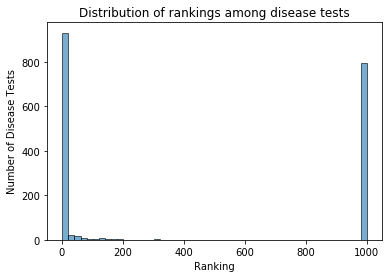

In [70]:
#histogram of rankings for orphanet disease data (each disease run once)
plt.hist(compiled_ranks, bins=50, alpha = 0.6, ec = "black")
plt.xlabel("Ranking")
plt.ylabel("Number of Disease Tests")
plt.title("Distribution of rankings among disease tests")
plt.show()

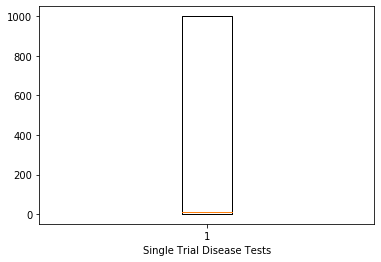

In [76]:
plt.boxplot(compiled_ranks)
plt.xlabel("Single Trial Disease Tests")
plt.show()

In [ ]:
#orphanet run of tests
#need to match diseases to orphanet ids
#use orphanet script 

In [92]:
import rank_phenotypes2

In [93]:
zebra = rank_phenotypes2.ZebraRank('weights_disease_S_ORDO_ORPHANET.json','weights_phenotype_S_ORDO_ORPHANET.json')

In [94]:
#separate get rank function for orphanet
def get_rank2(phen_dict, disease_id):
    phenos = generate_patient(phen_dict)
    rank_list = zebra.rank_phenotypes_weighted_tfidf(phenos)
    dz_ranks = []
    for entry in rank_list:
        dz_ranks.append(entry[1]["id"])
    if disease_id in dz_ranks: 
        rank = dz_ranks.index(disease_id) + 1
    else:
        rank = 1000
    return rank

In [95]:
compiled_ranks2 = []
for dz in dz_list:
    #first see if there is a matching gard ID
    #get rid of the types (makes it less specific)
    dis_name = dz.upper()
    
    #not using the code below because these are orphanet names, so no need to edit
    #comma = dis_name.find(",")
    #if comma != -1:
        #dis_name = dis_name[:comma]
    
    #changing this version for orphanet
    q = """match (m:S_ORDO_ORPHANET)-[:PAYLOAD]-(d:DATA) where any(x in m.N_Name where x =~ {dis_name}) RETURN d.notation"""
    d = graph.run(q, dis_name=dis_name).to_series()
    
    #if there is a matching ID, go through with the test
    if len(d) != 0:
        ordo_id = d[:1][0]
        #get the matching rows
        rows = prevalences.loc[prevalences['Disease_Name'] == dz]
        #get phenotype dictionary from rows
        dz_dict = get_dict(rows)
        #run test (creates patient from dictionary, returns ranking, add to ranks)
        compiled_ranks2.append(get_rank2(dz_dict, ordo_id))
        print(f"{dz} rank added!\n")
    else: 
        print("did not get ORDO match\n")

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000272', 'HP:0000316', 'HP:0000369', 'HP:0000470', 'HP:0000767', 'HP:0001274', 'HP:0001373', 'HP:0002758', 'HP:0002857', 'HP:0005930', 'HP:0006101', 'HP:0030084']
Multiple epiphyseal dysplasia, Al-Gazali type rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0001249', 'HP:0001250', 'HP:0001257', 'HP:0001274', 'HP:0001347', 'HP:0001355', 'HP:0001508', 'HP:0002007', 'HP:0002017', 'HP:0002353', 'HP:0002360', 'HP:0007256', 'HP:0100729', 'HP:0000496', 'HP:0000508', 'HP:0000651', 'HP:0000712', 'HP:0001260', 'HP:0001337', 'HP:0002357', 'HP:0002445', 'HP:0010628', 'HP:0100247']
Alexander disease rank added!

ranking diseases for phenotypes
...['HP:0000158', 'HP:0000280', 'HP:0000365', 'HP:0000518', 'HP:0001263', 'HP:0001744', 'HP:0002240', 'HP:0002652', 'HP:0002750', 'HP:0004493', 'HP:0005280', 'HP:0005978', 'HP:0007957', 'HP:0008821', 'HP:0000023', 'HP:0000212', 'HP:0000400', 'HP:0000470', 'HP:0000708', 'HP:0001252', 'HP:

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000269', 'HP:0000364', 'HP:0000505', 'HP:0001387', 'HP:0001646', 'HP:0001999', 'HP:0002564', 'HP:0003307', 'HP:0003312', 'HP:0004322', 'HP:0004493', 'HP:0007957', 'HP:0008818', 'HP:0008821', 'HP:0100543']
Mucolipidosis type III rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0012531', 'HP:0001287', 'HP:0001348', 'HP:0001945', 'HP:0003202', 'HP:0003326', 'HP:0003546', 'HP:0004302', 'HP:0009004', 'HP:0010547', 'HP:0012378', 'HP:0012486', 'HP:0025439', 'HP:0031469', 'HP:0040131', 'HP:0002374', 'HP:0002487', 'HP:0002590', 'HP:0004887', 'HP:0006824']
Poliomyelitis rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000293', 'HP:0000365', 'HP:0000618', 'HP:0001251', 'HP:0001508', 'HP:0001635', 'HP:0002205', 'HP:0002333', 'HP:0002652', 'HP:0002808', 'HP:0004343', 'HP:0007272', 'HP:0010729', 'HP:0100022']
Sandhoff disease rank added!

ranking diseases for phenotypes
...['HP:0000112', 'HP:0000217', 'HP:000

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000093', 'HP:0000100', 'HP:0000112', 'HP:0000179', 'HP:0000280', 'HP:0000365', 'HP:0000524', 'HP:0000790', 'HP:0000823', 'HP:0000962', 'HP:0000966', 'HP:0001014', 'HP:0001131', 'HP:0001369', 'HP:0001482', 'HP:0001635', 'HP:0001646', 'HP:0001653', 'HP:0001678', 'HP:0001681', 'HP:0001903', 'HP:0001945', 'HP:0002017', 'HP:0002024', 'HP:0002039', 'HP:0002097', 'HP:0002321', 'HP:0002326', 'HP:0002376', 'HP:0002829', 'HP:0003119', 'HP:0003326', 'HP:0007957', 'HP:0011710', 'HP:0100543', 'HP:0100579', 'HP:0100585', 'HP:0100820']
Fabry disease rank added!

ranking diseases for phenotypes
...['HP:0002376', 'HP:0002384', 'HP:0010818', 'HP:0012018']
Hyperekplexia-epilepsy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000253', 'HP:0000733', 'HP:0001263', 'HP:0001288', 'HP:0001344', 'HP:0002376', 'HP:0002793', 'HP:0012171', 'HP:0025430', 'HP:0002067', 'HP:0002353', 'HP:0002355', 'HP:0030217']
Rett syndrome rank added!

ranking d

ranking diseases for phenotypes
...['HP:0000100', 'HP:0000246', 'HP:0000421', 'HP:0001288', 'HP:0001369', 'HP:0001482', 'HP:0001633', 'HP:0002017', 'HP:0002019', 'HP:0002039', 'HP:0002072', 'HP:0002093', 'HP:0002103', 'HP:0002829', 'HP:0010522', 'HP:0011675', 'HP:0012733', 'HP:0012819', 'HP:0100584', 'HP:0100749', 'HP:0100776']
Rheumatic fever rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000789', 'HP:0004322', 'HP:0011398', 'HP:0000046', 'HP:0000059', 'HP:0000064', 'HP:0000486', 'HP:0000704', 'HP:0000708', 'HP:0000750', 'HP:0000786', 'HP:0000824', 'HP:0000939', 'HP:0000969', 'HP:0001055', 'HP:0001265', 'HP:0001558', 'HP:0001612', 'HP:0001999', 'HP:0002033', 'HP:0002205', 'HP:0002591', 'HP:0002659', 'HP:0002870', 'HP:0005599', 'HP:0006889', 'HP:0007018', 'HP:0010829', 'HP:0011734', 'HP:0012650', 'HP:0030339', 'HP:0002500', 'HP:0007874', 'HP:0011470', 'HP:0000826']
Prader-Willi syndrome rank added!

ranking diseases for phenotypes
...['HP:0000162', 'HP:0000246', 'H

ranking diseases for phenotypes
...['HP:0000678', 'HP:0000767', 'HP:0000822', 'HP:0000939', 'HP:0001166', 'HP:0001249', 'HP:0001387', 'HP:0001519', 'HP:0002039', 'HP:0002170', 'HP:0002204', 'HP:0002209', 'HP:0002239', 'HP:0002240', 'HP:0002650', 'HP:0002757', 'HP:0002808', 'HP:0002857', 'HP:0004337', 'HP:0004936']
Classic homocystinuria rank added!

ranking diseases for phenotypes
...['HP:0000926', 'HP:0002867', 'HP:0003028', 'HP:0003468', 'HP:0005193']
Spondyloepiphyseal dysplasia tarda, Kohn type rank added!

ranking diseases for phenotypes
...['HP:0000855', 'HP:0000998', 'HP:0003162', 'HP:0003758', 'HP:0008846', 'HP:0008897', 'HP:0011998', 'HP:0000065', 'HP:0000842', 'HP:0000956', 'HP:0001508', 'HP:0002219', 'HP:0003202', 'HP:0003247', 'HP:0003270', 'HP:0004405', 'HP:0008665', 'HP:0000121', 'HP:0000252', 'HP:0002035', 'HP:0002150', 'HP:0025024']
Leprechaunism rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000239', 'HP:0000737', 'HP:0000774', 'HP:0000944', 'HP:00

ranking diseases for phenotypes
...['HP:0000076', 'HP:0000083', 'HP:0000143', 'HP:0000384', 'HP:0000396', 'HP:0000518', 'HP:0000823', 'HP:0001177', 'HP:0001482', 'HP:0001545', 'HP:0001760', 'HP:0001763', 'HP:0001770', 'HP:0001863', 'HP:0002019', 'HP:0002023', 'HP:0004209', 'HP:0008551', 'HP:0008572', 'HP:0100559']
Townes-Brocks syndrome rank added!

ranking diseases for phenotypes
...['HP:0000303', 'HP:0000365', 'HP:0000431', 'HP:0000478', 'HP:0000504', 'HP:0000508', 'HP:0000574', 'HP:0001100', 'HP:0002211', 'HP:0002216', 'HP:0002226', 'HP:0002227', 'HP:0002251', 'HP:0003196', 'HP:0005599', 'HP:0010804', 'HP:0011364']
Waardenburg syndrome type 1 rank added!

ranking diseases for phenotypes
...['HP:0001288', 'HP:0001315', 'HP:0001522', 'HP:0002093', 'HP:0002486', 'HP:0003236', 'HP:0003326', 'HP:0003457', 'HP:0003752', 'HP:0007215', 'HP:0100021']
Hyperkalemic periodic paralysis rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000160', 'HP:0000175', 'HP:0000205', 'HP:00

ranking diseases for phenotypes
...['HP:0001892', 'HP:0003125', 'HP:0003645', 'HP:0000225', 'HP:0002829', 'HP:0000790', 'HP:0001376', 'HP:0002239', 'HP:0100769']
Moderately severe hemophilia A rank added!

ranking diseases for phenotypes
...['HP:0000053', 'HP:0000364', 'HP:0000826', 'HP:0000843', 'HP:0002652', 'HP:0002653', 'HP:0002757', 'HP:0004349', 'HP:0007565']
McCune-Albright syndrome rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000174', 'HP:0000252', 'HP:0000269', 'HP:0000767', 'HP:0000774', 'HP:0000987', 'HP:0001072', 'HP:0001250', 'HP:0001257', 'HP:0001511', 'HP:0001537', 'HP:0002017', 'HP:0002024', 'HP:0002045', 'HP:0002170', 'HP:0002224', 'HP:0002376', 'HP:0002617', 'HP:0002645', 'HP:0005293', 'HP:0005599', 'HP:0005692', 'HP:0006579', 'HP:0007420', 'HP:0008070', 'HP:0008872', 'HP:0010318', 'HP:0012378', 'HP:0100545', 'HP:0100777', 'HP:0100790']
Menkes disease rank added!

ranking diseases for phenotypes
...['HP:0000772', 'HP:0000774', 'HP:0001156', 'HP:

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000059', 'HP:0000076', 'HP:0000083', 'HP:0000218', 'HP:0000233', 'HP:0000248', 'HP:0000252', 'HP:0000294', 'HP:0000343', 'HP:0000347', 'HP:0000368', 'HP:0000405', 'HP:0000463', 'HP:0000470', 'HP:0000486', 'HP:0000574', 'HP:0000664', 'HP:0000667', 'HP:0000684', 'HP:0000687', 'HP:0000722', 'HP:0001249', 'HP:0000028', 'HP:0000047', 'HP:0000413', 'HP:0000508', 'HP:0000527', 'HP:0000739', 'HP:0001276', 'HP:0001508', 'HP:0001770', 'HP:0002020', 'HP:0002119', 'HP:0002167', 'HP:0002230', 'HP:0002360', 'HP:0002553', 'HP:0002564', 'HP:0002714', 'HP:0002750', 'HP:0003196', 'HP:0004322', 'HP:0007018', 'HP:0007598', 'HP:0007665', 'HP:0008850', 'HP:0009623', 'HP:0009830', 'HP:0010034', 'HP:0010300', 'HP:0010864', 'HP:0012165', 'HP:0200055']
Cornelia de Lange syndrome rank added!

ranking diseases for phenotypes
...['HP:0000453', 'HP:0000463', 'HP:0000528', 'HP:0000568', 'HP:0000582', 'HP:0000601', 'HP:0000819', 'HP:0001250', 'HP:0001252', 'HP:00

ranking diseases for phenotypes
...['HP:0000322', 'HP:0000411', 'HP:0000668', 'HP:0000750', 'HP:0001156', 'HP:0001249', 'HP:0001263', 'HP:0004322', 'HP:0009738', 'HP:0000175', 'HP:0000248', 'HP:0000252', 'HP:0000286', 'HP:0000347', 'HP:0000692', 'HP:0000822', 'HP:0002162', 'HP:0006610', 'HP:0100625', 'HP:0002564']
Monosomy 18p rank added!

ranking diseases for phenotypes
...['HP:0000478', 'HP:0000504', 'HP:0000648', 'HP:0001249', 'HP:0001250', 'HP:0002645', 'HP:0002757', 'HP:0011344']
Osteogenesis imperfecta-retinopathy-seizures-intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000368', 'HP:0000518', 'HP:0000592', 'HP:0000772', 'HP:0001511', 'HP:0002119', 'HP:0002757', 'HP:0002983', 'HP:0004383', 'HP:0008873']
Congenital osteogenesis imperfecta-microcephaly-cataracts syndrome rank added!

ranking diseases for phenotypes
...['HP:0011923', 'HP:0000114', 'HP:0000407', 'HP:0000508', 'HP:0000543', 'HP:0000639', 'HP:0000817', 'HP:0001138', '

ranking diseases for phenotypes
...['HP:0000069', 'HP:0000248', 'HP:0000337', 'HP:0000431', 'HP:0000463', 'HP:0000482', 'HP:0000490', 'HP:0000545', 'HP:0000582', 'HP:0000664', 'HP:0000679', 'HP:0000680', 'HP:0000733', 'HP:0000739', 'HP:0000750', 'HP:0001156', 'HP:0001249', 'HP:0001263', 'HP:0001265', 'HP:0001513', 'HP:0001531', 'HP:0001763', 'HP:0001770', 'HP:0002007', 'HP:0002019', 'HP:0002020', 'HP:0002155', 'HP:0002167', 'HP:0002353', 'HP:0002360', 'HP:0002650', 'HP:0004209', 'HP:0004322', 'HP:0005280', 'HP:0005607', 'HP:0007016', 'HP:0007018', 'HP:0007328', 'HP:0008872', 'HP:0010804', 'HP:0011800', 'HP:0100716', 'HP:0100729']
Smith-Magenis syndrome rank added!

ranking diseases for phenotypes
...['HP:0000280', 'HP:0000407', 'HP:0000505', 'HP:0000518', 'HP:0000639', 'HP:0000771', 'HP:0000842', 'HP:0000956', 'HP:0000958', 'HP:0001513', 'HP:0005978', 'HP:0007703', 'HP:0008734']
Retinitis pigmentosa-intellectual disability-deafness-hypogonadism syndrome rank added!

ranking diseases fo

ranking diseases for phenotypes
...['HP:0000478', 'HP:0000488', 'HP:0000504', 'HP:0000512', 'HP:0000649', 'HP:0001250', 'HP:0001251', 'HP:0001336', 'HP:0002059', 'HP:0002376', 'HP:0009023']
Late infantile neuronal ceroid lipofuscinosis rank added!

ranking diseases for phenotypes
...['HP:0000218', 'HP:0000431', 'HP:0000465', 'HP:0000470', 'HP:0001387', 'HP:0002650', 'HP:0003049', 'HP:0003272', 'HP:0004322', 'HP:0006501', 'HP:0007598', 'HP:0008368', 'HP:0100830']
Sheldon-Hall syndrome rank added!

ranking diseases for phenotypes
...['HP:0000347', 'HP:0000368', 'HP:0000378', 'HP:0000494', 'HP:0000625', 'HP:0002558', 'HP:0002564', 'HP:0002984', 'HP:0003022', 'HP:0006101', 'HP:0007651', 'HP:0008551']
Postaxial acrofacial dysostosis rank added!

ranking diseases for phenotypes
...['HP:0000069', 'HP:0000147', 'HP:0000286', 'HP:0000368', 'HP:0000413', 'HP:0000494', 'HP:0001156', 'HP:0001176', 'HP:0001256', 'HP:0001537', 'HP:0001629', 'HP:0002000', 'HP:0002750', 'HP:0004467', 'HP:0007598', 'HP

ranking diseases for phenotypes
...['HP:0000238', 'HP:0000256', 'HP:0002084', 'HP:0002415']
Frontal encephalocele rank added!

ranking diseases for phenotypes
...['HP:0001511', 'HP:0001541', 'HP:0001789', 'HP:0001873', 'HP:0001903']
Fetal parvovirus syndrome rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000407', 'HP:0000505', 'HP:0000508', 'HP:0000512', 'HP:0000649', 'HP:0000708', 'HP:0000762', 'HP:0001250', 'HP:0001251', 'HP:0001265', 'HP:0002119', 'HP:0002194', 'HP:0002514', 'HP:0003236', 'HP:0003355', 'HP:0004322', 'HP:0004326', 'HP:0006887', 'HP:0012120']
Mitochondrial DNA depletion syndrome, encephalomyopathic form with methylmalonic aciduria rank added!

ranking diseases for phenotypes
...['HP:0001622', 'HP:0001631', 'HP:0001643', 'HP:0002093', 'HP:0002564', 'HP:0005110', 'HP:0010316', 'HP:0011575', 'HP:0011675', 'HP:0012378', 'HP:0100749']
Ebstein malformation rank added!

ranking diseases for phenotypes
...['HP:0001288', 'HP:0100022']
Dopa-responsive dysto

ranking diseases for phenotypes
...['HP:0000478', 'HP:0000518', 'HP:0000639', 'HP:0000648', 'HP:0000504', 'HP:0007440']
Foveal hypoplasia-presenile cataract syndrome rank added!

ranking diseases for phenotypes
...['HP:0002589']
Multiple intestinal atresia rank added!

ranking diseases for phenotypes
...['HP:0000076', 'HP:0000174', 'HP:0000252', 'HP:0000368', 'HP:0000411', 'HP:0000574', 'HP:0001249', 'HP:0001373', 'HP:0001582', 'HP:0001883', 'HP:0002002', 'HP:0002209', 'HP:0002653', 'HP:0002750', 'HP:0004322', 'HP:0005039', 'HP:0005743', 'HP:0010230', 'HP:0100777']
Trichorhinophalangeal syndrome type 2 rank added!

ranking diseases for phenotypes
...['HP:0010785', 'HP:0030338', 'HP:0002027', 'HP:0005107', 'HP:0012288', 'HP:0031500', 'HP:0045026']
Polyembryoma rank added!

ranking diseases for phenotypes
...['HP:0000944', 'HP:0001156', 'HP:0001163', 'HP:0001385', 'HP:0001511', 'HP:0002644', 'HP:0002650', 'HP:0002652', 'HP:0003312', 'HP:0004209', 'HP:0004349', 'HP:0007957']
Larsen-like o

ranking diseases for phenotypes
...['HP:0000600', 'HP:0000762', 'HP:0001251', 'HP:0001288', 'HP:0001315', 'HP:0001601', 'HP:0001608', 'HP:0002650', 'HP:0002808', 'HP:0003457', 'HP:0003470', 'HP:0007328']
Charcot-Marie-Tooth disease/Hereditary motor and sensory neuropathy rank added!

ranking diseases for phenotypes
...['HP:0000639', 'HP:0000657', 'HP:0001249', 'HP:0001250', 'HP:0001251', 'HP:0001252', 'HP:0001260', 'HP:0001263', 'HP:0001288', 'HP:0001760', 'HP:0001789', 'HP:0001999', 'HP:0002240', 'HP:0004349', 'HP:0007256', 'HP:0010318', 'HP:0200042']
Free sialic acid storage disease rank added!

ranking diseases for phenotypes
...['HP:0002808', 'HP:0003312']
Familial Scheuermann disease rank added!

ranking diseases for phenotypes
...['HP:0000486', 'HP:0001250', 'HP:0001257', 'HP:0001263', 'HP:0002353', 'HP:0002510', 'HP:0007370']
Schizencephaly rank added!

ranking diseases for phenotypes
...['HP:0000651', 'HP:0001251', 'HP:0001288', 'HP:0001881', 'HP:0001928', 'HP:0002321', 'HP:000

ranking diseases for phenotypes
...['HP:0000716', 'HP:0000741', 'HP:0000751', 'HP:0001337', 'HP:0001824', 'HP:0002071', 'HP:0002360', 'HP:0002615', 'HP:0007110']
Perry syndrome rank added!

ranking diseases for phenotypes
...['HP:0002960', 'HP:0003202', 'HP:0003236', 'HP:0003326', 'HP:0003701', 'HP:0003731', 'HP:0003805', 'HP:0004303', 'HP:0009071']
Inclusion body myositis rank added!

ranking diseases for phenotypes
...['HP:0000508', 'HP:0000651', 'HP:0001324', 'HP:0002014', 'HP:0002094', 'HP:0006597', 'HP:0100021']
Adult intestinal botulism rank added!

ranking diseases for phenotypes
...['HP:0000978', 'HP:0003125', 'HP:0000421', 'HP:0006298', 'HP:0011890', 'HP:0005261']
Symptomatic form of hemophilia A in female carriers rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000389', 'HP:0000518', 'HP:0000545', 'HP:0000772', 'HP:0000889', 'HP:0001250', 'HP:0001251', 'HP:0001276', 'HP:0001604', 'HP:0002024', 'HP:0002208', 'HP:0002230', 'HP:0002360', 'HP:0002376', 'HP:000

ranking diseases for phenotypes
...['HP:0000093', 'HP:0000979', 'HP:0001025', 'HP:0001053', 'HP:0001635', 'HP:0001697', 'HP:0001824', 'HP:0001880', 'HP:0001945', 'HP:0001970', 'HP:0002113', 'HP:0002633', 'HP:0002960', 'HP:0004936', 'HP:0007009', 'HP:0009830', 'HP:0012378', 'HP:0012649']
Eosinophilic granulomatosis with polyangiitis rank added!

ranking diseases for phenotypes
...['HP:0001879', 'HP:0002092', 'HP:0002099', 'HP:0002105', 'HP:0002715', 'HP:0012735']
Allergic bronchopulmonary aspergillosis rank added!

ranking diseases for phenotypes
...['HP:0000478', 'HP:0000651', 'HP:0000708', 'HP:0001257', 'HP:0001276', 'HP:0001608', 'HP:0002093', 'HP:0002273', 'HP:0002445', 'HP:0003781', 'HP:0011968', 'HP:0100021']
Locked-in syndrome rank added!

ranking diseases for phenotypes
...['HP:0001873', 'HP:0001945', 'HP:0002017', 'HP:0002152', 'HP:0002315', 'HP:0003326', 'HP:0008150', 'HP:0002098', 'HP:0002716', 'HP:0011705', 'HP:0012735', 'HP:0031197']
Leptospirosis rank added!

ranking disea

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000293', 'HP:0000308', 'HP:0000369', 'HP:0000400', 'HP:0000426', 'HP:0000486', 'HP:0000729', 'HP:0002353', 'HP:0002591', 'HP:0004279']
6q16 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0005235', 'HP:0011968', 'HP:0025015', 'HP:0005245', 'HP:0001508']
Atresia of small intestine rank added!

ranking diseases for phenotypes
...['HP:0000572', 'HP:0000618', 'HP:0001166', 'HP:0002650', 'HP:0000486', 'HP:0000541', 'HP:0000565', 'HP:0001132', 'HP:0007703', 'HP:0012376']
Blindness-scoliosis-arachnodactyly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000047', 'HP:0000054', 'HP:0000089', 'HP:0000104', 'HP:0000233', 'HP:0000238', 'HP:0000239', 'HP:0000248', 'HP:0000262', 'HP:0000272', 'HP:0000316', 'HP:0000337', 'HP:0000343', 'HP:0000348', 'HP:0000369', 'HP:0000463', 'HP:0000768', 'HP:0001250', 'HP:0001285', 'HP:0001513', 'HP:0001601', 'HP:0001770', 'HP:0002000', 'HP:0002059', 'HP:0002308', 'HP:

ranking diseases for phenotypes
...['HP:0006292', 'HP:0000175', 'HP:0000750', 'HP:0002033', 'HP:0009088', 'HP:0100334', 'HP:0004395']
Cleft lip/palate rank added!

ranking diseases for phenotypes
...['HP:0012517', 'HP:0000166', 'HP:0000230']
Acatalasemia rank added!

ranking diseases for phenotypes
...['HP:0001998', 'HP:0008163', 'HP:0011735', 'HP:0002615', 'HP:0002902', 'HP:0012378', 'HP:0002173', 'HP:0012115']
Congenital isolated ACTH deficiency rank added!

ranking diseases for phenotypes
...['HP:0008220', 'HP:0011735', 'HP:0011748', 'HP:0001254', 'HP:0001324', 'HP:0001508', 'HP:0001824', 'HP:0002014', 'HP:0002017', 'HP:0002019', 'HP:0002027', 'HP:0002039', 'HP:0002615', 'HP:0002920', 'HP:0002960', 'HP:0012378', 'HP:0000872', 'HP:0001587', 'HP:0001897', 'HP:0001972', 'HP:0002149', 'HP:0011134', 'HP:0001943', 'HP:0012115', 'HP:0002893']
Late-onset isolated ACTH deficiency rank added!

ranking diseases for phenotypes
...['HP:0000311', 'HP:0000716', 'HP:0000787', 'HP:0000819', 'HP:0000

ranking diseases for phenotypes
...['HP:0001744', 'HP:0001945', 'HP:0002027']
Budd-Chiari syndrome rank added!

ranking diseases for phenotypes
...['HP:0000952', 'HP:0001251', 'HP:0001263', 'HP:0001288', 'HP:0001332', 'HP:0001618', 'HP:0001744', 'HP:0002240', 'HP:0002376', 'HP:0007256', 'HP:0100543']
Niemann-Pick disease type C rank added!

ranking diseases for phenotypes
...['HP:0001824', 'HP:0002027', 'HP:0002664', 'HP:0002667']
Nephroblastoma rank added!

ranking diseases for phenotypes
...['HP:0001376', 'HP:0001386', 'HP:0001387', 'HP:0002815', 'HP:0002829', 'HP:0001377', 'HP:0003184', 'HP:0006376', 'HP:0011843']
Osteochondritis dissecans rank added!

ranking diseases for phenotypes
...['HP:0001945', 'HP:0002088']
Tuberculosis rank added!

ranking diseases for phenotypes
...['HP:0000217', 'HP:0000651', 'HP:0001260', 'HP:0002015', 'HP:0002017', 'HP:0002019', 'HP:0002027', 'HP:0002093', 'HP:0006597', 'HP:0006824', 'HP:0010547', 'HP:0011499', 'HP:0011675', 'HP:0100021', 'HP:0012378']


Simpson-Golabi-Behmel syndrome rank added!

ranking diseases for phenotypes
...['HP:0000822', 'HP:0011739', 'HP:0040084', 'HP:0001959']
Familial hyperaldosteronism type I rank added!

ranking diseases for phenotypes
...['HP:0000157', 'HP:0000179', 'HP:0000492', 'HP:0000819', 'HP:0000822', 'HP:0000958', 'HP:0000989', 'HP:0002014', 'HP:0002027', 'HP:0002615', 'HP:0002650', 'HP:0002666', 'HP:0002716', 'HP:0002808', 'HP:0002865', 'HP:0003072', 'HP:0003198', 'HP:0003307', 'HP:0004370', 'HP:0006443', 'HP:0007565', 'HP:0008221', 'HP:0010741', 'HP:0100631', 'HP:0100735']
Multiple endocrine neoplasia type 2 rank added!

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000077', 'HP:0000083', 'HP:0001250', 'HP:0001324', 'HP:0001638', 'HP:0002240', 'HP:0002383', 'HP:0002910', 'HP:0003198', 'HP:0003326', 'HP:0010964', 'HP:0011675', 'HP:0012071']
Carnitine palmitoyltransferase II deficiency rank added!

ranking diseases for phenotypes
...['HP:0000010', 'HP:0000028', 'HP:0000062', 'HP:0000077',

ranking diseases for phenotypes
...['HP:0002084', 'HP:0004322']
Distal monosomy 13q rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000286', 'HP:0000316', 'HP:0000411', 'HP:0000426', 'HP:0000431', 'HP:0000508', 'HP:0000518', 'HP:0000612', 'HP:0001249', 'HP:0004322', 'HP:0007477']
Monosomy 13q14 rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000079', 'HP:0000235', 'HP:0000286', 'HP:0000316', 'HP:0000343', 'HP:0000431', 'HP:0000463', 'HP:0000470', 'HP:0000774', 'HP:0001155', 'HP:0001252', 'HP:0001274', 'HP:0001387', 'HP:0006610', 'HP:0008736']
3q13 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000343', 'HP:0000347', 'HP:0000368', 'HP:0000463', 'HP:0000470', 'HP:0000506', 'HP:0000508', 'HP:0001162', 'HP:0001252', 'HP:0001257', 'HP:0002714', 'HP:0004322', 'HP:0006695', 'HP:0100543']
Distal monosomy 3p rank added!

ranking diseases for phenotypes
...['HP:0000044', 'HP:0000144', 'HP:0000147', 'HP:0000545', 

ranking diseases for phenotypes
...['HP:0000952', 'HP:0001396', 'HP:0001508', 'HP:0001744', 'HP:0001928', 'HP:0002024', 'HP:0002240', 'HP:0002750', 'HP:0004322', 'HP:0004349', 'HP:0100543']
Progressive familial intrahepatic cholestasis rank added!

ranking diseases for phenotypes
...['HP:0001171', 'HP:0002817']
Ring chromosome 4 syndrome rank added!

ranking diseases for phenotypes
...['HP:0001263', 'HP:0001510', 'HP:0001999', 'HP:0007477', 'HP:0030084', 'HP:0000821', 'HP:0001159']
Ring chromosome 12 syndrome rank added!

ranking diseases for phenotypes
...['HP:0000233', 'HP:0000316', 'HP:0000343', 'HP:0000347', 'HP:0000431', 'HP:0000494', 'HP:0000568', 'HP:0000767', 'HP:0001182', 'HP:0001249', 'HP:0001250', 'HP:0001511', 'HP:0001852', 'HP:0002007', 'HP:0002251', 'HP:0002901', 'HP:0004326', 'HP:0006610', 'HP:0008678', 'HP:0009748']
Ring chromosome 10 syndrome rank added!

ranking diseases for phenotypes
...['HP:0000271', 'HP:0000988', 'HP:0001166', 'HP:0001324', 'HP:0001387', 'HP:00017

ranking diseases for phenotypes
...['HP:0000202', 'HP:0000218', 'HP:0000322', 'HP:0000368', 'HP:0000768', 'HP:0000813', 'HP:0000889', 'HP:0000912', 'HP:0001171', 'HP:0001562', 'HP:0001839', 'HP:0002984', 'HP:0003022', 'HP:0003316', 'HP:0003762', 'HP:0004408', 'HP:0006381', 'HP:0008678']
Acro-renal-mandibular syndrome rank added!

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000256', 'HP:0000277', 'HP:0000280', 'HP:0000316', 'HP:0000343', 'HP:0000347', 'HP:0000463', 'HP:0000470', 'HP:0000494', 'HP:0000574', 'HP:0000612', 'HP:0000704', 'HP:0000929', 'HP:0000939', 'HP:0000958', 'HP:0001156', 'HP:0001231', 'HP:0001831', 'HP:0001999', 'HP:0002230', 'HP:0002240', 'HP:0002645', 'HP:0002650', 'HP:0002653', 'HP:0002688', 'HP:0002797', 'HP:0004322', 'HP:0004331', 'HP:0004586', 'HP:0005692', 'HP:0006487', 'HP:0009882', 'HP:0010807', 'HP:0100790']
Acroosteolysis dominant type rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000190', 'HP:0000668', 'HP:0000698', 'HP:0001

ranking diseases for phenotypes
...['HP:0000944', 'HP:0001387', 'HP:0002997', 'HP:0004039', 'HP:0004322', 'HP:0005930', 'HP:0006487', 'HP:0006501']
Metaphyseal anadysplasia rank added!

ranking diseases for phenotypes
...['HP:0000457', 'HP:0000776', 'HP:0001004', 'HP:0001543', 'HP:0001561', 'HP:0001883', 'HP:0002103', 'HP:0002650', 'HP:0002827', 'HP:0003019', 'HP:0004295', 'HP:0009465']
Arthrogryposis multiplex congenita rank added!

ranking diseases for phenotypes
...['HP:0000772', 'HP:0001647', 'HP:0001772', 'HP:0002093', 'HP:0006703', 'HP:0007598', 'HP:0009623', 'HP:0009778', 'HP:0010772', 'HP:0011039']
Lung agenesis-heart defect-thumb anomalies syndrome rank added!

ranking diseases for phenotypes
...['HP:0001171', 'HP:0003022', 'HP:0006501']
Ulnar hypoplasia-split foot syndrome rank added!

ranking diseases for phenotypes
...['HP:0001362', 'HP:0001888', 'HP:0003075', 'HP:0004209', 'HP:0004313', 'HP:0007598', 'HP:0011362']
Aplasia cutis congenita-intestinal lymphangiectasia syndrom

ranking diseases for phenotypes
...['HP:0000221', 'HP:0000232', 'HP:0000280', 'HP:0000414', 'HP:0001155', 'HP:0005692', 'HP:0010285', 'HP:0012471']
Hypertrichosis-acromegaloid facial appearance syndrome rank added!

ranking diseases for phenotypes
...['HP:0001541', 'HP:0001649', 'HP:0001903', 'HP:0002014', 'HP:0002017', 'HP:0002027', 'HP:0002113', 'HP:0002239', 'HP:0002315', 'HP:0002666', 'HP:0008256', 'HP:0012378', 'HP:0100243', 'HP:0100721', 'HP:0100723']
Carney triad rank added!

ranking diseases for phenotypes
...['HP:0010566', 'HP:0012500', 'HP:0200036']
Congenital panfollicular nevus rank added!

did not get ORDO match

ranking diseases for phenotypes
...['HP:0000112', 'HP:0000121', 'HP:0000682', 'HP:0000684', 'HP:0000705', 'HP:0006286', 'HP:0011073', 'HP:0100530', 'HP:0000083', 'HP:0012365']
Enamel-renal syndrome rank added!

ranking diseases for phenotypes
...['HP:0002069', 'HP:0010850', 'HP:0002371', 'HP:0004372', 'HP:0012462']
Perioral myoclonia with absences rank added!

ran

ranking diseases for phenotypes
...['HP:0000316', 'HP:0000457', 'HP:0000940', 'HP:0000944', 'HP:0001156', 'HP:0001249', 'HP:0001373', 'HP:0002007', 'HP:0002650', 'HP:0002673', 'HP:0002823', 'HP:0002970', 'HP:0002983', 'HP:0003510', 'HP:0005616', 'HP:0006059', 'HP:0006487', 'HP:0010579', 'HP:0011220']
Metaphyseal acroscyphodysplasia rank added!

ranking diseases for phenotypes
...['HP:0000347', 'HP:0000368', 'HP:0000414', 'HP:0000431', 'HP:0001252', 'HP:0002093', 'HP:0002564', 'HP:0011001']
Beemer-Ertbruggen syndrome rank added!

ranking diseases for phenotypes
...['HP:0000889', 'HP:0001163', 'HP:0001385', 'HP:0003042', 'HP:0004322', 'HP:0006501', 'HP:0009906', 'HP:0009907']
Auriculoosteodysplasia rank added!

ranking diseases for phenotypes
...['HP:0000218', 'HP:0001166', 'HP:0001371', 'HP:0001387', 'HP:0001519', 'HP:0001533', 'HP:0002575', 'HP:0002650', 'HP:0002803', 'HP:0002804', 'HP:0003011', 'HP:0008453', 'HP:0008544']
Congenital contractural arachnodactyly rank added!

ranking dis

ranking diseases for phenotypes
...['HP:0004755', 'HP:0001678', 'HP:0012735', 'HP:0001943']
Histiocytoid cardiomyopathy rank added!

ranking diseases for phenotypes
...['HP:0000218', 'HP:0000252', 'HP:0000325', 'HP:0000347', 'HP:0000368', 'HP:0000405', 'HP:0000407', 'HP:0000411', 'HP:0000426', 'HP:0000465', 'HP:0000494', 'HP:0004322', 'HP:0009794', 'HP:0010669', 'HP:0100840']
X-linked mandibulofacial dysostosis rank added!

ranking diseases for phenotypes
...['HP:0001252', 'HP:0001298', 'HP:0003324', 'HP:0007370']
Neurological conditions associated with aminoacylase 1 deficiency rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000268', 'HP:0000343', 'HP:0000347', 'HP:0000431', 'HP:0000470', 'HP:0000774', 'HP:0001288', 'HP:0001387', 'HP:0001531', 'HP:0009623', 'HP:0100490', 'HP:0100543']
Infantile-onset X-linked spinal muscular atrophy rank added!

ranking diseases for phenotypes
...['HP:0000140', 'HP:0000876', 'HP:0000789', 'HP:0002574']
Asherman syndrome rank added!

ranking diseases for phenotypes
...['HP:0000347', 'HP:0000926', 'HP:0001004', 'HP:0001156', 'HP:0001881', 'HP:0003312', 'HP:0006619', 'HP:0008890', 'HP:0008905', 'HP:0009106', 'HP:0011800', 'HP:0100569', 'HP:0100602']
Greenberg dysplasia rank added!

ranking diseases for phenotypes
...['HP:0001028', 'HP:0007466', 'HP:0100585', 'HP:0001635']
Rapidly involuting congenital hemangioma rank added!

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000272', 'HP:0000407', 'HP:0000457', 'HP:0000463', 'HP:0000926', 'HP:0000944', 'HP:0000951', 'HP:0001387', 'HP:0002808', 'HP:0002983', 'HP:0003312', 'HP:0005048', 'HP:0006532', 'HP:0011481']
Otospondylomegaepiphyseal dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000532', 'HP:0001139', 'HP:0007945', 'HP:0000375', 'HP:0000381', 'HP:0000824', 'HP:0000830', 'HP:0001251', 'HP:0001256', 'HP:0002066', 'HP:0002750', 'HP:0005109', 'HP:0007663', 'HP:0011448', 'HP:0030532', 'HP:0000822', 'HP:0003484']
Xq21 microdeletion s

ranking diseases for phenotypes
...['HP:0001770', 'HP:0004209', 'HP:0004279', 'HP:0004691', 'HP:0005048', 'HP:0006101', 'HP:0008362', 'HP:0009773', 'HP:0009843']
Mesoaxial synostotic syndactyly with phalangeal reduction rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000218', 'HP:0000221', 'HP:0000232', 'HP:0000252', 'HP:0000272', 'HP:0000322', 'HP:0000368', 'HP:0000692', 'HP:0001155', 'HP:0001249', 'HP:0002162', 'HP:0002650', 'HP:0004322', 'HP:0007477', 'HP:0007495', 'HP:0008872', 'HP:0011800']
Cataract-intellectual disability-hypogonadism syndrome rank added!

ranking diseases for phenotypes
...['HP:0001892', 'HP:0002573', 'HP:0012183', 'HP:0005505', 'HP:0007378', 'HP:0012198', 'HP:0100743', 'HP:0012114']
Hereditary mixed polyposis syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000486', 'HP:0000518', 'HP:0001249', 'HP:0002023', 'HP:0002857', 'HP:0008736']
Cataract-intellectual disability-anal atresia-urinary defects syndrome rank adde

ranking diseases for phenotypes
...['HP:0000112', 'HP:0000691', 'HP:0000790', 'HP:0001511', 'HP:0002983', 'HP:0002986', 'HP:0003031', 'HP:0003067', 'HP:0004322', 'HP:0006501', 'HP:0008845']
Dyschondrosteosis-nephritis syndrome rank added!

ranking diseases for phenotypes
...['HP:0000486', 'HP:0000518', 'HP:0001249', 'HP:0001251', 'HP:0001252', 'HP:0001288', 'HP:0001347']
Dysequilibrium syndrome rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000268', 'HP:0000276', 'HP:0000316', 'HP:0000369', 'HP:0000444', 'HP:0001156', 'HP:0001249', 'HP:0001263', 'HP:0001724', 'HP:0001763', 'HP:0001831', 'HP:0002970', 'HP:0007370']
Temtamy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000143', 'HP:0000160', 'HP:0000316', 'HP:0000358', 'HP:0000414', 'HP:0000463', 'HP:0000465', 'HP:0000470', 'HP:0000582', 'HP:0000637', 'HP:0001334', 'HP:0001629', 'HP:0002575', 'HP:0002714', 'HP:0002937', 'HP:0004602']
Thakker-Donnai syndrome rank added!

ranking diseases for phenotype

ranking diseases for phenotypes
...['HP:0000505', 'HP:0007957']
X-linked corneal dermoid rank added!

ranking diseases for phenotypes
...['HP:0030053', 'HP:0000160', 'HP:0000176', 'HP:0000316', 'HP:0000347', 'HP:0000369', 'HP:0000494', 'HP:0000506', 'HP:0000621', 'HP:0000883', 'HP:0000938', 'HP:0001196', 'HP:0001511', 'HP:0001558', 'HP:0001622', 'HP:0001643', 'HP:0002089', 'HP:0002597', 'HP:0002828', 'HP:0004331', 'HP:0004334', 'HP:0004492', 'HP:0005267', 'HP:0005595', 'HP:0006266', 'HP:0006645', 'HP:0006710', 'HP:0007543', 'HP:0007592', 'HP:0008070', 'HP:0009924', 'HP:0010219', 'HP:0010648', 'HP:0012478', 'HP:0012745', 'HP:0025354', 'HP:0040189', 'HP:0045075', 'HP:0200041', 'HP:0200102', 'HP:0000695']
Restrictive dermopathy rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000269', 'HP:0001257', 'HP:0001357', 'HP:0002120', 'HP:0006887', 'HP:0010864', 'HP:0011344']
Sporadic fetal brain disruption sequence rank added!

ranking diseases for phenotypes
...['HP:0000124', 

ranking diseases for phenotypes
...['HP:0000218', 'HP:0000437', 'HP:0000518', 'HP:0000601', 'HP:0000639', 'HP:0000648', 'HP:0001010', 'HP:0001249', 'HP:0001252', 'HP:0001263', 'HP:0001274', 'HP:0001321', 'HP:0001387', 'HP:0001522', 'HP:0001638', 'HP:0001947', 'HP:0002205', 'HP:0002353', 'HP:0002719', 'HP:0004322', 'HP:0005374', 'HP:0005999', 'HP:0007703']
Vici syndrome rank added!

ranking diseases for phenotypes
...['HP:0000828', 'HP:0040077']
Secondary hypoparathyroidism due to impaired parathormon secretion rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000347', 'HP:0000384', 'HP:0000411', 'HP:0001276', 'HP:0001510', 'HP:0001522', 'HP:0002020', 'HP:0002079', 'HP:0002119', 'HP:0002750', 'HP:0006532', 'HP:0010864', 'HP:0010978']
Intellectual disability-hypoplastic corpus callosum-preauricular tag syndrome rank added!

ranking diseases for phenotypes
...['HP:0001385', 'HP:0002644', 'HP:0002815', 'HP:0005930', 'HP:0006498']
Coxopodopatellar syndrome rank added!

ran

ranking diseases for phenotypes
...['HP:0000926', 'HP:0001249', 'HP:0002656', 'HP:0002812', 'HP:0002829', 'HP:0004322', 'HP:0010582']
Lowry-Wood syndrome rank added!

ranking diseases for phenotypes
...['HP:0000601', 'HP:0001643', 'HP:0002648', 'HP:0002970', 'HP:0003417', 'HP:0005716', 'HP:0100670']
Pacman dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000958', 'HP:0001508', 'HP:0002024', 'HP:0002093', 'HP:0003073', 'HP:0007381', 'HP:0008064']
Congenital lethal erythroderma rank added!

ranking diseases for phenotypes
...['HP:0000639', 'HP:0000958', 'HP:0000966', 'HP:0001025', 'HP:0001260', 'HP:0001265', 'HP:0002075', 'HP:0002167', 'HP:0003011', 'HP:0012733', 'HP:0200034']
Spinocerebellar ataxia type 34 rank added!

ranking diseases for phenotypes
...['HP:0000008', 'HP:0000028', 'HP:0000054', 'HP:0000073', 'HP:0000098', 'HP:0000126', 'HP:0000175', 'HP:0000238', 'HP:0000252', 'HP:0000365', 'HP:0000368', 'HP:0000464', 'HP:0001195', 'HP:0001629', 'HP:0001636', 'HP:0001669

ranking diseases for phenotypes
...['HP:0000505', 'HP:0000512', 'HP:0000551', 'HP:0000613', 'HP:0007703']
Progressive cone dystrophy rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000260', 'HP:0000365', 'HP:0000774', 'HP:0000926', 'HP:0000944', 'HP:0000946', 'HP:0000956', 'HP:0001156', 'HP:0001250', 'HP:0001252', 'HP:0001561', 'HP:0001582', 'HP:0002093', 'HP:0002187', 'HP:0002282', 'HP:0002652', 'HP:0002808', 'HP:0002980', 'HP:0002983', 'HP:0003097', 'HP:0003185', 'HP:0005280', 'HP:0006487', 'HP:0007392', 'HP:0008909', 'HP:0010880', 'HP:0012368', 'HP:0100781']
Thanatophoric dysplasia type 1 rank added!

ranking diseases for phenotypes
...['HP:0000405', 'HP:0000457', 'HP:0000774', 'HP:0000944', 'HP:0001249', 'HP:0001251', 'HP:0001252', 'HP:0002878', 'HP:0004322', 'HP:0009826']
Thoracic dysplasia-hydrocephalus syndrome rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000175', 'HP:0000347', 'HP:0000457', 'HP:0000592', 'HP:0000774', 'HP:0000944', 'HP

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000368', 'HP:0000414', 'HP:0001250', 'HP:0001263', 'HP:0001513', 'HP:0002002', 'HP:0002353']
Hernández-Aguirre Negrete syndrome rank added!

ranking diseases for phenotypes
...['HP:0000776', 'HP:0000782', 'HP:0001539', 'HP:0002089', 'HP:0002817', 'HP:0002823', 'HP:0004209', 'HP:0006495', 'HP:0006501', 'HP:0006507', 'HP:0100560']
Diaphragmatic defect-limb deficiency-skull defect syndrome rank added!

ranking diseases for phenotypes
...['HP:0000093', 'HP:0000256', 'HP:0000260', 'HP:0000316', 'HP:0000349', 'HP:0000407', 'HP:0000494', 'HP:0000545', 'HP:0000776', 'HP:0000813', 'HP:0001249', 'HP:0001250', 'HP:0001263', 'HP:0001537', 'HP:0001539', 'HP:0002566', 'HP:0003196', 'HP:0005280']
Donnai-Barrow syndrome rank added!

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000262', 'HP:0000316', 'HP:0000347', 'HP:0000465', 'HP:0000772', 'HP:0001511', 'HP:0002983', 'HP:0003196', 'HP:0004322', 'HP:0006101', 'HP:0008551', 'HP:0009738', 

ranking diseases for phenotypes
...['HP:0002076', 'HP:0002331', 'HP:0000508', 'HP:0000613', 'HP:0002183', 'HP:0009926', 'HP:0031284', 'HP:0031417', 'HP:0000819', 'HP:0011161', 'HP:0100540']
Paroxysmal hemicrania rank added!

ranking diseases for phenotypes
...['HP:0000093', 'HP:0000100', 'HP:0000112', 'HP:0000252', 'HP:0000400', 'HP:0001250', 'HP:0001263', 'HP:0001276', 'HP:0001511', 'HP:0002269', 'HP:0002410', 'HP:0005108', 'HP:0010978', 'HP:0100543', 'HP:0100720']
Galloway-Mowat syndrome rank added!

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000028', 'HP:0000175', 'HP:0000347', 'HP:0000494', 'HP:0000776', 'HP:0001511', 'HP:0001671', 'HP:0002564']
Genitopalatocardiac syndrome rank added!

ranking diseases for phenotypes
...['HP:0002072', 'HP:0000716', 'HP:0000726', 'HP:0000746', 'HP:0001260', 'HP:0002119', 'HP:0004305', 'HP:0000639', 'HP:0000750', 'HP:0001250', 'HP:0002067', 'HP:0002354', 'HP:0002359', 'HP:0006961', 'HP:0040201']
Huntington disease-like 1 rank added!

ran

ranking diseases for phenotypes
...['HP:0000169', 'HP:0000212']
Hereditary gingival fibromatosis rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000347', 'HP:0000368', 'HP:0000506', 'HP:0000830', 'HP:0001635', 'HP:0001723', 'HP:0001943', 'HP:0002564', 'HP:0008736', 'HP:0100543']
Endocardial fibroelastosis rank added!

ranking diseases for phenotypes
...['HP:0000340', 'HP:0000348', 'HP:0000483', 'HP:0000508', 'HP:0000982', 'HP:0001156', 'HP:0001166', 'HP:0001249', 'HP:0001257', 'HP:0001258', 'HP:0001348', 'HP:0002061', 'HP:0003189', 'HP:0010579', 'HP:0010620']
Paraplegia-intellectual disability-hyperkeratosis syndrome rank added!

ranking diseases for phenotypes
...['HP:0000492', 'HP:0000498', 'HP:0000499', 'HP:0000613', 'HP:0000653', 'HP:0001597', 'HP:0008069', 'HP:0100533']
FLOTCH syndrome rank added!

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000358', 'HP:0000430', 'HP:0000448', 'HP:0000470', 'HP:0000486', 'HP:0000490', 'HP:0000527', 'HP:0000889', 'HP

ranking diseases for phenotypes
...['HP:0000430', 'HP:0000470', 'HP:0000506', 'HP:0000677', 'HP:0000954', 'HP:0001566', 'HP:0001572', 'HP:0000028', 'HP:0000175', 'HP:0000252', 'HP:0000316', 'HP:0000325', 'HP:0002750', 'HP:0002948', 'HP:0004322', 'HP:0010720', 'HP:0012725', 'HP:0045017']
KBG syndrome rank added!

ranking diseases for phenotypes
...['HP:0000014', 'HP:0001257', 'HP:0001285', 'HP:0001324', 'HP:0001347', 'HP:0002064', 'HP:0002127', 'HP:0002193', 'HP:0003202', 'HP:0007256']
Juvenile primary lateral sclerosis rank added!

ranking diseases for phenotypes
...['HP:0000962', 'HP:0000982', 'HP:0001597', 'HP:0002665', 'HP:0003002', 'HP:0200043']
Isolated punctate palmoplantar keratoderma rank added!

ranking diseases for phenotypes
...['HP:0007435', 'HP:0008066']
Non-epidermolytic palmoplantar keratoderma rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000561', 'HP:0002223', 'HP:0003510']
Keratosis follicularis-dwarfism-cerebral atrophy syndrome rank added!

ran

ranking diseases for phenotypes
...['HP:0000126', 'HP:0100257', 'HP:0000340', 'HP:0000347', 'HP:0000474', 'HP:0002475', 'HP:0002944', 'HP:0006097', 'HP:0008589', 'HP:0008593']
Czeizel-Losonci syndrome rank added!

ranking diseases for phenotypes
...['HP:0000074', 'HP:0000076', 'HP:0000130', 'HP:0000795', 'HP:0000813', 'HP:0004209', 'HP:0005048', 'HP:0006110', 'HP:0007477', 'HP:0009623', 'HP:0009778', 'HP:0009882', 'HP:0010034', 'HP:0010105', 'HP:0010109', 'HP:0011937']
Hand-foot-genital syndrome rank added!

ranking diseases for phenotypes
...['HP:0001939', 'HP:0003236', 'HP:0003750', 'HP:0012379', 'HP:0410020']
Dimethylglycine dehydrogenase deficiency rank added!

ranking diseases for phenotypes
...['HP:0000995', 'HP:0001053', 'HP:0004322', 'HP:0007400', 'HP:0012733']
Hypo- and hypermelanotic cutaneous macules-retarded growth-intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000256', 'HP:0000337', 'HP:0000490', 'HP:0000664', 'HP:00012

ranking diseases for phenotypes
...['HP:0000098', 'HP:0000238', 'HP:0001166', 'HP:0001181', 'HP:0001519', 'HP:0002808', 'HP:0005692', 'HP:0001288', 'HP:0003834']
Hydrocephaly-tall stature-joint laxity syndrome rank added!

ranking diseases for phenotypes
...['HP:0000238', 'HP:0000912', 'HP:0000256', 'HP:0000316', 'HP:0000369', 'HP:0000414', 'HP:0000431', 'HP:0000448', 'HP:0000682', 'HP:0000708', 'HP:0000772', 'HP:0000992', 'HP:0001513', 'HP:0001852', 'HP:0003312', 'HP:0005280', 'HP:0000545']
Hydrocephalus-costovertebral dysplasia-Sprengel anomaly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000238', 'HP:0000278', 'HP:0000347', 'HP:0001162', 'HP:0001274', 'HP:0001331', 'HP:0001561', 'HP:0001622', 'HP:0000175', 'HP:0000368', 'HP:0000369', 'HP:0002086', 'HP:0004408', 'HP:0100333', 'HP:0002139']
Hydrolethalus rank added!

ranking diseases for phenotypes
...['HP:0000962', 'HP:0001019', 'HP:0001824', 'HP:0004396', 'HP:0007475', 'HP:0008064', 'HP:0008066', 'HP:0000992']
Auto

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000982']
Palmoplantar keratoderma-deafness syndrome rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000316', 'HP:0000413', 'HP:0008501', 'HP:0008551', 'HP:0000085', 'HP:0000405', 'HP:0001249', 'HP:0000456', 'HP:0011803']
Hypertelorism-microtia-facial clefting syndrome rank added!

ranking diseases for phenotypes
...['HP:0000036', 'HP:0000047', 'HP:0000049', 'HP:0000239', 'HP:0000248', 'HP:0000270', 'HP:0000316', 'HP:0000358', 'HP:0000369', 'HP:0000431', 'HP:0000457', 'HP:0001177', 'HP:0005469', 'HP:0000048', 'HP:0000343', 'HP:0000501', 'HP:0000508', 'HP:0000520', 'HP:0000625', 'HP:0010059', 'HP:0011304', 'HP:0002084']
Hypertelorism-hypospadias-polysyndactyly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000238', 'HP:0000651', 'HP:0002017', 'HP:0002315', 'HP:0002354', 'HP:0002516', 'HP:0000492', 'HP:0002922', 'HP:0030531', 'HP:0100543']
Papillary tumor of the pineal region rank added!

ranking di

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000021', 'HP:0001561', 'HP:0002017', 'HP:0002564', 'HP:0002566', 'HP:0003270', 'HP:0004388', 'HP:0011024', 'HP:0100771']
Megacystis-microcolon-intestinal hypoperistalsis syndrome rank added!

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000272', 'HP:0000347', 'HP:0000407', 'HP:0000483', 'HP:0000518', 'HP:0000646', 'HP:0002656', 'HP:0002857', 'HP:0003301', 'HP:0004322', 'HP:0005930', 'HP:0012368']
Autosomal recessive Stickler syndrome rank added!

ranking diseases for phenotypes
...['HP:0000316', 'HP:0000347', 'HP:0000411', 'HP:0000431', 'HP:0000494', 'HP:0001195', 'HP:0001561', 'HP:0001622', 'HP:0002007', 'HP:0002564', 'HP:0003022', 'HP:0003026', 'HP:0005280', 'HP:0006101', 'HP:0006492', 'HP:0010242']
Fibulo-ulnar hypoplasia-renal anomalies syndrome rank added!

ranking diseases for phenotypes
...['HP:0002089', 'HP:0000961', 'HP:0002104', 'HP:0002789', 'HP:0001651', 'HP:0040045']
Primary pulmonary hypoplasia rank added!



ranking diseases for phenotypes
...['HP:0000470', 'HP:0000496', 'HP:0000600', 'HP:0002691', 'HP:0003468', 'HP:0005758']
Primary basilar invagination rank added!

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000286', 'HP:0000288', 'HP:0000303', 'HP:0000369', 'HP:0000413', 'HP:0000426', 'HP:0000508', 'HP:0000767', 'HP:0001163', 'HP:0001199', 'HP:0001249', 'HP:0001511', 'HP:0002564', 'HP:0004322', 'HP:0008572', 'HP:0009811', 'HP:0009896', 'HP:0009912', 'HP:0010650', 'HP:0011220', 'HP:0011830']
Neurofaciodigitorenal syndrome rank added!

ranking diseases for phenotypes
...['HP:0001251', 'HP:0001257', 'HP:0001276', 'HP:0003552', 'HP:0100022', 'HP:0002381', 'HP:0010529']
Neuhauser-Eichner-Opitz syndrome rank added!

ranking diseases for phenotypes
...['HP:0000083', 'HP:0011344']
Lethal infantile mitochondrial myopathy rank added!

ranking diseases for phenotypes
...['HP:0007565']
Neurofibromatosis type 6 rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0003198', '

ranking diseases for phenotypes
...['HP:0001163', 'HP:0001167', 'HP:0012165', 'HP:0100257']
Postaxial tetramelic oligodactyly rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000486', 'HP:0001251', 'HP:0001347', 'HP:0002119', 'HP:0002120', 'HP:0002167']
Olivopontocerebellar atrophy-deafness syndrome rank added!

ranking diseases for phenotypes
...['HP:0000174', 'HP:0000463', 'HP:0000504', 'HP:0000518', 'HP:0000545', 'HP:0000639', 'HP:0000656', 'HP:0000963', 'HP:0001107', 'HP:0001139', 'HP:0001166', 'HP:0001249', 'HP:0001257', 'HP:0001347', 'HP:0001510', 'HP:0003196', 'HP:0005561', 'HP:0007957', 'HP:0008056', 'HP:0100022']
Oculocerebral hypopigmentation syndrome, Cross type rank added!

ranking diseases for phenotypes
...['HP:0000218', 'HP:0000365', 'HP:0000613', 'HP:0000639', 'HP:0001249', 'HP:0001250', 'HP:0001263', 'HP:0001276', 'HP:0001874', 'HP:0001931', 'HP:0002363', 'HP:0004322', 'HP:0007360', 'HP:0007513', 'HP:0007730', 'HP:0010662', 'HP:0010978', 'HP:0011364'

ranking diseases for phenotypes
...['HP:0000670', 'HP:0001874', 'HP:0002669', 'HP:0004209', 'HP:0004322', 'HP:0005518']
OSLAM syndrome rank added!

ranking diseases for phenotypes
...['HP:0001067', 'HP:0007470', 'HP:0100698', 'HP:0006751']
Neurofibroma rank added!

ranking diseases for phenotypes
...['HP:0000826', 'HP:0001270', 'HP:0001518', 'HP:0008897', 'HP:0008947', 'HP:0200055', 'HP:0000750', 'HP:0001622', 'HP:0004482', 'HP:0008872', 'HP:0011968', 'HP:0040288', 'HP:0005978', 'HP:0000238']
Temple syndrome rank added!

ranking diseases for phenotypes
...['HP:0000268', 'HP:0000400', 'HP:0000582', 'HP:0000940', 'HP:0001256', 'HP:0001371', 'HP:0001597', 'HP:0006380', 'HP:0008577', 'HP:0009738', 'HP:0009756', 'HP:0009906', 'HP:0011039']
Otoonychoperoneal syndrome rank added!

ranking diseases for phenotypes
...['HP:0000218', 'HP:0000293', 'HP:0000400', 'HP:0000405', 'HP:0000411', 'HP:0000413', 'HP:0000463', 'HP:0001249', 'HP:0001263', 'HP:0001276', 'HP:0001347', 'HP:0002167', 'HP:0002750

ranking diseases for phenotypes
...['HP:0000405', 'HP:0001256', 'HP:0005899', 'HP:0001388', 'HP:0001773', 'HP:0001964', 'HP:0002868', 'HP:0002970', 'HP:0003015', 'HP:0003016', 'HP:0003026', 'HP:0003085', 'HP:0004279', 'HP:0006413', 'HP:0006417', 'HP:0008110', 'HP:0008873', 'HP:0009760', 'HP:0100255', 'HP:0100864']
Metaphyseal dysostosis-intellectual disability-conductive deafness syndrome rank added!

ranking diseases for phenotypes
...['HP:0000347', 'HP:0000951', 'HP:0000963', 'HP:0001773', 'HP:0002213', 'HP:0002650', 'HP:0004322', 'HP:0005692', 'HP:0007392', 'HP:0007400', 'HP:0007495', 'HP:0008065', 'HP:0100578', 'HP:0200055']
Acrogeria rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000670', 'HP:0000944', 'HP:0001288', 'HP:0001385', 'HP:0002750', 'HP:0002970', 'HP:0003307', 'HP:0003498', 'HP:0004349', 'HP:0005871', 'HP:0006385', 'HP:0006409', 'HP:0006487', 'HP:0100255']
Metaphyseal chondrodysplasia, Spahr type rank added!

ranking diseases for phenotypes
...['HP:

Moynahan syndrome rank added!

ranking diseases for phenotypes
...['HP:0000112', 'HP:0000174', 'HP:0000408', 'HP:0000501', 'HP:0000509', 'HP:0000554', 'HP:0000988', 'HP:0001025', 'HP:0001369', 'HP:0001744', 'HP:0001769', 'HP:0002027', 'HP:0002240', 'HP:0002633', 'HP:0002829', 'HP:0003326', 'HP:0003565', 'HP:0006824', 'HP:0100534']
Muckle-Wells syndrome rank added!

ranking diseases for phenotypes
...['HP:0000519', 'HP:0000545', 'HP:0000648', 'HP:0001131', 'HP:0001251', 'HP:0002497', 'HP:0002503', 'HP:0003457', 'HP:0004374']
Spastic ataxia-corneal dystrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0001009', 'HP:0001249', 'HP:0002119', 'HP:0100659']
Moyamoya disease rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000340', 'HP:0000369', 'HP:0000581', 'HP:0001360', 'HP:0001376', 'HP:0001558', 'HP:0002103', 'HP:0002828', 'HP:0006703', 'HP:0007477', 'HP:0100490', 'HP:0100625']
Lethal intrauterine growth restriction-cortical malformation-congenital con

ranking diseases for phenotypes
...['HP:0000268', 'HP:0000307', 'HP:0000325', 'HP:0000337', 'HP:0000414', 'HP:0000470', 'HP:0000574', 'HP:0000883', 'HP:0000888', 'HP:0001511', 'HP:0002007', 'HP:0002808', 'HP:0003100', 'HP:0003173', 'HP:0003175', 'HP:0003691', 'HP:0004322', 'HP:0004570', 'HP:0008839', 'HP:0010306', 'HP:0011800']
3M syndrome rank added!

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000093', 'HP:0000822', 'HP:0002907', 'HP:0004322', 'HP:0100820']
Nail-patella-like renal disease rank added!

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000160', 'HP:0000175', 'HP:0000238', 'HP:0000369', 'HP:0000445', 'HP:0000528', 'HP:0001166', 'HP:0005280', 'HP:0008676', 'HP:0100490']
Trisomy 1q rank added!

ranking diseases for phenotypes
...['HP:0000122', 'HP:0000238', 'HP:0000286', 'HP:0000319', 'HP:0000337', 'HP:0000414', 'HP:0000445', 'HP:0000486', 'HP:0000960', 'HP:0001260', 'HP:0001263', 'HP:0001704', 'HP:0002650']
Distal 22q11.2 microduplication syndrome rank ad

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000046', 'HP:0000286', 'HP:0000316', 'HP:0000348', 'HP:0000358', 'HP:0000378', 'HP:0000384', 'HP:0000413', 'HP:0000430', 'HP:0000494', 'HP:0000508', 'HP:0000520', 'HP:0000528', 'HP:0000835', 'HP:0000864', 'HP:0000873', 'HP:0001252', 'HP:0001263', 'HP:0001274', 'HP:0001770', 'HP:0002714', 'HP:0004322', 'HP:0006101', 'HP:0010627', 'HP:0012521']
14q22q23 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000581', 'HP:0001249', 'HP:0001518', 'HP:0004322', 'HP:0000028', 'HP:0000322', 'HP:0000341', 'HP:0000545', 'HP:0000565', 'HP:0000639', 'HP:0000752', 'HP:0001182', 'HP:0001274', 'HP:0001508', 'HP:0002059', 'HP:0002162', 'HP:0002828', 'HP:0005280', 'HP:0007874', 'HP:0045025']
X-linked intellectual disability, Brooks type rank added!

ranking diseases for phenotypes
...['HP:0000708', 'HP:0100543']
Monoamine oxidase A deficiency rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000368', 'HP:0000

ranking diseases for phenotypes
...['HP:0003758', 'HP:0004322', 'HP:0008283', 'HP:0011998', 'HP:0012542', 'HP:0001007', 'HP:0001249', 'HP:0001263', 'HP:0003162', 'HP:0000040', 'HP:0000855', 'HP:0000956', 'HP:0000958', 'HP:0030088', 'HP:0030348', 'HP:0030796', 'HP:0031452', 'HP:0100874', 'HP:0000463', 'HP:0000826', 'HP:0001959', 'HP:0002750', 'HP:0007305', 'HP:0009830']
Rabson-Mendenhall syndrome rank added!

ranking diseases for phenotypes
...['HP:0000369', 'HP:0000457', 'HP:0000773', 'HP:0000888', 'HP:0002694', 'HP:0003270', 'HP:0004493', 'HP:0008817', 'HP:0100625', 'HP:0100748', 'HP:0100856', 'HP:0100866']
Pyknoachondrogenesis rank added!

ranking diseases for phenotypes
...['HP:0001171', 'HP:0001829', 'HP:0003422', 'HP:0004322', 'HP:0005359', 'HP:0009829']
Mirror polydactyly-vertebral segmentation-limbs defects syndrome rank added!

ranking diseases for phenotypes
...['HP:0000508', 'HP:0001601', 'HP:0001611', 'HP:0002301', 'HP:0003510']
Ptosis-vocal cord paralysis syndrome rank adde

ranking diseases for phenotypes
...['HP:0000053', 'HP:0000718', 'HP:0000737', 'HP:0001250', 'HP:0001635', 'HP:0002039', 'HP:0002061', 'HP:0002342', 'HP:0002395', 'HP:0004322', 'HP:0007302', 'HP:0011188', 'HP:0002362']
X-linked intellectual disability-psychosis-macroorchidism syndrome rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000047', 'HP:0000179', 'HP:0000308', 'HP:0000316', 'HP:0000400', 'HP:0000414', 'HP:0000431', 'HP:0000582', 'HP:0001176', 'HP:0001376', 'HP:0001597', 'HP:0002162', 'HP:0002650', 'HP:0002750', 'HP:0004209', 'HP:0009882', 'HP:0010864', 'HP:0011304', 'HP:0011344', 'HP:0100335', 'HP:0100490']
Intellectual disability, Wolff type rank added!

ranking diseases for phenotypes
...['HP:0000126', 'HP:0000218', 'HP:0000252', 'HP:0000303', 'HP:0000316', 'HP:0000340', 'HP:0000400', 'HP:0000431', 'HP:0000494', 'HP:0000581', 'HP:0000613', 'HP:0000689', 'HP:0000768', 'HP:0001231', 'HP:0001249', 'HP:0001537', 'HP:0002167', 'HP:0002213', 'HP:0002644', 'HP:000

ranking diseases for phenotypes
...['HP:0001260', 'HP:0001348', 'HP:0007020', 'HP:0010791']
Spastic paraplegia-precocious puberty syndrome rank added!

ranking diseases for phenotypes
...['HP:0000953', 'HP:0001025', 'HP:0001053', 'HP:0001257', 'HP:0001347', 'HP:0002167', 'HP:0002353', 'HP:0010550']
Spastic paraplegia-facial-cutaneous lesions syndrome rank added!

ranking diseases for phenotypes
...['HP:0000093', 'HP:0000112', 'HP:0000407', 'HP:0001257', 'HP:0001347', 'HP:0002167', 'HP:0010550', 'HP:0000822']
Spastic paraplegia-nephritis-deafness syndrome rank added!

ranking diseases for phenotypes
...['HP:0002064', 'HP:0003693', 'HP:0007141']
Spastic paraplegia-neuropathy-poikiloderma syndrome rank added!

ranking diseases for phenotypes
...['HP:0000639', 'HP:0001152', 'HP:0001249', 'HP:0001251', 'HP:0001258', 'HP:0001260', 'HP:0001268', 'HP:0001288', 'HP:0002119', 'HP:0002120', 'HP:0007370']
Autosomal recessive spastic paraplegia type 11 rank added!

ranking diseases for phenotypes
.

ranking diseases for phenotypes
...['HP:0000221', 'HP:0000762', 'HP:0001156', 'HP:0001249', 'HP:0001288', 'HP:0001315', 'HP:0001324', 'HP:0001956', 'HP:0002983', 'HP:0004322', 'HP:0100490', 'HP:0100805']
Polyneuropathy-intellectual disability-acromicria-premature menopause syndrome rank added!

ranking diseases for phenotypes
...['HP:0001000', 'HP:0001004', 'HP:0001231', 'HP:0001250', 'HP:0001596', 'HP:0001800', 'HP:0001810', 'HP:0001903', 'HP:0002014', 'HP:0002024', 'HP:0002027', 'HP:0002231', 'HP:0002232', 'HP:0002597', 'HP:0004326', 'HP:0004390', 'HP:0008391', 'HP:0012378', 'HP:0200008']
Cronkhite-Canada syndrome rank added!

ranking diseases for phenotypes
...['HP:0000356', 'HP:0001162', 'HP:0006101', 'HP:0007477']
Crossed polysyndactyly rank added!

ranking diseases for phenotypes
...['HP:0001257', 'HP:0002119', 'HP:0004374', 'HP:0100021', 'HP:0100022']
Porencephaly rank added!

ranking diseases for phenotypes
...['HP:0000174', 'HP:0000252', 'HP:0000280', 'HP:0000293', 'HP:0000322

ranking diseases for phenotypes
...['HP:0001177', 'HP:0001199', 'HP:0002991', 'HP:0004209', 'HP:0004322', 'HP:0005736', 'HP:0006101', 'HP:0006487', 'HP:0010503', 'HP:0012107']
Hypoplastic tibiae-postaxial polydactyly syndrome rank added!

ranking diseases for phenotypes
...['HP:0001171', 'HP:0001376', 'HP:0003097', 'HP:0005772']
Tibial aplasia-ectrodactyly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000123', 'HP:0001250', 'HP:0001336', 'HP:0001350', 'HP:0001873', 'HP:0002470']
Thyrocerebrorenal syndrome rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0001249', 'HP:0001251', 'HP:0001263', 'HP:0001276', 'HP:0001321', 'HP:0001508', 'HP:0001511', 'HP:0001881', 'HP:0001903', 'HP:0001928', 'HP:0002119', 'HP:0002120', 'HP:0002721', 'HP:0004322', 'HP:0004334', 'HP:0007440', 'HP:0008404', 'HP:0011358']
Hoyeraal-Hreidarsson syndrome rank added!

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000175', 'HP:0000204', 'HP:0000316', 'HP:0000348', 'HP:0000

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001269', 'HP:0002510', 'HP:0007010', 'HP:0007024', 'HP:0001312', 'HP:0002133', 'HP:0002533']
Unilateral polymicrogyria rank added!

ranking diseases for phenotypes
...['HP:0000303', 'HP:0000889', 'HP:0004437', 'HP:0005019', 'HP:0005789', 'HP:0010628']
Hyperostosis corticalis generalisata rank added!

ranking diseases for phenotypes
...['HP:0000512', 'HP:0001139', 'HP:0002046', 'HP:0002205', 'HP:0030203', 'HP:0200016']
Van den Bosch syndrome rank added!

ranking diseases for phenotypes
...['HP:0000505', 'HP:0000613', 'HP:0000829', 'HP:0001053', 'HP:0001231', 'HP:0001578', 'HP:0002728', 'HP:0002960', 'HP:0004319', 'HP:0008207', 'HP:0008221', 'HP:0100530']
Autoimmune polyendocrinopathy type 1 rank added!

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000175', 'HP:0000252', 'HP:0000411', 'HP:0002342', 'HP:0004325']
Weaver-Williams syndrome rank added!

ranking diseases for phenotypes
...['HP:0000501', 'HP:0001072', 'HP:0001083

ranking diseases for phenotypes
...['HP:0000867', 'HP:0000965', 'HP:0001939', 'HP:0002905', 'HP:0003207', 'HP:0003774', 'HP:0011122', 'HP:0011986', 'HP:0100658', 'HP:0100758', 'HP:0100806', 'HP:0200042']
Calciphylaxis rank added!

ranking diseases for phenotypes
...['HP:0011446', 'HP:0012378', 'HP:0000366', 'HP:0000822', 'HP:0001945', 'HP:0002315', 'HP:0001260', 'HP:0001609']
Postorgasmic illness syndrome rank added!

ranking diseases for phenotypes
...['HP:0000098', 'HP:0000508', 'HP:0000648', 'HP:0001233', 'HP:0003103', 'HP:0004493', 'HP:0005019', 'HP:0006101', 'HP:0011001', 'HP:0100798']
Sclerosteosis rank added!

ranking diseases for phenotypes
...['HP:0000494', 'HP:0000499', 'HP:0000506', 'HP:0001252', 'HP:0001263', 'HP:0001539', 'HP:0001620', 'HP:0002000', 'HP:0002023', 'HP:0002643', 'HP:0002650', 'HP:0005338', 'HP:0008749', 'HP:0009555']
Omphalocele syndrome, Shprintzen-Goldberg type rank added!

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001761', 'HP:0001840', 'HP:0

ranking diseases for phenotypes
...['HP:0000407', 'HP:0001004', 'HP:0001873', 'HP:0002167', 'HP:0002488', 'HP:0002878', 'HP:0003010', 'HP:0011991', 'HP:0012378', 'HP:0000587', 'HP:0000980', 'HP:0001744', 'HP:0001945', 'HP:0002017', 'HP:0002076', 'HP:0002170', 'HP:0002205', 'HP:0005547']
Deafness-lymphedema-leukemia syndrome rank added!

ranking diseases for phenotypes
...['HP:0002073', 'HP:0100543']
Spinocerebellar ataxia type 32 rank added!

ranking diseases for phenotypes
...['HP:0000047', 'HP:0000369', 'HP:0000411', 'HP:0001163', 'HP:0001249', 'HP:0001321', 'HP:0001761', 'HP:0002119', 'HP:0002120', 'HP:0002334', 'HP:0011220', 'HP:0000164', 'HP:0000286', 'HP:0000316', 'HP:0001770', 'HP:0001956']
Deafness-genital anomalies-metacarpal and metatarsal synostosis syndrome rank added!

ranking diseases for phenotypes
...['HP:0000590', 'HP:0001332', 'HP:0002071', 'HP:0002073', 'HP:0002493', 'HP:0007256', 'HP:0009830', 'HP:0001260', 'HP:0002198', 'HP:0003487', 'HP:0007240', 'HP:0001605', 'HP

ranking diseases for phenotypes
...['HP:0000979', 'HP:0001025', 'HP:0001063', 'HP:0001250', 'HP:0002027', 'HP:0002239', 'HP:0002240', 'HP:0002716', 'HP:0002829', 'HP:0003261', 'HP:0003326', 'HP:0003565', 'HP:0011107']
Hyperimmunoglobulinemia D with periodic fever rank added!

ranking diseases for phenotypes
...['HP:0031390', 'HP:0002205', 'HP:0004798', 'HP:0005354', 'HP:0000246', 'HP:0002014', 'HP:0002726', 'HP:0002728', 'HP:0002841', 'HP:0004313', 'HP:0004385', 'HP:0005368', 'HP:0005386', 'HP:0005401', 'HP:0005407', 'HP:0025347', 'HP:0030991', 'HP:0200124', 'HP:0002960', 'HP:0001260']
Immunodeficiency by defective expression of MHC class II rank added!

ranking diseases for phenotypes
...['HP:0002353', 'HP:0004372', 'HP:0012443', 'HP:0200149', 'HP:0001974', 'HP:0002017', 'HP:0002902', 'HP:0002922', 'HP:0012378', 'HP:0031179', 'HP:0001262', 'HP:0002181', 'HP:0002721']
Herpes simplex virus encephalitis rank added!

ranking diseases for phenotypes
...['HP:0000467', 'HP:0001289', 'HP:0002

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000512', 'HP:0000518', 'HP:0000563', 'HP:0001249', 'HP:0004374', 'HP:0006817']
Leber congenital amaurosis rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0001508', 'HP:0002758', 'HP:0002762', 'HP:0003022', 'HP:0003063', 'HP:0003067', 'HP:0004322', 'HP:0004374']
Multiple osteochondromas rank added!

ranking diseases for phenotypes
...['HP:0001824', 'HP:0002019', 'HP:0002024', 'HP:0002027', 'HP:0002239', 'HP:0003003', 'HP:0012378', 'HP:0100843', 'HP:0000739', 'HP:0001250', 'HP:0001276', 'HP:0001522', 'HP:0002017', 'HP:0002076', 'HP:0002516', 'HP:0100613', 'HP:0100743', 'HP:0002354', 'HP:0002671', 'HP:0010622', 'HP:0100031']
Lynch syndrome rank added!

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000028', 'HP:0000100', 'HP:0000512', 'HP:0000580', 'HP:0000639', 'HP:0000822', 'HP:0001162', 'HP:0001249', 'HP:0001513', 'HP:0002167', 'HP:0004322']
Bardet-Biedl syndrome rank added!

ranking diseases for phenotyp

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000944', 'HP:0001156', 'HP:0001367', 'HP:0001369', 'HP:0002815', 'HP:0003272', 'HP:0003312', 'HP:0005930', 'HP:0009811']
Brachydactylous dwarfism, Mseleni type rank added!

ranking diseases for phenotypes
...['HP:0000615', 'HP:0000975', 'HP:0001250', 'HP:0001657', 'HP:0002251', 'HP:0004375', 'HP:0006747', 'HP:0011675']
Hirschsprung disease-ganglioneuroblastoma syndrome rank added!

ranking diseases for phenotypes
...['HP:0000174', 'HP:0000347', 'HP:0000444', 'HP:0001156', 'HP:0001633', 'HP:0003027', 'HP:0003043', 'HP:0004299', 'HP:0009804', 'HP:0100543', 'HP:0100818']
Brachydactyly-mesomelia-intellectual disability-heart defects syndrome rank added!

ranking diseases for phenotypes
...['HP:0000014', 'HP:0000072', 'HP:0000347', 'HP:0000568', 'HP:0001376', 'HP:0001561', 'HP:0001643', 'HP:0002007', 'HP:0008551', 'HP:0009773', 'HP:0100490', 'HP:0100867']
Microphthalmia-microtia-fetal akinesia syndrome rank added!

ranking diseases for 

ranking diseases for phenotypes
...['HP:0000337', 'HP:0000478', 'HP:0000486', 'HP:0001263', 'HP:0001508', 'HP:0001638', 'HP:0001697', 'HP:0001928', 'HP:0002120', 'HP:0002910', 'HP:0006610', 'HP:0006709', 'HP:0007360', 'HP:0007552', 'HP:0007703', 'HP:0010978', 'HP:0011013']
Congenital disorder of glycosylation rank added!

ranking diseases for phenotypes
...['HP:0000037', 'HP:0000093', 'HP:0000112', 'HP:0002667', 'HP:0000822']
Denys-Drash syndrome rank added!

ranking diseases for phenotypes
...['HP:0000613', 'HP:0001943', 'HP:0001985', 'HP:0000512', 'HP:0001252', 'HP:0001263', 'HP:0001939', 'HP:0009830', 'HP:0002611', 'HP:0007703']
Long chain 3-hydroxyacyl-CoA dehydrogenase deficiency rank added!

ranking diseases for phenotypes
...['HP:0000239', 'HP:0000256', 'HP:0001257', 'HP:0001298', 'HP:0001332', 'HP:0001942', 'HP:0001999', 'HP:0002013', 'HP:0008872', 'HP:0100660']
Glutaryl-CoA dehydrogenase deficiency rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000286', 'H

ranking diseases for phenotypes
...['HP:0000104', 'HP:0001622', 'HP:0001623', 'HP:0001945', 'HP:0003762', 'HP:0008670', 'HP:0012532', 'HP:0012888', 'HP:0030016', 'HP:0030711', 'HP:0100608']
Double uterus-hemivagina-renal agenesis syndrome rank added!

ranking diseases for phenotypes
...['HP:0001402', 'HP:0002909']
Tyrosinemia type 1 rank added!

ranking diseases for phenotypes
...['HP:0001928', 'HP:0011869']
Von Willebrand disease rank added!

ranking diseases for phenotypes
...['HP:0000098', 'HP:0000164', 'HP:0000248', 'HP:0000286', 'HP:0000316', 'HP:0000322', 'HP:0000457', 'HP:0000480', 'HP:0000486', 'HP:0000508', 'HP:0000668', 'HP:0000691', 'HP:0001249', 'HP:0006482', 'HP:0006709', 'HP:0008064', 'HP:0010783', 'HP:0012471', 'HP:0000175', 'HP:0001669', 'HP:0005930', 'HP:0006660', 'HP:0007957', 'HP:0009767', 'HP:0010173', 'HP:0000077', 'HP:0000717', 'HP:0002488', 'HP:0100760']
CHIME syndrome rank added!

ranking diseases for phenotypes
...['HP:0001288', 'HP:0000157', 'HP:0000543', 'HP:

ranking diseases for phenotypes
...['HP:0000750', 'HP:0000826', 'HP:0001249', 'HP:0001250', 'HP:0001609', 'HP:0001761', 'HP:0001763']
Microduplication Xp11.22p11.23 syndrome rank added!

ranking diseases for phenotypes
...['HP:0001650', 'HP:0002875', 'HP:0030148', 'HP:0001712', 'HP:0005135', 'HP:0010883', 'HP:0025075', 'HP:0100584', 'HP:0001645']
Congenital aortic valve stenosis rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0001635', 'HP:0001644', 'HP:0030872', 'HP:0040268']
Sensorineural deafness with dilated cardiomyopathy rank added!

ranking diseases for phenotypes
...['HP:0001712', 'HP:0025169', 'HP:0001508', 'HP:0002094', 'HP:0005110', 'HP:0011675']
Familial dilated cardiomyopathy rank added!

ranking diseases for phenotypes
...['HP:0001719', 'HP:0000961', 'HP:0000175', 'HP:0000316', 'HP:0001629', 'HP:0002789', 'HP:0005280', 'HP:0011968', 'HP:0030148', 'HP:3000022', 'HP:0000829', 'HP:0002566']
Double outlet right ventricle rank added!

ranking diseases for ph

ranking diseases for phenotypes
...['HP:0000153', 'HP:0000263', 'HP:0000286', 'HP:0000316', 'HP:0000457', 'HP:0000470', 'HP:0001156', 'HP:0001433', 'HP:0001538', 'HP:0002816', 'HP:0003026', 'HP:0003196', 'HP:0005257', 'HP:0005458', 'HP:0008551', 'HP:0012210']
Acrocephalopolydactyly rank added!

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001342', 'HP:0002315', 'HP:0001028', 'HP:0002650', 'HP:0002858', 'HP:0012748', 'HP:0012749']
Familial cerebral cavernous malformation rank added!

ranking diseases for phenotypes
...['HP:0003010', 'HP:0004406', 'HP:0000978', 'HP:0030137', 'HP:0031364', 'HP:0400008']
Glanzmann thrombasthenia rank added!

ranking diseases for phenotypes
...['HP:0001256', 'HP:0001257', 'HP:0001260', 'HP:0001266', 'HP:0001288', 'HP:0001508', 'HP:0002015', 'HP:0002066', 'HP:0002167', 'HP:0008947', 'HP:0012758', 'HP:0003484']
Familial infantile bilateral striatal necrosis rank added!

ranking diseases for phenotypes
...['HP:0002015', 'HP:0002533', 'HP:0002788', 'H

ranking diseases for phenotypes
...['HP:0006725', 'HP:0001738', 'HP:0001824', 'HP:0002027', 'HP:0003418', 'HP:0004396', 'HP:0000819', 'HP:0002910']
Familial pancreatic carcinoma rank added!

ranking diseases for phenotypes
...['HP:0000308', 'HP:0000327', 'HP:0000340', 'HP:0000343', 'HP:0000358', 'HP:0000496', 'HP:0000506', 'HP:0000508', 'HP:0000561', 'HP:0000574', 'HP:0001092', 'HP:0002553', 'HP:0004209', 'HP:0004422']
Ptosis-upper ocular movement limitation-absence of lacrimal punctum syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000135', 'HP:0000164', 'HP:0000248', 'HP:0000289', 'HP:0000316', 'HP:0000369', 'HP:0000430', 'HP:0000463', 'HP:0000486', 'HP:0000506', 'HP:0000568', 'HP:0000582', 'HP:0000639', 'HP:0000698', 'HP:0001256', 'HP:0001274', 'HP:0001362', 'HP:0001511', 'HP:0001596', 'HP:0002084', 'HP:0002213', 'HP:0002342', 'HP:0004440', 'HP:0011803']
Frontonasal dysplasia-alopecia-genital anomalies syndrome rank added!

ranking diseases for phenotype

ranking diseases for phenotypes
...['HP:0000033', 'HP:0000037', 'HP:0100820', 'HP:0000093', 'HP:0000097', 'HP:0000786', 'HP:0000815', 'HP:0000837', 'HP:0008214', 'HP:0008723', 'HP:0000100', 'HP:0000822', 'HP:0010464']
Frasier syndrome rank added!

ranking diseases for phenotypes
...['HP:0000359', 'HP:0000407', 'HP:0000512', 'HP:0000518', 'HP:0000572', 'HP:0000575', 'HP:0000662', 'HP:0000670', 'HP:0000682', 'HP:0002120', 'HP:0007730', 'HP:0012157', 'HP:0012377', 'HP:0100753']
Usher syndrome type 2 rank added!

ranking diseases for phenotypes
...['HP:0001890', 'HP:0001904', 'HP:0002721', 'HP:0004430', 'HP:0005403', 'HP:0006515', 'HP:0010976', 'HP:0100806']
Combined immunodeficiency due to partial RAG1 deficiency rank added!

ranking diseases for phenotypes
...['HP:0003756', 'HP:0007126', 'HP:0100651', 'HP:0002395', 'HP:0002540', 'HP:0003546', 'HP:0003547', 'HP:0009046', 'HP:0012391', 'HP:0012507']
Myopathy and diabetes mellitus rank added!

ranking diseases for phenotypes
...['HP:0007029

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000062', 'HP:0000252', 'HP:0000966', 'HP:0001250', 'HP:0001263', 'HP:0001274', 'HP:0001302', 'HP:0002119', 'HP:0008736', 'HP:0011220']
X-linked lissencephaly with abnormal genitalia rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000293', 'HP:0000316', 'HP:0000322', 'HP:0000369', 'HP:0000470', 'HP:0000486', 'HP:0000750', 'HP:0001252', 'HP:0001510', 'HP:0004279', 'HP:0005280', 'HP:0010864', 'HP:0011344', 'HP:0200055']
4q21 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0002312', 'HP:0003388', 'HP:0007010', 'HP:0003326']
Familial congenital mirror movements rank added!

ranking diseases for phenotypes
...['HP:0000233', 'HP:0000252', 'HP:0000286', 'HP:0000316', 'HP:0000486', 'HP:0000506', 'HP:0000750', 'HP:0001252', 'HP:0001263', 'HP:0001274', 'HP:0002069', 'HP:0002263', 'HP:0004422', 'HP:0010864']
1q44 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164'

ranking diseases for phenotypes
...['HP:0000505', 'HP:0000551', 'HP:0001123', 'HP:0008028', 'HP:0012508']
Best vitelliform macular dystrophy rank added!

ranking diseases for phenotypes
...['HP:0000042', 'HP:0000054', 'HP:0000837', 'HP:0008716', 'HP:0010469', 'HP:0012870', 'HP:0012872', 'HP:0040171', 'HP:0100779']
Testicular agenesis rank added!

ranking diseases for phenotypes
...['HP:0000041', 'HP:0000048', 'HP:0000051', 'HP:0000054', 'HP:0000062', 'HP:0000063', 'HP:0001197', 'HP:0010459', 'HP:0010460', 'HP:0010461', 'HP:0012244', 'HP:0012861']
46,XY ovotesticular disorder of sex development rank added!

ranking diseases for phenotypes
...['HP:0000988', 'HP:0000989', 'HP:0001061', 'HP:0001369', 'HP:0001903', 'HP:0001945', 'HP:0002653', 'HP:0002754', 'HP:0003565', 'HP:0005464', 'HP:0012378', 'HP:0100774', 'HP:0100781']
Chronic nonbacterial osteomyelitis/Chronic recurrent multifocal osteomyelitis rank added!

ranking diseases for phenotypes
...['HP:0000726', 'HP:0001250', 'HP:0001268',

ranking diseases for phenotypes
...['HP:0000445', 'HP:0000490', 'HP:0000687', 'HP:0008897', 'HP:0010864', 'HP:0000272', 'HP:0000322', 'HP:0000369', 'HP:0000733', 'HP:0000739', 'HP:0000965', 'HP:0012471', 'HP:0012745', 'HP:0040196', 'HP:0012171']
Microcephalic primordial dwarfism, Alazami type rank added!

ranking diseases for phenotypes
...['HP:0000572', 'HP:0000613', 'HP:0001376', 'HP:0001945', 'HP:0002017', 'HP:0002321', 'HP:0002829', 'HP:0012375', 'HP:0012377', 'HP:0012378']
Rift valley fever rank added!

ranking diseases for phenotypes
...['HP:0002733', 'HP:0002757', 'HP:0005994', 'HP:0006528', 'HP:0006731', 'HP:0006766', 'HP:0012288', 'HP:3000037']
Familial papillary or follicular thyroid carcinoma rank added!

ranking diseases for phenotypes
...['HP:0000988', 'HP:0001945', 'HP:0002017', 'HP:0002315']
Lujo hemorrhagic fever rank added!

ranking diseases for phenotypes
...['HP:0000347', 'HP:0000926', 'HP:0002750', 'HP:0000938', 'HP:0000939', 'HP:0100255', 'HP:0001288', 'HP:0009926'

ranking diseases for phenotypes
...['HP:0003236', 'HP:0008947', 'HP:0030046', 'HP:0030099', 'HP:0000252', 'HP:0001270', 'HP:0002120', 'HP:0008981', 'HP:0030197', 'HP:0000028', 'HP:0000054', 'HP:0000478', 'HP:0002465', 'HP:0006957', 'HP:0008443', 'HP:0010864']
Congenital muscular dystrophy with intellectual disability rank added!

ranking diseases for phenotypes
...['HP:0003741', 'HP:0001270', 'HP:0001290', 'HP:0001349', 'HP:0001771', 'HP:0002355', 'HP:0002359', 'HP:0002500', 'HP:0003324', 'HP:0003326', 'HP:0003394', 'HP:0003458', 'HP:0003797', 'HP:0008180', 'HP:0012548', 'HP:0000252', 'HP:0002350']
Congenital muscular dystrophy without intellectual disability rank added!

ranking diseases for phenotypes
...['HP:0000737', 'HP:0001508', 'HP:0011968', 'HP:0000648', 'HP:0000817', 'HP:0001251', 'HP:0001263', 'HP:0001337', 'HP:0001344', 'HP:0002376', 'HP:0002395', 'HP:0003739', 'HP:0007412', 'HP:0100660', 'HP:0100704', 'HP:0000252']
Salt-and-pepper syndrome rank added!

ranking diseases for 

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000048', 'HP:0000212', 'HP:0000252', 'HP:0000280', 'HP:0000286', 'HP:0000293', 'HP:0000431', 'HP:0000520', 'HP:0000750', 'HP:0001510', 'HP:0001773', 'HP:0004279', 'HP:0008551', 'HP:0009891', 'HP:0010804', 'HP:0100539', 'HP:0000243']
20q11.2 microduplication syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000164', 'HP:0000219', 'HP:0000233', 'HP:0000252', 'HP:0000486', 'HP:0000574', 'HP:0000750', 'HP:0001252', 'HP:0001508', 'HP:0001518', 'HP:0001631', 'HP:0001643', 'HP:0001852', 'HP:0001999', 'HP:0004209', 'HP:0010059', 'HP:0000286', 'HP:0000316', 'HP:0000463', 'HP:0000490', 'HP:0001653', 'HP:0002000', 'HP:0002092', 'HP:0004691', 'HP:0025160']
Intellectual disability-feeding difficulties-developmental delay-microcephaly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000750', 'HP:0000972', 'HP:0001249', 'HP:0001954', 'HP:0002205', 'HP:0005338', 'HP:0012471', 'HP:0040196']
Hypohidrosis-enam

did not get ORDO match

ranking diseases for phenotypes
...['HP:0000590', 'HP:0003325', 'HP:0000716', 'HP:0001288', 'HP:0001290', 'HP:0001558', 'HP:0002870', 'HP:0002875', 'HP:0003198', 'HP:0003326', 'HP:0003394', 'HP:0004673', 'HP:0007970', 'HP:0008331']
DNA2-related mitochondrial DNA deletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001249', 'HP:0001999', 'HP:0000160', 'HP:0000252', 'HP:0000286', 'HP:0000316', 'HP:0000347', 'HP:0000431', 'HP:0000486', 'HP:0000520', 'HP:0000722', 'HP:0000729', 'HP:0001518', 'HP:0002553', 'HP:0008762', 'HP:0008872', 'HP:0012745', 'HP:0025112', 'HP:0000023', 'HP:0000278', 'HP:0000964', 'HP:0002804', 'HP:0004283', 'HP:0100277']
Autism spectrum disorder due to AUTS2 deficiency rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000316', 'HP:0000407', 'HP:0000463', 'HP:0000729', 'HP:0000735', 'HP:0001263', 'HP:0000824', 'HP:0000864', 'HP:0000961', 'HP:0000966', 'HP:0001156', 'HP:0001290', 'HP:0002376', 'H

ranking diseases for phenotypes
...['HP:0001290', 'HP:0002013', 'HP:0002151', 'HP:0003128', 'HP:0012758', 'HP:0001254', 'HP:0001257', 'HP:0002240', 'HP:0002480', 'HP:0002910', 'HP:0008344', 'HP:0001251', 'HP:0001987', 'HP:0003394', 'HP:0010913']
Pyruvate dehydrogenase E3 deficiency rank added!

ranking diseases for phenotypes
...['HP:0000988', 'HP:0000989', 'HP:0001369', 'HP:0001386', 'HP:0001744', 'HP:0001945', 'HP:0001974', 'HP:0002027', 'HP:0002091', 'HP:0002240', 'HP:0002829', 'HP:0003326', 'HP:0003565', 'HP:0010783', 'HP:0011897', 'HP:0012115', 'HP:0012378', 'HP:0100773']
Adult-onset Still disease rank added!

ranking diseases for phenotypes
...['HP:0001875', 'HP:0005202', 'HP:0002718', 'HP:0005561', 'HP:0012139']
Adult idiopathic neutropenia rank added!

ranking diseases for phenotypes
...['HP:0000155', 'HP:0001581', 'HP:0001845', 'HP:0001875', 'HP:0001903', 'HP:0012378', 'HP:0100806']
Cyclic neutropenia rank added!

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000952',

Severe intellectual disability and progressive spastic paraplegia rank added!

ranking diseases for phenotypes
...['HP:0000053', 'HP:0000218', 'HP:0000303', 'HP:0000316', 'HP:0000454', 'HP:0000455', 'HP:0000470', 'HP:0000494', 'HP:0000739', 'HP:0000776', 'HP:0001182', 'HP:0004322', 'HP:0001537', 'HP:0001620', 'HP:0001956', 'HP:0001999', 'HP:0002342', 'HP:0004691', 'HP:0008070', 'HP:0011343', 'HP:0200055']
Xp22.13p22.2 duplication syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000322', 'HP:0000347', 'HP:0000348', 'HP:0000365', 'HP:0000369', 'HP:0000445', 'HP:0000486', 'HP:0000568', 'HP:0001249', 'HP:0001611', 'HP:0001999', 'HP:0002263', 'HP:0007370', 'HP:0100490', 'HP:0000311', 'HP:0000508', 'HP:0001252', 'HP:0002714']
8q21.11 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000077', 'HP:0001009', 'HP:0001899', 'HP:0003237', 'HP:0012418', 'HP:0001028', 'HP:0001541', 'HP:0004930', 'HP:0011920', 'HP:0001901', 'HP:0004936']
TEMPI sy

ranking diseases for phenotypes
...['HP:0001269', 'HP:0001332', 'HP:0001337', 'HP:0002067', 'HP:0006801', 'HP:0012768']
Hemiparkinsonism-hemiatrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000298', 'HP:0000741', 'HP:0001260', 'HP:0002063', 'HP:0002120', 'HP:0002167', 'HP:0002172', 'HP:0002322', 'HP:0002362', 'HP:0004673', 'HP:0007975', 'HP:0012157']
Cyanide-induced parkinsonism-dystonia rank added!

ranking diseases for phenotypes
...['HP:0000708', 'HP:0002354', 'HP:0002518', 'HP:0012706', 'HP:0012708', 'HP:0002063', 'HP:0002817', 'HP:0004673']
Delayed encephalopathy due to carbon monoxide poisoning rank added!

ranking diseases for phenotypes
...['HP:0001269', 'HP:0001332', 'HP:0002518', 'HP:0012751', 'HP:0001787', 'HP:0002451', 'HP:0100556', 'HP:0000245']
Hemidystonia-hemiatrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0001332', 'HP:0002268', 'HP:0004373']
Primary dystonia, DYT21 type rank added!

ranking diseases for phenotypes
...['HP:00

Spastic paraplegia-severe developmental delay-epilepsy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000343', 'HP:0000490', 'HP:0000924', 'HP:0001156', 'HP:0001249', 'HP:0001263', 'HP:0004689', 'HP:0008947', 'HP:0000212', 'HP:0000316', 'HP:0000457', 'HP:0000470', 'HP:0001256', 'HP:0001328', 'HP:0001513', 'HP:0012368', 'HP:0012443', 'HP:0000278']
Short stature-brachydactyly-obesity-global developmental delay syndrome rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000750', 'HP:0001263', 'HP:0003086', 'HP:0011968', 'HP:0000729', 'HP:0000739', 'HP:0001508', 'HP:0001511', 'HP:0001518', 'HP:0002119', 'HP:0002465', 'HP:0011451', 'HP:0000028', 'HP:0000577', 'HP:0000646', 'HP:0002020', 'HP:0002079', 'HP:0010627', 'HP:0011832', 'HP:0001650']
DYRK1A-related intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0002094', 'HP:0002797', 'HP:0011842', 'HP:0011900', 'HP:0012735', 'HP:0025408', 'HP:0000464', 'HP:0000782', 'HP:0001737

ranking diseases for phenotypes
...['HP:0000272', 'HP:0000286', 'HP:0000316', 'HP:0000470', 'HP:0000598', 'HP:0000729', 'HP:0000926', 'HP:0000938', 'HP:0001156', 'HP:0001249', 'HP:0001270', 'HP:0001363', 'HP:0001498', 'HP:0001845', 'HP:0002355', 'HP:0002651', 'HP:0002750', 'HP:0002751', 'HP:0002815', 'HP:0003196', 'HP:0003272', 'HP:0004322', 'HP:0005280', 'HP:0010579', 'HP:0010804', 'HP:0012471', 'HP:0000164', 'HP:0001256', 'HP:0002857', 'HP:0002944', 'HP:0002967', 'HP:0003100', 'HP:0003275', 'HP:0004209', 'HP:0004279', 'HP:0010049', 'HP:0010585', 'HP:0030292', 'HP:0030293', 'HP:0001653', 'HP:0001655']
Progressive spondyloepimetaphyseal dysplasia-short stature-short fourth metatarsals-intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0000276', 'HP:0000316', 'HP:0001166', 'HP:0001252', 'HP:0001548', 'HP:0010864', 'HP:0011220', 'HP:0011229', 'HP:0045075', 'HP:0000218', 'HP:0000303', 'HP:0000368', 'HP:0000494', 'HP:0000520', 'HP:0000582', 'HP:0001263', 

ranking diseases for phenotypes
...['HP:0000817', 'HP:0001249', 'HP:0002019', 'HP:0002360', 'HP:0011344', 'HP:0410263', 'HP:0000252', 'HP:0002066', 'HP:0002136', 'HP:0002376', 'HP:0008947', 'HP:0011968', 'HP:0030051', 'HP:0000729', 'HP:0002141']
Intellectual disability-epilepsy-extrapyramidal syndrome rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0001999', 'HP:0001511', 'HP:0002465', 'HP:0002828', 'HP:0003510', 'HP:0011344', 'HP:0000319', 'HP:0000426', 'HP:0000964', 'HP:0001339', 'HP:0002518', 'HP:0010767']
Microcephalic primordial dwarfism due to RTTN deficiency rank added!

ranking diseases for phenotypes
...['HP:0003477', 'HP:0007020', 'HP:0000505', 'HP:0001761', 'HP:0003445', 'HP:0007067', 'HP:0008314', 'HP:0009072']
Autosomal recessive spastic paraplegia type 74 rank added!

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001263', 'HP:0000252', 'HP:0000316', 'HP:0000505', 'HP:0000540', 'HP:0000752', 'HP:0001256', 'HP:0001513', 'HP:0002360', 'HP:0006863'

ranking diseases for phenotypes
...['HP:0000026', 'HP:0000501', 'HP:0000648', 'HP:0000709', 'HP:0000716', 'HP:0000726', 'HP:0000739', 'HP:0000823', 'HP:0000833', 'HP:0002579', 'HP:0008527', 'HP:0000819', 'HP:0010935']
Wolfram-like syndrome rank added!

ranking diseases for phenotypes
...['HP:0000825', 'HP:0000831', 'HP:0000855', 'HP:0002725', 'HP:0010702', 'HP:0001958', 'HP:0002960', 'HP:0003162', 'HP:0012051']
Insulin autoimmune syndrome rank added!

ranking diseases for phenotypes
...['HP:0001300', 'HP:0002322', 'HP:0002548', 'HP:0012450', 'HP:0000716', 'HP:0001268', 'HP:0002367', 'HP:0100710']
Hereditary late-onset Parkinson disease rank added!

ranking diseases for phenotypes
...['HP:0000124', 'HP:0000531', 'HP:0001510', 'HP:0001944', 'HP:0001959', 'HP:0001969', 'HP:0001994', 'HP:0002013', 'HP:0002019', 'HP:0002148', 'HP:0002748', 'HP:0003076', 'HP:0003109', 'HP:0003111', 'HP:0003126', 'HP:0003355', 'HP:0004918', 'HP:0100511', 'HP:0000481', 'HP:0000580']
Nephropathic infantile cyst

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000219', 'HP:0000303', 'HP:0000322', 'HP:0000325', 'HP:0000369', 'HP:0000385', 'HP:0000417', 'HP:0000444', 'HP:0000490', 'HP:0000494', 'HP:0000708', 'HP:0000709', 'HP:0001519', 'HP:0001575', 'HP:0000746', 'HP:0001166', 'HP:0002751']
3q27.3 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000789', 'HP:0000876', 'HP:0100829']
Familial hyperprolactinemia rank added!

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001249', 'HP:0000303', 'HP:0000308', 'HP:0000729', 'HP:0001252', 'HP:0001433', 'HP:0010845', 'HP:0100540']
Macrocephaly-developmental delay syndrome rank added!

ranking diseases for phenotypes
...['HP:0000118', 'HP:0000837', 'HP:0008669', 'HP:0011961', 'HP:0012205', 'HP:0012864', 'HP:0012868']
Male infertility with teratozoospermia due to single gene mutation rank added!

ranking diseases for phenotypes
...['HP:0000027', 'HP:0000837', 'HP:0008669', 'HP:0011961']
Male infertility with azoos

ranking diseases for phenotypes
...['HP:0003236', 'HP:0003547', 'HP:0003557', 'HP:0008963', 'HP:0100297', 'HP:0001315', 'HP:0001761', 'HP:0002355', 'HP:0003687', 'HP:0003691', 'HP:0009072', 'HP:0009129', 'HP:0011808', 'HP:0030237', 'HP:0011711', 'HP:0030664', 'HP:0031108', 'HP:0005162', 'HP:0008956', 'HP:0009053']
MYH7-related late-onset scapuloperoneal muscular dystrophy rank added!

did not get ORDO match

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000992', 'HP:0001263', 'HP:0002066', 'HP:0002180', 'HP:0100585', 'HP:0000252']
PCNA-related progressive neurodegenerative photosensitivity syndrome rank added!

ranking diseases for phenotypes
...['HP:0001256', 'HP:0001260', 'HP:0001347', 'HP:0002355', 'HP:0006808', 'HP:0007281']
RARS-related autosomal recessive hypomyelinating leukodystrophy rank added!

ranking diseases for phenotypes
...['HP:0030688', 'HP:0002027', 'HP:0002894', 'HP:0012440', 'HP:0030404']
GCGR-related hyperglucagonemia rank added!

ranking diseases for phen

ranking diseases for phenotypes
...['HP:0200063']
Polymerase proofreading-related adenomatous polyposis rank added!

ranking diseases for phenotypes
...['HP:0000545', 'HP:0000677', 'HP:0000823', 'HP:0001251', 'HP:0001256', 'HP:0001257', 'HP:0001263', 'HP:0001332', 'HP:0002079', 'HP:0002080', 'HP:0002174', 'HP:0002312', 'HP:0002376', 'HP:0002415', 'HP:0002464', 'HP:0003487', 'HP:0025460', 'HP:0006858']
Tremor-ataxia-central hypomyelination syndrome rank added!

ranking diseases for phenotypes
...['HP:0002064', 'HP:0002344', 'HP:0002464', 'HP:0002493', 'HP:0002505', 'HP:0003487', 'HP:0007083', 'HP:0007240', 'HP:0007350', 'HP:0008075']
Autosomal dominant spastic paraplegia type 9B rank added!

ranking diseases for phenotypes
...['HP:0002064', 'HP:0002395', 'HP:0007350', 'HP:0002166', 'HP:0002500']
Autosomal dominant spastic paraplegia type 9A rank added!

ranking diseases for phenotypes
...['HP:0001257', 'HP:0002395', 'HP:0007350', 'HP:0001260', 'HP:0001270', 'HP:0001324', 'HP:0001510', '

ranking diseases for phenotypes
...['HP:0002900', 'HP:0001508', 'HP:0001959', 'HP:0004319', 'HP:0004322', 'HP:0011731', 'HP:0012603', 'HP:0000083']
Apparent mineralocorticoid excess rank added!

ranking diseases for phenotypes
...['HP:0001945', 'HP:0002093', 'HP:0002103', 'HP:0002111', 'HP:0002113', 'HP:0002793', 'HP:0003326', 'HP:0100749']
Idiopathic acute eosinophilic pneumonia rank added!

ranking diseases for phenotypes
...['HP:0001278', 'HP:0001488', 'HP:0012384', 'HP:0001279', 'HP:0003138', 'HP:0012877', 'HP:0002014', 'HP:0012670']
Dopamine beta-hydroxylase deficiency rank added!

ranking diseases for phenotypes
...['HP:0000467', 'HP:0000508', 'HP:0002015', 'HP:0002033', 'HP:0002882', 'HP:0003473', 'HP:0003701', 'HP:0004661', 'HP:0004889', 'HP:0011968', 'HP:0001249', 'HP:0001251', 'HP:0002804', 'HP:0003324', 'HP:0003388', 'HP:0004885', 'HP:0008443', 'HP:0010536', 'HP:0100295', 'HP:0000218', 'HP:0001250', 'HP:0001270', 'HP:0003306', 'HP:0000651']
Congenital myasthenic syndrome ran

ranking diseases for phenotypes
...['HP:0001263', 'HP:0002342', 'HP:0004322', 'HP:0000219', 'HP:0000286', 'HP:0000319', 'HP:0000343', 'HP:0000358', 'HP:0000431', 'HP:0000455', 'HP:0000463', 'HP:0000470', 'HP:0001388', 'HP:0001511', 'HP:0002474', 'HP:0004209', 'HP:0004220', 'HP:0008872', 'HP:0011470', 'HP:0040019', 'HP:0000480', 'HP:0000577', 'HP:0000609', 'HP:0000752', 'HP:0000954', 'HP:0001250', 'HP:0001629', 'HP:0001838', 'HP:0002283', 'HP:0002943', 'HP:0003097', 'HP:0010511', 'HP:0100033', 'HP:3000038']
8q24.3 microdeletion syndrome rank added!

ranking diseases for phenotypes
...['HP:0000219', 'HP:0000343', 'HP:0000365', 'HP:0000470', 'HP:0000998', 'HP:0001155', 'HP:0002761', 'HP:0004322', 'HP:0011968', 'HP:0000085', 'HP:0000568', 'HP:0000646', 'HP:0001177', 'HP:0001659', 'HP:0002079', 'HP:0002414', 'HP:0004691', 'HP:0006970', 'HP:0012795']
Intellectual disability-cardiac anomalies-short stature-joint laxity syndrome rank added!

ranking diseases for phenotypes
...['HP:0010818', 'H

ranking diseases for phenotypes
...['HP:0002213', 'HP:0010720']
Ringed hair disease rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0001250', 'HP:0001252', 'HP:0001263', 'HP:0001355', 'HP:0001561', 'HP:0001999', 'HP:0012469', 'HP:0012430', 'HP:0000154', 'HP:0001635', 'HP:0003199', 'HP:0030680']
Polyhydramnios-megalencephaly-symptomatic epilepsy syndrome rank added!

ranking diseases for phenotypes
...['HP:0001595', 'HP:0010721']
Loose anagen syndrome rank added!

ranking diseases for phenotypes
...['HP:0000737', 'HP:0001250', 'HP:0001263', 'HP:0001508', 'HP:0008872', 'HP:0012171', 'HP:0002360', 'HP:0002521', 'HP:0012448']
Severe neurodevelopmental disorder with feeding difficulties-stereotypic hand movement-bilateral cataract rank added!

ranking diseases for phenotypes
...['HP:0000989', 'HP:0001482', 'HP:0001581', 'HP:0100658']
Dissecting cellulitis of the scalp rank added!

ranking diseases for phenotypes
...['HP:0000225', 'HP:0000421', 'HP:0000979', 'HP:0001824', 

ranking diseases for phenotypes
...['HP:0002924', 'HP:0003118', 'HP:0012030', 'HP:0012378', 'HP:0200114', 'HP:0000789']
Generalized glucocorticoid resistance syndrome rank added!

ranking diseases for phenotypes
...['HP:0001651', 'HP:0001627', 'HP:0003115', 'HP:0010872', 'HP:0001696', 'HP:0011603', 'HP:0000069', 'HP:0001743', 'HP:0012210']
Dextrocardia rank added!

ranking diseases for phenotypes
...['HP:0000961', 'HP:0001669', 'HP:0002564', 'HP:0010446']
Criss-cross heart rank added!

ranking diseases for phenotypes
...['HP:0011672', 'HP:0030148', 'HP:0002875', 'HP:0001396', 'HP:0100749']
Familial atrial myxoma rank added!

ranking diseases for phenotypes
...['HP:0011577', 'HP:0001962', 'HP:0002875', 'HP:0009020', 'HP:0030148', 'HP:0001643', 'HP:0001692', 'HP:0004383', 'HP:0010772', 'HP:0031298']
Partial atrioventricular canal rank added!

ranking diseases for phenotypes
...['HP:0010719']
Pili bifurcati rank added!

ranking diseases for phenotypes
...['HP:0001249', 'HP:0003764']
Prima

ranking diseases for phenotypes
...['HP:0001251', 'HP:0002197', 'HP:0002372', 'HP:0007098', 'HP:0007166', 'HP:0007359']
Infantile convulsions and choreoathetosis rank added!

ranking diseases for phenotypes
...['HP:0001942', 'HP:0001944', 'HP:0001974', 'HP:0002013', 'HP:0002018', 'HP:0002098', 'HP:0002615', 'HP:0001635', 'HP:0001871', 'HP:0002014', 'HP:0002148', 'HP:0002900', 'HP:0002901', 'HP:0003128', 'HP:0004372', 'HP:0006846', 'HP:0030149']
Colchicine poisoning rank added!

ranking diseases for phenotypes
...['HP:0000253', 'HP:0001249', 'HP:0001344', 'HP:0001508', 'HP:0002540', 'HP:0011344', 'HP:0011968', 'HP:0000411', 'HP:0001250', 'HP:0001999', 'HP:0002079', 'HP:0011398', 'HP:0030890', 'HP:0000325', 'HP:0000365', 'HP:0000718', 'HP:0000737', 'HP:0001382', 'HP:0005659']
PYCR2-related microcephaly-progressive leukoencephalopathy rank added!

ranking diseases for phenotypes
...['HP:0004784', 'HP:0005227', 'HP:0200063', 'HP:0003003', 'HP:0004394', 'HP:0008069', 'HP:0012740', 'HP:01007

ranking diseases for phenotypes
...['HP:0000009', 'HP:0000572', 'HP:0002529', 'HP:0010550', 'HP:0011096', 'HP:0012486', 'HP:0030057', 'HP:0100653', 'HP:0012443']
Neuromyelitis optica rank added!

ranking diseases for phenotypes
...['HP:0000322', 'HP:0000407', 'HP:0000703', 'HP:0000939', 'HP:0001256', 'HP:0001999', 'HP:0004322', 'HP:0010579']
Dentinogenesis imperfecta-short stature-hearing loss-intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0007663', 'HP:0000529', 'HP:0000618', 'HP:0007902']
Retinal capillary malformation rank added!

ranking diseases for phenotypes
...['HP:0001635', 'HP:0002092', 'HP:0005317', 'HP:0002204', 'HP:0002792', 'HP:0012378', 'HP:0030877', 'HP:0000716', 'HP:0001693', 'HP:0001871', 'HP:0005547']
Chronic thromboembolic pulmonary hypertension rank added!

ranking diseases for phenotypes
...['HP:0001875', 'HP:0002718', 'HP:0002721', 'HP:0005366', 'HP:0007499']
Immunodeficiency due to interleukin-1 receptor-associated kinase-4

ranking diseases for phenotypes
...['HP:0001513', 'HP:0003292', 'HP:0000771', 'HP:0000786', 'HP:0000815', 'HP:0000842', 'HP:0002591', 'HP:0005407', 'HP:0005419', 'HP:0008187', 'HP:0008214', 'HP:0008230', 'HP:0008724', 'HP:0008734', 'HP:0000831', 'HP:0004926']
Obesity due to congenital leptin deficiency rank added!

ranking diseases for phenotypes
...['HP:0002829', 'HP:0001376', 'HP:0001387', 'HP:0002797', 'HP:0000405', 'HP:0009911']
Pigmented villonodular synovitis rank added!

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000286', 'HP:0000316', 'HP:0000337', 'HP:0000343', 'HP:0000368', 'HP:0000528', 'HP:0000582', 'HP:0000618', 'HP:0000653', 'HP:0000687', 'HP:0000691', 'HP:0001162', 'HP:0001249', 'HP:0005288', 'HP:0006315', 'HP:0009891', 'HP:0011220', 'HP:0012639']
Cerebrooculonasal syndrome rank added!

ranking diseases for phenotypes
...['HP:0000712', 'HP:0000716', 'HP:0000751', 'HP:0002360', 'HP:0002376', 'HP:0010865', 'HP:0100852', 'HP:0025253']
PANDAS rank added!

ranking

ranking diseases for phenotypes
...['HP:0009027', 'HP:0011916', 'HP:0001288', 'HP:0001430', 'HP:0002650', 'HP:0003323', 'HP:0003326', 'HP:0003789', 'HP:0004696', 'HP:0008180', 'HP:0008316', 'HP:0008994']
Laing early-onset distal myopathy rank added!

ranking diseases for phenotypes
...['HP:0002652', 'HP:0010734']
Mazabraud syndrome rank added!

ranking diseases for phenotypes
...['HP:0012286', 'HP:0002514', 'HP:0012505', 'HP:0040075', 'HP:0000870', 'HP:0001085', 'HP:0001262', 'HP:0001513', 'HP:0002315', 'HP:0002360', 'HP:0003335', 'HP:0007987', 'HP:0008245', 'HP:0030521', 'HP:0030588', 'HP:0002591']
Craniopharyngioma rank added!

ranking diseases for phenotypes
...['HP:0000822', 'HP:0004746', 'HP:0030888']
Primary membranoproliferative glomerulonephritis rank added!

ranking diseases for phenotypes
...['HP:0009826', 'HP:0000175', 'HP:0000470', 'HP:0001156', 'HP:0001193', 'HP:0001230', 'HP:0001591', 'HP:0001840', 'HP:0001852', 'HP:0001999', 'HP:0002089', 'HP:0002786', 'HP:0003097', 'HP:

Gaucher disease type 3 rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000528', 'HP:0000568', 'HP:0000572', 'HP:0000878', 'HP:0001249', 'HP:0001510', 'HP:0002032', 'HP:0002575']
Anophthalmia/microphthalmia-esophageal atresia syndrome rank added!

ranking diseases for phenotypes
...['HP:0000618', 'HP:0000252', 'HP:0002376', 'HP:0002506', 'HP:0006956', 'HP:0007162', 'HP:0007371', 'HP:0031165', 'HP:0002123', 'HP:0002197']
Microphthalmia-brain atrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0001061', 'HP:0001744', 'HP:0001824', 'HP:0001945', 'HP:0002240', 'HP:0002653', 'HP:0002829', 'HP:0004326', 'HP:0004810', 'HP:0004840', 'HP:0005901', 'HP:0011001', 'HP:0200034', 'HP:0200039']
Majeed syndrome rank added!

ranking diseases for phenotypes
...['HP:0002566', 'HP:0002808', 'HP:0100277', 'HP:0000202', 'HP:0011340', 'HP:0000252', 'HP:0000377', 'HP:0000430', 'HP:0000457', 'HP:0000545', 'HP:0000587', 'HP:0000639', 'HP:0000891', 'HP:0001357']
Auricular abn

ranking diseases for phenotypes
...['HP:0001903', 'HP:0001933', 'HP:0003125', 'HP:0030057']
Acquired hemophilia rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000399', 'HP:0000407', 'HP:0000736', 'HP:0000752', 'HP:0000855', 'HP:0001249', 'HP:0001256', 'HP:0001508', 'HP:0001511', 'HP:0001999', 'HP:0007018', 'HP:0008527', 'HP:0008619', 'HP:0008846', 'HP:0008850', 'HP:0008897', 'HP:0000135', 'HP:0000153', 'HP:0000684', 'HP:0003265', 'HP:0004209', 'HP:0030084', 'HP:0000508', 'HP:0000954', 'HP:0001943', 'HP:0001956']
Growth delay due to insulin-like growth factor type 1 deficiency rank added!

ranking diseases for phenotypes
...['HP:0000232', 'HP:0000233', 'HP:0000252', 'HP:0000319', 'HP:0000455', 'HP:0000767', 'HP:0001510', 'HP:0001511', 'HP:0002750', 'HP:0004279', 'HP:0004322', 'HP:0006610']
Growth delay due to insulin-like growth factor I resistance rank added!

ranking diseases for phenotypes
...['HP:0008064', 'HP:0010741', 'HP:0011001', 'HP:0100805']
Osteosclerosis

ranking diseases for phenotypes
...['HP:0000518', 'HP:0000974', 'HP:0001249', 'HP:0001263', 'HP:0005692']
ALDH18A1-related De Barsy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000518', 'HP:0000974', 'HP:0001249', 'HP:0005692']
Coenzyme Q10 deficiency rank added!

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000176', 'HP:0000252', 'HP:0000347', 'HP:0001274', 'HP:0001276', 'HP:0001331', 'HP:0001508', 'HP:0001510', 'HP:0001511', 'HP:0002063', 'HP:0003510', 'HP:0003552', 'HP:0011968', 'HP:0000363', 'HP:0000366', 'HP:0000368', 'HP:0000639', 'HP:0002119', 'HP:0000062', 'HP:0001744', 'HP:0002536', 'HP:0007227', 'HP:0008678']
Desmosterolosis rank added!

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000337', 'HP:0000365', 'HP:0000520', 'HP:0001249', 'HP:0002516']
Isolated brachycephaly rank added!

ranking diseases for phenotypes
...['HP:0000324', 'HP:0000365', 'HP:0000486', 'HP:0001123', 'HP:0001263', 'HP:0001357', 'HP:0002007']
Isolated plagiocephaly ran

ranking diseases for phenotypes
...['HP:0002751', 'HP:0002761', 'HP:0000325', 'HP:0000520', 'HP:0000592', 'HP:0000946', 'HP:0001027', 'HP:0001371', 'HP:0001382', 'HP:0001999', 'HP:0002650', 'HP:0002659', 'HP:0003468', 'HP:0008453', 'HP:0000160', 'HP:0000347', 'HP:0002093', 'HP:0003015', 'HP:0009811', 'HP:0001822', 'HP:0004970', 'HP:0010754']
Spondylodysplastic Ehlers-Danlos syndrome rank added!

ranking diseases for phenotypes
...['HP:0001252', 'HP:0001382', 'HP:0002751', 'HP:0000494', 'HP:0000664', 'HP:0000974', 'HP:0000978', 'HP:0000407', 'HP:0000482', 'HP:0000767', 'HP:0001342', 'HP:0001519', 'HP:0007502', 'HP:0025019']
Kyphoscoliotic Ehlers-Danlos syndrome rank added!

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000974', 'HP:0000978', 'HP:0001373', 'HP:0001382', 'HP:0001582', 'HP:0001760', 'HP:0001765', 'HP:0001822', 'HP:0031158', 'HP:0001634', 'HP:0001999', 'HP:0002933', 'HP:0004976', 'HP:0025509', 'HP:0000189', 'HP:0000347', 'HP:0000692', 'HP:0001252', 'HP:0001698', 'H

ranking diseases for phenotypes
...['HP:0000343', 'HP:0000470', 'HP:0001181', 'HP:0001250', 'HP:0001252', 'HP:0001263', 'HP:0001276', 'HP:0001284', 'HP:0001321', 'HP:0001339', 'HP:0001508', 'HP:0001561', 'HP:0002098', 'HP:0002353', 'HP:0002983', 'HP:0003196', 'HP:0005484', 'HP:0007598', 'HP:0010945', 'HP:0100530', 'HP:0100540', 'HP:0000280']
Microlissencephaly-micromelia syndrome rank added!

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000938', 'HP:0001249', 'HP:0001508', 'HP:0001511', 'HP:0001518', 'HP:0001533', 'HP:0004322', 'HP:0005328', 'HP:0009064', 'HP:0100959']
Lipodystrophy-intellectual disability-deafness syndrome rank added!

ranking diseases for phenotypes
...['HP:0000218', 'HP:0000252', 'HP:0000286', 'HP:0000298', 'HP:0000307', 'HP:0000348', 'HP:0000431', 'HP:0000582', 'HP:0001263', 'HP:0001511', 'HP:0001596', 'HP:0002299', 'HP:0004322', 'HP:0007598', 'HP:0010864']
Zellweger-like syndrome without peroxisomal anomalies rank added!

ranking diseases for phenotypes


ranking diseases for phenotypes
...['HP:0000010', 'HP:0001367', 'HP:0001369', 'HP:0001376', 'HP:0001824', 'HP:0001873', 'HP:0001875', 'HP:0002205', 'HP:0002716', 'HP:0002719', 'HP:0002721', 'HP:0002797', 'HP:0002829', 'HP:0004332', 'HP:0007440', 'HP:0100769']
Felty syndrome rank added!

ranking diseases for phenotypes
...['HP:0000509', 'HP:0000975', 'HP:0000989', 'HP:0001945', 'HP:0002017', 'HP:0003326', 'HP:0012378', 'HP:0012534']
Familial cold urticaria rank added!

ranking diseases for phenotypes
...['HP:0000953', 'HP:0000989', 'HP:0006775', 'HP:0010702', 'HP:0010783', 'HP:0200039']
Subcorneal pustular dermatosis rank added!

ranking diseases for phenotypes
...['HP:0001508', 'HP:0002153', 'HP:0002615', 'HP:0002902', 'HP:0008897', 'HP:0012606', 'HP:0000848', 'HP:0001278', 'HP:0001290', 'HP:0001944', 'HP:0002013', 'HP:0004319', 'HP:0012112']
Early-onset familial hypoaldosteronism rank added!

ranking diseases for phenotypes
...['HP:0001945', 'HP:0012112', 'HP:0012606']
Late-onset fami

ranking diseases for phenotypes
...['HP:0000256', 'HP:0001028', 'HP:0001702', 'HP:0001935', 'HP:0002239', 'HP:0011842', 'HP:0100559', 'HP:0100560']
Klippel-Trénaunay syndrome rank added!

ranking diseases for phenotypes
...['HP:0001052', 'HP:0001892', 'HP:0002315', 'HP:0002619', 'HP:0010484', 'HP:0010496', 'HP:0100784']
Parkes Weber syndrome rank added!

ranking diseases for phenotypes
...['HP:0100578', 'HP:0011123']
Centrifugal lipodystrophy rank added!

ranking diseases for phenotypes
...['HP:0100578', 'HP:0003758', 'HP:0007485', 'HP:0001010']
Drug-induced localized lipodystrophy rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000239', 'HP:0000534', 'HP:0000561', 'HP:0000953', 'HP:0000963', 'HP:0001371', 'HP:0001376', 'HP:0001596', 'HP:0001870', 'HP:0002645', 'HP:0002797', 'HP:0004322', 'HP:0004334', 'HP:0006710', 'HP:0007495', 'HP:0009839', 'HP:0009882']
Mandibuloacral dysplasia with type A lipodystrophy rank added!

ranking diseases for phenotypes
...['HP:000016

ranking diseases for phenotypes
...['HP:0000272', 'HP:0000297', 'HP:0000303', 'HP:0000739', 'HP:0001250', 'HP:0001263', 'HP:0001321', 'HP:0002079', 'HP:0002342', 'HP:0002553', 'HP:0008050', 'HP:0012471']
Xq25 microduplication syndrome rank added!

ranking diseases for phenotypes
...['HP:0000219', 'HP:0000316', 'HP:0000430', 'HP:0000431', 'HP:0000445', 'HP:0000456', 'HP:0001155', 'HP:0002714', 'HP:0002817', 'HP:0007330']
Frontonasal dysplasia-bifid nose-upper limb anomalies syndrome rank added!

ranking diseases for phenotypes
...['HP:0000540', 'HP:0000639', 'HP:0001249', 'HP:0001357', 'HP:0001513', 'HP:0002079', 'HP:0007020', 'HP:0011400']
Spastic paraplegia-intellectual disability-nystagmus-obesity syndrome rank added!

ranking diseases for phenotypes
...['HP:0000253', 'HP:0001272', 'HP:0001300', 'HP:0001347', 'HP:0002059', 'HP:0002483', 'HP:0002650', 'HP:0003487', 'HP:0011448', 'HP:0012048', 'HP:0030890', 'HP:0032097']
Dystonia-parkinsonism-hypermanganesemia syndrome rank added!

ran

ranking diseases for phenotypes
...['HP:0000768', 'HP:0000772', 'HP:0000926', 'HP:0000939', 'HP:0000944', 'HP:0001169', 'HP:0001288', 'HP:0001367', 'HP:0001376', 'HP:0001769', 'HP:0002651', 'HP:0002758', 'HP:0002812', 'HP:0002857', 'HP:0002983', 'HP:0004279', 'HP:0005048', 'HP:0005930', 'HP:0008839', 'HP:0008873', 'HP:0009824']
Spondyloepimetaphyseal dysplasia, Irapa type rank added!

ranking diseases for phenotypes
...['HP:0000233', 'HP:0000311', 'HP:0000470', 'HP:0000772', 'HP:0000926', 'HP:0001744', 'HP:0002240', 'HP:0002651', 'HP:0002938', 'HP:0002970', 'HP:0002983', 'HP:0003016', 'HP:0003097', 'HP:0003180', 'HP:0005280', 'HP:0005930', 'HP:0010656', 'HP:0100866']
Spondyloepimetaphyseal dysplasia, Shohat type rank added!

ranking diseases for phenotypes
...['HP:0000470', 'HP:0002655', 'HP:0002758', 'HP:0002812', 'HP:0002829', 'HP:0002866', 'HP:0002942', 'HP:0003498', 'HP:0005930', 'HP:0008843', 'HP:0009824', 'HP:0010306']
Spondyloepiphyseal dysplasia tarda rank added!

ranking disea

ranking diseases for phenotypes
...['HP:0001250', 'HP:0002353', 'HP:0000341', 'HP:0000463', 'HP:0000545', 'HP:0000639', 'HP:0000657', 'HP:0000750', 'HP:0000938', 'HP:0000939', 'HP:0001257', 'HP:0001260', 'HP:0001272', 'HP:0001290', 'HP:0001310', 'HP:0001321', 'HP:0001337', 'HP:0001347', 'HP:0002066', 'HP:0002069', 'HP:0003698']
Neurodevelopmental delay-seizures-ophthalmic anomalies-osteopenia-cerebellar atrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0005184', 'HP:0008619', 'HP:0011476', 'HP:0001279', 'HP:0011675', 'HP:0030973', 'HP:0001250']
Jervell and Lange-Nielsen syndrome rank added!

ranking diseases for phenotypes
...['HP:0000316', 'HP:0000336', 'HP:0000365', 'HP:0000431', 'HP:0000494', 'HP:0001163', 'HP:0001256', 'HP:0001376', 'HP:0001852', 'HP:0002652', 'HP:0002684', 'HP:0003042', 'HP:0005280', 'HP:0009778', 'HP:0009882', 'HP:0010109', 'HP:0011001']
Otopalatodigital syndrome type 1 rank added!

ranking diseases for phenotypes
...['HP:0000286', 'HP:0000381

ranking diseases for phenotypes
...['HP:0000407', 'HP:0007479', 'HP:0008064']
Keratoderma hereditarium mutilans with ichthyosis rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000958', 'HP:0001597', 'HP:0002217', 'HP:0002293', 'HP:0006482', 'HP:0100643', 'HP:0000202', 'HP:0000478', 'HP:0000504', 'HP:0002213', 'HP:0002223', 'HP:0000369', 'HP:0000405', 'HP:0000491', 'HP:0000929', 'HP:0001155', 'HP:0001508', 'HP:0003777', 'HP:0008069']
Ectodermal dysplasia syndrome rank added!

ranking diseases for phenotypes
...['HP:0000508', 'HP:0000597', 'HP:0001056', 'HP:0001324', 'HP:0001597', 'HP:0002745', 'HP:0002793', 'HP:0005595', 'HP:0008066']
Epidermolysis bullosa simplex, generalized intermediate rank added!

ranking diseases for phenotypes
...['HP:0000978', 'HP:0008066', 'HP:0200041']
Epidermolysis bullosa simplex, Ogna type rank added!

ranking diseases for phenotypes
...['HP:0000975', 'HP:0000978', 'HP:0008066', 'HP:0008404', 'HP:0200097']
Localized epidermolysis bullosa

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000512', 'HP:0000572', 'HP:0000618', 'HP:0000648', 'HP:0000649', 'HP:0000733', 'HP:0000737', 'HP:0001250', 'HP:0001251', 'HP:0001268', 'HP:0001290', 'HP:0001336', 'HP:0002059', 'HP:0002333', 'HP:0002353', 'HP:0007754']
Infantile neuronal ceroid lipofuscinosis rank added!

ranking diseases for phenotypes
...['HP:0000572', 'HP:0000725', 'HP:0000726', 'HP:0001251', 'HP:0001268', 'HP:0001336', 'HP:0002071', 'HP:0002123', 'HP:0002310', 'HP:0002333', 'HP:0007256']
Adult neuronal ceroid lipofuscinosis rank added!

ranking diseases for phenotypes
...['HP:0000708', 'HP:0000716', 'HP:0001010', 'HP:0001263', 'HP:0001276', 'HP:0001337', 'HP:0001510', 'HP:0004923', 'HP:0005599', 'HP:0007018']
Classic phenylketonuria rank added!

ranking diseases for phenotypes
...['HP:0001252', 'HP:0002123', 'HP:0005979', 'HP:0000365', 'HP:0001251', 'HP:0001263', 'HP:0001596', 'HP:0011127', 'HP:0001123']
Biotinidase deficiency rank added!

ranking diseases for 

ranking diseases for phenotypes
...['HP:0000939', 'HP:0001288', 'HP:0002653', 'HP:0002953']
Idiopathic juvenile osteoporosis rank added!

ranking diseases for phenotypes
...['HP:0000233', 'HP:0000316', 'HP:0000470', 'HP:0000534', 'HP:0000541', 'HP:0000572', 'HP:0000926', 'HP:0000939', 'HP:0001629', 'HP:0002942', 'HP:0003521', 'HP:0004322', 'HP:0005108', 'HP:0007730', 'HP:0009738']
Spondylo-ocular syndrome rank added!

ranking diseases for phenotypes
...['HP:0000889', 'HP:0002815', 'HP:0005701']
Genochondromatosis type 1 rank added!

ranking diseases for phenotypes
...['HP:0000047', 'HP:0000174', 'HP:0000248', 'HP:0000260', 'HP:0000270', 'HP:0000561', 'HP:0000682', 'HP:0000889', 'HP:0000964', 'HP:0002007', 'HP:0002023', 'HP:0002223', 'HP:0002697', 'HP:0002750', 'HP:0004397', 'HP:0004440', 'HP:0004491', 'HP:0006482', 'HP:0006660', 'HP:0008368', 'HP:0010306', 'HP:0100589', 'HP:0000154', 'HP:0000272', 'HP:0000365', 'HP:0000520', 'HP:0001249', 'HP:0001357']
Craniosynostosis-anal anomalies-p

ranking diseases for phenotypes
...['HP:0000053', 'HP:0002342']
X-linked intellectual disability-macrocephaly-macroorchidism syndrome rank added!

ranking diseases for phenotypes
...['HP:0000280', 'HP:0001249', 'HP:0001250', 'HP:0001263', 'HP:0001290', 'HP:0002828']
X-linked intellectual disability-epilepsy-progressive joint contractures-dysmorphism syndrome rank added!

ranking diseases for phenotypes
...['HP:0000377', 'HP:0000391', 'HP:0000574', 'HP:0001176', 'HP:0001182', 'HP:0001252', 'HP:0001263', 'HP:0001513', 'HP:0001833', 'HP:0002342', 'HP:0007477', 'HP:0009928', 'HP:0010761', 'HP:0010804', 'HP:0010864', 'HP:0011968', 'HP:0100540']
X-linked intellectual disability, Stevenson type rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000348', 'HP:0000486', 'HP:0004322', 'HP:0010864']
X-linked intellectual disability, Shrimpton type rank added!

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000278', 'HP:0001518', 'HP:0002191']
X-linked intellectual disabili

ranking diseases for phenotypes
...['HP:0001817', 'HP:0008625', 'HP:0000677', 'HP:0001199', 'HP:0000268', 'HP:0001763', 'HP:0012554']
Autosomal dominant deafness-onychodystrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000212', 'HP:0000343', 'HP:0000431', 'HP:0000463', 'HP:0001167', 'HP:0001231', 'HP:0001263', 'HP:0001780', 'HP:0001817', 'HP:0002353', 'HP:0008388', 'HP:0012810', 'HP:0100797', 'HP:0000179', 'HP:0000194', 'HP:0000280', 'HP:0000286', 'HP:0000294', 'HP:0000316', 'HP:0001265', 'HP:0002033', 'HP:0002384', 'HP:0008947', 'HP:0009237', 'HP:0009882', 'HP:0012402', 'HP:0000252', 'HP:0000675', 'HP:0001719', 'HP:0002020']
DOORS syndrome rank added!

ranking diseases for phenotypes
...['HP:0002894', 'HP:0005584']
Punctate palmoplantar keratoderma type 1 rank added!

ranking diseases for phenotypes
...['HP:0004394', 'HP:0005227', 'HP:0003003', 'HP:0007649', 'HP:0012032', 'HP:0025388']
Gardner syndrome rank added!

ranking diseases for phenotypes
...['HP:0000083'

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000272', 'HP:0000446', 'HP:0000518', 'HP:0000520', 'HP:0000926', 'HP:0001762', 'HP:0002007', 'HP:0003311', 'HP:0004279', 'HP:0004322', 'HP:0004582', 'HP:0200055']
Microcephalic osteodysplastic dysplasia, Saul-Wilson type rank added!

ranking diseases for phenotypes
...['HP:0002652', 'HP:0002827', 'HP:0002868', 'HP:0002990', 'HP:0003027', 'HP:0004018', 'HP:0004322', 'HP:0006434', 'HP:0006487', 'HP:0006633', 'HP:0008808', 'HP:0010508', 'HP:0001249', 'HP:0003042']
Mesomelic dysplasia, Savarirayan type rank added!

ranking diseases for phenotypes
...['HP:0001156', 'HP:0004268', 'HP:0005793', 'HP:0005819', 'HP:0006239', 'HP:0009882']
Familial digital arthropathy-brachydactyly rank added!

ranking diseases for phenotypes
...['HP:0000238', 'HP:0004439', 'HP:0010230']
Craniofacial conodysplasia rank added!

ranking diseases for phenotypes
...['HP:0000548', 'HP:0000572', 'HP:0000926', 'HP:0001129', 'HP:0001510', 'HP:0002657', 'HP:0002996', 

ranking diseases for phenotypes
...['HP:0000075', 'HP:0001090', 'HP:0001263', 'HP:0001290', 'HP:0001684', 'HP:0002751', 'HP:0004991', 'HP:0006385', 'HP:0010593', 'HP:0011327', 'HP:0100753']
Paternal uniparental disomy of chromosome 5 rank added!

ranking diseases for phenotypes
...['HP:0000311', 'HP:0000572', 'HP:0000709', 'HP:0000822', 'HP:0000939', 'HP:0000963', 'HP:0000978', 'HP:0001061', 'HP:0001508', 'HP:0001581', 'HP:0002721', 'HP:0002757', 'HP:0002900', 'HP:0004936', 'HP:0008221', 'HP:0009125', 'HP:0012378', 'HP:0100585', 'HP:0100608']
Cushing disease rank added!

ranking diseases for phenotypes
...['HP:0000219', 'HP:0000280', 'HP:0000286', 'HP:0000316', 'HP:0000343', 'HP:0000411', 'HP:0000463', 'HP:0000470', 'HP:0000486', 'HP:0000637', 'HP:0001263', 'HP:0000786', 'HP:0001182', 'HP:0001249', 'HP:0001319', 'HP:0001510', 'HP:0001629', 'HP:0001647', 'HP:0001718', 'HP:0001770', 'HP:0001999', 'HP:0002162', 'HP:0004691', 'HP:0004349', 'HP:0010864', 'HP:0008209', 'HP:0011968', 'HP:0012

ranking diseases for phenotypes
...['HP:0000963']
Hepatoerythropoietic porphyria rank added!

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001250', 'HP:0001251', 'HP:0001508', 'HP:0002243', 'HP:0002376', 'HP:0002421', 'HP:0007267', 'HP:0008947', 'HP:0011344', 'HP:0001943', 'HP:0008151']
COG8-CDG rank added!

ranking diseases for phenotypes
...['HP:0001824', 'HP:0002024', 'HP:0002244', 'HP:0100508', 'HP:0001543', 'HP:0001977', 'HP:0002013', 'HP:0002019', 'HP:0002580', 'HP:0002591', 'HP:0012850']
Secondary short bowel syndrome rank added!

ranking diseases for phenotypes
...['HP:0008207', 'HP:0008220', 'HP:0000953', 'HP:0001324', 'HP:0001508', 'HP:0001824', 'HP:0002014', 'HP:0002017', 'HP:0002019', 'HP:0002027', 'HP:0002039', 'HP:0002615', 'HP:0002960', 'HP:0003154', 'HP:0012378', 'HP:0000848', 'HP:0001250', 'HP:0001252', 'HP:0001278', 'HP:0001897', 'HP:0001943', 'HP:0002153', 'HP:0002902', 'HP:0004319', 'HP:0005976', 'HP:0012364', 'HP:0002829', 'HP:0030083']
Acute adrenal insu

ranking diseases for phenotypes
...['HP:0000316', 'HP:0000322', 'HP:0000365', 'HP:0000369', 'HP:0000430', 'HP:0000445', 'HP:0000463', 'HP:0000494', 'HP:0000501', 'HP:0000593', 'HP:0000750', 'HP:0001256', 'HP:0001263', 'HP:0001631', 'HP:0001773', 'HP:0004209', 'HP:0007957', 'HP:0100716']
Distal monosomy 6p rank added!

ranking diseases for phenotypes
...['HP:0000750', 'HP:0000268', 'HP:0000278', 'HP:0000322', 'HP:0000337', 'HP:0000363', 'HP:0000368', 'HP:0000689', 'HP:0000699', 'HP:0000739', 'HP:0000776', 'HP:0000954', 'HP:0001270', 'HP:0001724', 'HP:0001999', 'HP:0002317', 'HP:0002342', 'HP:0000718', 'HP:0000965', 'HP:0001250', 'HP:0001382', 'HP:0011333']
7q11.23 microduplication syndrome rank added!

ranking diseases for phenotypes
...['HP:0000194', 'HP:0000233', 'HP:0000278', 'HP:0000348', 'HP:0000368', 'HP:0000470', 'HP:0000606', 'HP:0000954', 'HP:0002858', 'HP:0045025', 'HP:0100008', 'HP:0000975', 'HP:0006101', 'HP:0010541']
Monosomy 22 rank added!

ranking diseases for phenotypes


ranking diseases for phenotypes
...['HP:0000280', 'HP:0000455', 'HP:0001156', 'HP:0004322', 'HP:0005280', 'HP:0010249']
Carpenter-Waziri syndrome rank added!

ranking diseases for phenotypes
...['HP:0010864', 'HP:0000028', 'HP:0000054', 'HP:0000286', 'HP:0000407', 'HP:0002750', 'HP:0004322', 'HP:0030274', 'HP:0045025']
Juberg-Marsidi syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000047', 'HP:0000256', 'HP:0000343', 'HP:0000347', 'HP:0000448', 'HP:0000475', 'HP:0000486', 'HP:0000494', 'HP:0000678', 'HP:0000750', 'HP:0001357', 'HP:0001837', 'HP:0002136', 'HP:0002236', 'HP:0002307', 'HP:0002342', 'HP:0002761', 'HP:0004785', 'HP:0005852', 'HP:0008551', 'HP:0012506', 'HP:0000238', 'HP:0000331', 'HP:0000407', 'HP:0000954', 'HP:0001250', 'HP:0002019']
FG syndrome type 1 rank added!

ranking diseases for phenotypes
...['HP:0000010', 'HP:0000023', 'HP:0000039', 'HP:0000069', 'HP:0000076', 'HP:0001537', 'HP:0002836', 'HP:0004378', 'HP:0008736']
Bladder exstrophy ra

ranking diseases for phenotypes
...['HP:0001945', 'HP:0002315', 'HP:0003326', 'HP:0012378']
Pontiac fever rank added!

ranking diseases for phenotypes
...['HP:0001276', 'HP:0001324', 'HP:0002015', 'HP:0002094', 'HP:0002486', 'HP:0003394', 'HP:0003457', 'HP:0003712', 'HP:0012534']
Myotonia fluctuans rank added!

ranking diseases for phenotypes
...['HP:0001276', 'HP:0001376', 'HP:0003307', 'HP:0003326', 'HP:0003394', 'HP:0003457']
Myotonia permanens rank added!

ranking diseases for phenotypes
...['HP:0001276', 'HP:0002015', 'HP:0002486', 'HP:0003326', 'HP:0003394', 'HP:0003457']
Acetazolamide-responsive myotonia rank added!

ranking diseases for phenotypes
...['HP:0000340', 'HP:0000347', 'HP:0000648', 'HP:0000737', 'HP:0001274', 'HP:0001320', 'HP:0001376', 'HP:0001522', 'HP:0001558', 'HP:0001942', 'HP:0002069', 'HP:0002414', 'HP:0002509', 'HP:0005968', 'HP:0011344', 'HP:0011968']
Amish lethal microcephaly rank added!

ranking diseases for phenotypes
...['HP:0000421', 'HP:0001254', 'HP:0

ranking diseases for phenotypes
...['HP:0003547', 'HP:0012240', 'HP:0012548', 'HP:0001270', 'HP:0001290', 'HP:0001397', 'HP:0001638', 'HP:0002155', 'HP:0002380', 'HP:0003391', 'HP:0008167', 'HP:0025435', 'HP:0040081', 'HP:0009027']
Neutral lipid storage myopathy rank added!

ranking diseases for phenotypes
...['HP:0012240', 'HP:0012472', 'HP:0007479', 'HP:0009073', 'HP:0000407', 'HP:0000486', 'HP:0000508', 'HP:0000523', 'HP:0001251', 'HP:0001263', 'HP:0001284', 'HP:0001397', 'HP:0001596', 'HP:0001638', 'HP:0002240', 'HP:0002355', 'HP:0002922', 'HP:0003198', 'HP:0003458', 'HP:0003547', 'HP:0004322']
Neutral lipid storage disease with ichthyosis rank added!

ranking diseases for phenotypes
...['HP:0009053', 'HP:0005157', 'HP:0001635', 'HP:0001678', 'HP:0006957', 'HP:0002747', 'HP:0003323', 'HP:0003327']
Desminopathy rank added!

ranking diseases for phenotypes
...['HP:0000739', 'HP:0001300', 'HP:0002063', 'HP:0002067', 'HP:0002310', 'HP:0002322', 'HP:0002459', 'HP:0004926', 'HP:0005341',

ranking diseases for phenotypes
...['HP:0001824', 'HP:0002014', 'HP:0002243', 'HP:0003073', 'HP:0011012', 'HP:0002573', 'HP:0010876']
Congenital enterocyte heparan sulfate deficiency rank added!

ranking diseases for phenotypes
...['HP:0001249', 'HP:0002069', 'HP:0002126', 'HP:0001331', 'HP:0001575']
Rare non-syndromic intellectual disability rank added!

ranking diseases for phenotypes
...['HP:0000508', 'HP:0000750', 'HP:0001270', 'HP:0001348', 'HP:0001761', 'HP:0001762', 'HP:0002019', 'HP:0002066', 'HP:0003781', 'HP:0003785', 'HP:0011968', 'HP:0001256', 'HP:0007325']
Autosomal recessive dopa-responsive dystonia rank added!

ranking diseases for phenotypes
...['HP:0007663', 'HP:0031422', 'HP:0002073', 'HP:0000486', 'HP:0002464', 'HP:0002522', 'HP:0003445']
Spinocerebellar ataxia type 25 rank added!

ranking diseases for phenotypes
...['HP:0001151', 'HP:0001260', 'HP:0002070', 'HP:0002073', 'HP:0007240', 'HP:0000639', 'HP:0003487']
Spinocerebellar ataxia type 26 rank added!

ranking di

ranking diseases for phenotypes
...['HP:0001288', 'HP:0001347', 'HP:0002061', 'HP:0002120', 'HP:0003202', 'HP:0007141']
Autosomal recessive spastic paraplegia type 26 rank added!

ranking diseases for phenotypes
...['HP:0001045', 'HP:0002064', 'HP:0002751', 'HP:0000085', 'HP:0001250']
Autosomal recessive spastic paraplegia type 23 rank added!

ranking diseases for phenotypes
...['HP:0001257', 'HP:0001258', 'HP:0001347', 'HP:0002169', 'HP:0012407', 'HP:0030051', 'HP:0000407']
Autosomal recessive spastic paraplegia type 24 rank added!

ranking diseases for phenotypes
...['HP:0000726', 'HP:0002355', 'HP:0007256', 'HP:0001257', 'HP:0001268', 'HP:0001288', 'HP:0001347', 'HP:0002015', 'HP:0002476', 'HP:0006892', 'HP:0010526', 'HP:0012075']
Autosomal recessive spastic paraplegia type 21 rank added!

ranking diseases for phenotypes
...['HP:0002896', 'HP:0100634', 'HP:0001541', 'HP:0001824', 'HP:0002014', 'HP:0002018', 'HP:0002039', 'HP:0002910', 'HP:0003270', 'HP:0012432', 'HP:0001708', 'HP:00

ranking diseases for phenotypes
...['HP:0001058', 'HP:0001072', 'HP:0007432', 'HP:0001097', 'HP:0001806', 'HP:0002110', 'HP:0002719', 'HP:0002910', 'HP:0008404', 'HP:0010783', 'HP:0001541', 'HP:0002113']
Chronic graft versus host disease rank added!

ranking diseases for phenotypes
...['HP:0011923', 'HP:0001298', 'HP:0001397', 'HP:0001639', 'HP:0001873', 'HP:0001987', 'HP:0002151', 'HP:0003128', 'HP:0003198', 'HP:0003234', 'HP:0003324', 'HP:0003473', 'HP:0008151', 'HP:0025435', 'HP:0045045']
Acyl-CoA dehydrogenase 9 deficiency rank added!

ranking diseases for phenotypes
...['HP:0100950', 'HP:0001290', 'HP:0001404', 'HP:0001639', 'HP:0002789', 'HP:0003198', 'HP:0003324', 'HP:0003326', 'HP:0008305', 'HP:0008331', 'HP:0011968', 'HP:0006579']
Long chain acyl-CoA dehydrogenase deficiency rank added!

ranking diseases for phenotypes
...['HP:0000311', 'HP:0000716', 'HP:0000739', 'HP:0000787', 'HP:0000819', 'HP:0000822', 'HP:0000963', 'HP:0001065', 'HP:0001324', 'HP:0001956', 'HP:0008182', 'H

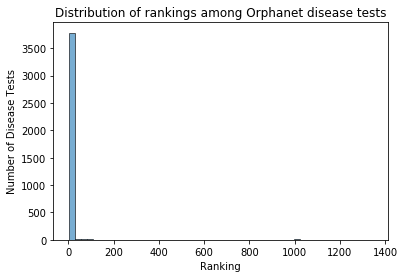

In [97]:
#histogram of rankings for orphanet disease data (each disease run once)
plt.hist(compiled_ranks2, bins=50, alpha = 0.6, ec = "black")
plt.xlabel("Ranking")
plt.ylabel("Number of Disease Tests")
plt.title("Distribution of rankings among Orphanet disease tests")
plt.show()

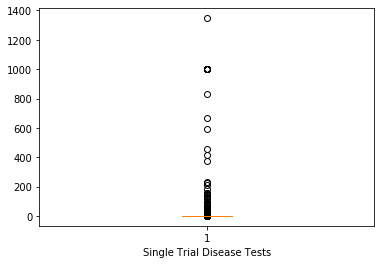

In [98]:
plt.boxplot(compiled_ranks2)
plt.xlabel("Single Trial Disease Tests")
plt.show()